# Описание проекта

# Импорт библиотек

In [743]:
%matplotlib inline
import pandas as pd
import numpy as np

from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.pipeline import Pipeline

from sklearn.compose import ColumnTransformer

from catboost import CatBoostClassifier
import catboost

import ydata_profiling
import phik

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from pylab import rcParams
import warnings

sns.set(style="darkgrid")
rcParams['figure.figsize'] = 20, 9

import sys

In [454]:
pd.set_option('display.max_columns', None)

In [455]:
sys.path.append('./train')

In [456]:
from metrics_f1 import calc_f1_score

# Загрузка данных

In [457]:
path_train = r"./train"

In [458]:
month_to_predict = pd.to_datetime('2023-12-01')

## Чистые данные для функций

In [459]:
# данные по дислокации
dislok_clear = pd.read_parquet(path_train + '/dislok_wagons.parquet').convert_dtypes()
# список вагонов с остаточным пробегом на момент прогноза
wag_prob_clear = pd.read_parquet(path_train + '/wagons_probeg_ownersip.parquet').convert_dtypes()
 # параметры вагона
wag_param_clear = pd.read_parquet(path_train + '/wag_params.parquet').convert_dtypes()
# таргет по прогноза выбытия вагонов в ПР на месяц и на 10 дней
target_clear = pd.read_csv(path_train +'/target/y_train.csv').convert_dtypes()
# текущие ремонты вагонов
tr_rem_clear = pd.read_parquet(path_train + '/tr_rems.parquet').convert_dtypes()
# данные по текущим ремонтам
pr_rem_clear = pd.read_parquet(path_train + '/pr_rems.parquet').convert_dtypes()

## Список вагонов с остаточным пробегом (wagons_probeg_ownersip)

In [460]:
# список вагонов с остаточным пробегом на момент прогноза
wag_prob = pd.read_parquet(path_train + '/wagons_probeg_ownersip.parquet').convert_dtypes()

In [461]:
wag_prob.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6249857 entries, 0 to 9249588
Data columns (total 8 columns):
 #   Column          Dtype         
---  ------          -----         
 0   repdate         datetime64[ns]
 1   wagnum          Int64         
 2   ost_prob        Int64         
 3   manage_type     Int64         
 4   rod_id          Int64         
 5   reestr_state    Int64         
 6   ownership_type  Int64         
 7   month           Int64         
dtypes: Int64(7), datetime64[ns](1)
memory usage: 470.9 MB


In [462]:
wag_prob['repdate'].unique()

array(['2022-08-01T00:00:00.000000000', '2022-08-02T00:00:00.000000000',
       '2022-08-03T00:00:00.000000000', '2022-08-04T00:00:00.000000000',
       '2022-08-05T00:00:00.000000000', '2022-08-06T00:00:00.000000000',
       '2022-08-07T00:00:00.000000000', '2022-08-08T00:00:00.000000000',
       '2022-08-09T00:00:00.000000000', '2022-08-10T00:00:00.000000000',
       '2022-08-11T00:00:00.000000000', '2022-08-12T00:00:00.000000000',
       '2022-08-13T00:00:00.000000000', '2022-08-14T00:00:00.000000000',
       '2022-08-15T00:00:00.000000000', '2022-08-16T00:00:00.000000000',
       '2022-08-17T00:00:00.000000000', '2022-08-18T00:00:00.000000000',
       '2022-08-19T00:00:00.000000000', '2022-08-20T00:00:00.000000000',
       '2022-08-21T00:00:00.000000000', '2022-08-22T00:00:00.000000000',
       '2022-08-23T00:00:00.000000000', '2022-08-24T00:00:00.000000000',
       '2022-08-25T00:00:00.000000000', '2022-08-26T00:00:00.000000000',
       '2022-08-27T00:00:00.000000000', '2022-08-28

In [463]:
wag_prob['repdate'].max()

Timestamp('2023-01-31 00:00:00')

In [464]:
wag_prob['repdate'].min()

Timestamp('2022-08-01 00:00:00')

In [465]:
wag_prob[wag_prob['repdate'] == month_to_predict].head()

Empty DataFrame
Columns: [repdate, wagnum, ost_prob, manage_type, rod_id, reestr_state, ownership_type, month]
Index: []

In [466]:
wag_prob[(wag_prob.repdate <= '2023-01-01')]['wagnum'].nunique()

33977

In [467]:
wag_prob[(wag_prob.repdate == '2023-01-01')]['repdate'].unique()

array(['2023-01-01T00:00:00.000000000'], dtype='datetime64[ns]')

**Примечание**: Брать нужные на дату данные по номеру вагона и минимальные

Нужно взять:
* как в base-line считать mean_run

Можно попробовать взять:
* Предсказывать mean_run моделью отдельной

### ~~Проверяем как отобрать все вагоны на плановую дату или раньше, если на плановую дату данных нет~~

In [468]:
wag_prob[(wag_prob.repdate == '2023-01-01')]['wagnum'].nunique()

33973

## Дислокация вагонов (dislok_wagons)

In [469]:
# данные по дислокации
dislok = pd.read_parquet(path_train + '/dislok_wagons.parquet').convert_dtypes()

In [470]:
dislok.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6250933 entries, 0 to 1052924
Data columns (total 16 columns):
 #   Column        Dtype         
---  ------        -----         
 0   plan_date     datetime64[ns]
 1   wagnum        Int64         
 2   date_kap      datetime64[ns]
 3   date_dep      datetime64[ns]
 4   kod_vrab      Int64         
 5   date_pl_rem   datetime64[ns]
 6   id_road_disl  Int64         
 7   st_id_dest    Int64         
 8   id_road_dest  Int64         
 9   st_id_send    Int64         
 10  id_road_send  Int64         
 11  ost_prob      Int64         
 12  isload        Int64         
 13  fr_id         Int64         
 14  last_fr_id    Int64         
 15  distance      Int64         
dtypes: Int64(12), datetime64[ns](4)
memory usage: 882.3 MB


In [471]:
dislok['plan_date'].max()

Timestamp('2023-01-31 00:00:00')

In [472]:
dislok['plan_date'].unique()

array(['2022-08-01T00:00:00.000000000', '2022-08-02T00:00:00.000000000',
       '2022-08-03T00:00:00.000000000', '2022-08-04T00:00:00.000000000',
       '2022-08-05T00:00:00.000000000', '2022-08-06T00:00:00.000000000',
       '2022-08-07T00:00:00.000000000', '2022-08-08T00:00:00.000000000',
       '2022-08-09T00:00:00.000000000', '2022-08-10T00:00:00.000000000',
       '2022-08-11T00:00:00.000000000', '2022-08-12T00:00:00.000000000',
       '2022-08-13T00:00:00.000000000', '2022-08-14T00:00:00.000000000',
       '2022-08-15T00:00:00.000000000', '2022-08-16T00:00:00.000000000',
       '2022-08-17T00:00:00.000000000', '2022-08-18T00:00:00.000000000',
       '2022-08-19T00:00:00.000000000', '2022-08-20T00:00:00.000000000',
       '2022-08-21T00:00:00.000000000', '2022-08-22T00:00:00.000000000',
       '2022-08-23T00:00:00.000000000', '2022-08-24T00:00:00.000000000',
       '2022-08-25T00:00:00.000000000', '2022-08-26T00:00:00.000000000',
       '2022-08-27T00:00:00.000000000', '2022-08-28

In [473]:
dislok[dislok['plan_date'] == dislok['plan_date'].max()].head()

plan_date  wagnum   date_kap   date_dep  kod_vrab date_pl_rem  \
30  2023-01-31   23398 2021-10-04 2019-05-24         0  2024-10-04   
61  2023-01-31   31528        NaT 2021-12-16         1  2024-12-16   
92  2023-01-31   20486 2021-04-04 2019-07-30         0  2024-04-04   
123 2023-01-31   16526        NaT 2022-05-17         1  2025-05-17   
154 2023-01-31   18061 2022-02-23 2019-08-09         0  2025-02-23   

     id_road_disl  st_id_dest  id_road_dest  st_id_send  id_road_send  \
30             15        3376            15        6152            28   
61             15        3376            15        6152            28   
92             44       12651            38       12318            44   
123            41          22            41        2258            11   
154            36          22            36        8971            36   

     ost_prob  isload  fr_id  last_fr_id  distance  
30      64018       1   1083        1083       999  
61      44948       1   1083        1083        -1  
92       7988       0   5032        2336      5025  
123    114983       1   3266        3266        -1  
154    104774       0   1639        1639      4051

In [474]:
dislok[dislok['plan_date'] == '2022-12-01'].head()

plan_date  wagnum   date_kap   date_dep  kod_vrab date_pl_rem  \
0   2022-12-01     755        NaT 2020-12-27         0  2023-12-27   
31  2022-12-01   15406 2014-11-04 2022-03-29         0  2025-03-29   
62  2022-12-01   10463 2019-06-09 2021-06-02         0  2024-06-02   
93  2022-12-01   14299 2014-09-14 2020-08-24         0  2023-08-24   
124 2022-12-01   11023 2022-02-10 2020-04-27         0  2025-02-10   

     id_road_disl  st_id_dest  id_road_dest  st_id_send  id_road_send  \
0              40       11835            43        9473            37   
31             28          22            28        6152            28   
62             28          22            28        6152            28   
93             28          22            28        6152            28   
124            36          22            36        8957            36   

     ost_prob  isload  fr_id  last_fr_id  distance  
0       49210       1   5036        5036        -1  
31     122806       0    727         727        -1  
62      41468       0    727         727        -1  
93       9336       0    727         727        -1  
124    113088       0   1642        1642        -1

### ~~Проверяем как отобрать все вагоны на плановую дату или раньше, если на плановую дату данных нет~~

In [475]:
dislok[dislok['plan_date'] == '2023-01-01']['wagnum'].nunique()

33966

In [476]:
dislok[dislok['plan_date'] == '2022-12-31']['wagnum'].nunique()

33968

In [477]:
dislok[~(dislok['wagnum'].isin(list(dislok[dislok['plan_date'] == '2022-12-31']['wagnum'].unique())))]\
.drop_duplicates(subset='wagnum', keep='last')

plan_date  wagnum   date_kap   date_dep  kod_vrab date_pl_rem  \
347     2022-12-07   11219 2008-09-02 2017-11-17         2  2019-06-27   
730409  2022-12-12   28344 2011-12-15 2020-01-03         2  2022-11-30   
993683  2022-12-22   26318 2015-11-25 2020-02-22         2  2023-01-01   
1052559 2022-12-07   11221 2009-12-11 2017-08-31         2  2019-06-20   
1052628 2022-12-07   16389 2009-09-04 2018-04-23         2  2019-07-01   
1052635 2022-12-07   33229 2010-09-28 2014-06-23         2  2016-06-01   
1052642 2022-12-07   11097 2008-12-15 2017-05-16         2  2019-05-28   
1052711 2022-12-07   11220 2008-08-05 2017-08-28         2  2019-04-30   
1052718 2022-12-07   16387 2009-02-17 2017-11-16         2  2019-07-01   

         id_road_disl  st_id_dest  id_road_dest  st_id_send  id_road_send  \
347                28          22            28        6279            28   
730409             11          22            11        1818            11   
993683             16          22            16        4524            16   
1052559            28        6279            28        6279            28   
1052628            44       12086            44       12086            44   
1052635            25       12606            25       12606            25   
1052642            28        6279            28        6279            28   
1052711            25       12606            25       12606            25   
1052718            44       12086            44       12086            44   

         ost_prob  isload  fr_id  last_fr_id  distance  
347         38981       0      0         615        -1  
730409       <NA>       0   5032         724        -1  
993683      86877       0   5032         714       187  
1052559      9598       0      0           0      1937  
1052628     73371       0      0           0        -1  
1052635    154724       0      0           0      2088  
1052642     58055       0      0           0        -1  
1052711     48543       0      0           0        -1  
1052718     28623       0      0           0        -1

In [478]:
dislok[~(dislok['wagnum'].isin(list(dislok[dislok['plan_date'] == '2022-12-31']['wagnum'].unique())))]\
.drop_duplicates(subset='wagnum', keep='last')['plan_date'].count()

9

In [479]:
dislok[(dislok['plan_date'] == '2022-12-31') | (dislok['plan_date'] == (dislok['plan_date'] .max()))]\
['wagnum'].nunique()

33968

In [480]:
# Уже в функции
dislok_test =\
dislok[(dislok['plan_date'] <= '2022-12-31')]\
.drop_duplicates(subset='wagnum', keep='first')

In [481]:
dislok_test['wagnum'].nunique()

33977

In [482]:
dislok_test[~(dislok_test['wagnum'].isin(list(dislok[dislok['plan_date'] == '2022-12-31']['wagnum'].unique())))]

plan_date  wagnum   date_kap   date_dep  kod_vrab date_pl_rem  \
794096  2022-08-01   26318 2015-11-25 2020-02-22         2  2023-01-01   
877889  2022-08-01   28344 2011-12-15 2020-01-03         2  2022-11-30   
1052977 2022-08-01   11219 2008-09-02 2017-11-17         2  2019-06-27   
1052995 2022-08-01   11220 2008-08-05 2017-08-28         2  2019-04-30   
1053013 2022-08-01   11221 2009-12-11 2017-08-31         2  2019-06-20   
1053031 2022-08-01   11097 2008-12-15 2017-05-16         2  2019-05-28   
1053049 2022-08-01   16387 2009-02-17 2017-11-16         2  2019-07-01   
1053067 2022-08-01   16389 2009-09-04 2018-04-23         2  2019-07-01   
1053085 2022-08-01   33229 2010-09-28 2014-06-23         2  2016-06-01   

         id_road_disl  st_id_dest  id_road_dest  st_id_send  id_road_send  \
794096             38       10348            38        3388            15   
877889             15        3388            15        6152            28   
1052977            28          22            28        6279            28   
1052995            25       12606            25       12606            25   
1053013            28        6279            28        6279            28   
1053031            28        6279            28        6279            28   
1053049            44       12086            44       12086            44   
1053067            44       12086            44       12086            44   
1053085            25       12606            25       12606            25   

         ost_prob  isload  fr_id  last_fr_id  distance  
794096       8206       0   2255        1083      3282  
877889       6819       1   1083        1083        -1  
1052977     38981       0      0         615        -1  
1052995     48543       0      0           0        88  
1053013      9598       0      0           0         8  
1053031     58055       0      0           0        84  
1053049     28623       0      0           0        28  
1053067     73371       0      0           0        34  
1053085    154724       0      0           0        28

In [483]:
dislok_test[~(dislok_test['wagnum'].isin(list(dislok[dislok['plan_date'] == '2022-12-31']['wagnum'].unique())))]['plan_date'].count()

9

### Выводы по полям

**Примечание**: Есть данные по дислокациям за прошедший месяц

Нужно взять:
* Был ли ремнот в прошедшем месяце, условие на номер вагона как в base-line
* Сколько было ремонтов в прошедшем месяце, count по kod_vrab
* Дней с момента ремонта на дату среза, month_to_predict - rem_month
    * Для 10 дней: month_to_predict + timedelta('10 days') - rem_month
    * Для месяца: month_to_predict + timedelta('31 days') - rem_month
    
Можно взять:
* distance как-то юзать чтобы проверять насколько близок ремонт был
* проверять как-то станции (road_id_send, road_id_rem) и дороги (road_id_send, road_id_rem), но пока непонятно на что

## Параметры вагона (wag_params)

In [484]:
# параметры вагона
wag_param = pd.read_parquet(path_train + '/wag_params.parquet').convert_dtypes()

In [485]:
# у вагонов могут меняться параметры, поэтмоу номер дублируется
wag_param = wag_param.drop_duplicates(subset='wagnum', keep='last')

In [486]:
wag_param.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33977 entries, 3218 to 33707
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   wagnum              33977 non-null  Int64         
 1   model               33977 non-null  string        
 2   rod_id              33977 non-null  Int64         
 3   gruz                33977 non-null  Int64         
 4   cnsi_gruz_capacity  33977 non-null  Int64         
 5   cnsi_volumek        33977 non-null  Float64       
 6   tara                33977 non-null  Int64         
 7   date_build          33977 non-null  datetime64[ns]
 8   srok_sl             33977 non-null  datetime64[ns]
 9   zavod_build         33977 non-null  Int64         
 10  date_iskl           116 non-null    datetime64[ns]
 11  cnsi_probeg_dr      33977 non-null  Int64         
 12  cnsi_probeg_kr      33977 non-null  Int64         
 13  kuzov               33977 non-null  Int64  

In [487]:
wag_param.head()

wagnum       model  rod_id  gruz  cnsi_gruz_capacity  cnsi_volumek  \
3218    26318   12-600-04       1   682                 682          85.0   
19128   28344      12-132       1   700                 700          88.0   
21526    8099      11-286       0   670                 670         138.0   
32353   33350  12-9850-02       1   750                 750          90.0   
81       5308      11-276       0   680                 680         122.0   

       tara date_build    srok_sl  zavod_build  date_iskl  cnsi_probeg_dr  \
3218    240 1992-12-25 2022-04-27            5 2023-02-16             160   
19128   240 2003-08-12 2024-12-24            0 2022-12-14             110   
21526   270 1995-08-31 2027-10-01            1        NaT             110   
32353   248 2014-10-27 2047-02-05           19        NaT             250   
81      260 1995-09-17 2027-09-28            1        NaT             110   

       cnsi_probeg_kr  kuzov  telega  tormoz tipvozd  tippogl  norma_km  \
3218              160      2       9       3       6       11    110000   
19128             160      2       9       2       1       12         0   
21526             160      2       9       2       1        1    160000   
32353             500      2      11       2       7       12    250000   
81                160      2       9       2       1       11    160000   

       ownertype  
3218           0  
19128          0  
21526          1  
32353          1  
81             1

### Выводы по полям

**Примечание**: Брать последние данные по номеру вагона убирая дубли

Нужно попробовать взять:
* Всё

Из важного:
* Срок службы
* cnsi_probeg_dr, cnsi_probeg_kr - нормы пробега

## Плановые ремонты (pr_rems)

In [488]:
# данные по текущим ремонтам
pr_rem = pd.read_parquet(path_train + '/pr_rems.parquet').convert_dtypes()

In [489]:
pr_rem.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10441 entries, 0 to 1515
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   wagnum        10441 non-null  Int64         
 1   rem_month     10441 non-null  datetime64[ns]
 2   rod_id        10441 non-null  Int64         
 3   model         10441 non-null  string        
 4   road_id_send  10441 non-null  Int64         
 5   road_id_rem   10441 non-null  Int64         
 6   kod_vrab      10441 non-null  Int64         
 7   st_id_send    10441 non-null  Int64         
 8   st_id_rem     10441 non-null  Int64         
 9   distance      10441 non-null  Int64         
 10  month         10441 non-null  Int64         
dtypes: Int64(9), datetime64[ns](1), string(1)
memory usage: 1.0 MB


In [490]:
pr_rem['month'].max()

12

In [491]:
pr_rem[pr_rem['month'] == pr_rem['month'].max()].head()

wagnum  rem_month  rod_id       model  road_id_send  road_id_rem  kod_vrab  \
2   22548 2022-12-08       1  12-1303-01             6            7         1   
3   24902 2022-12-07       1  12-1303-01             6            7         1   
4   27478 2022-12-06       1  12-7023-02             6            7         1   
5    6458 2022-12-17       0      11-276             6            6         0   
6    6678 2022-12-14       0      11-280             3            3         1   

   st_id_send  st_id_rem  distance  month  
2        4421       3940       842     12  
3        4421       3940       827     12  
4        4421       3940       161     12  
5        3946       3940        96     12  
6         457        420       770     12

In [492]:
pr_rem[pr_rem['month'] == pr_rem['month'].max()].count()

wagnum          1597
rem_month       1597
rod_id          1597
model           1597
road_id_send    1597
road_id_rem     1597
kod_vrab        1597
st_id_send      1597
st_id_rem       1597
distance        1597
month           1597
dtype: int64

### Выводы по полям

**Примечание:** Есть данные по плановым ремонтам за прошедший месяц

Нужно взять:
* Был ли ремнот в прошедшем месяце, условие на номер вагона как в base-line
* Сколько было ремонтов в прошедшем месяце, count по kod_vrab
* Дней с момента ремонта на дату среза, month_to_predict - rem_month
    * Для 10 дней: month_to_predict + timedelta('10 days') - rem_month
    * Для месяца: month_to_predict + timedelta('31 days') - rem_month
    
Можно взять:
* distance как-то юзать чтобы проверять насколько близок ремонт был
* проверять как-то станции (road_id_send, road_id_rem) и дороги (road_id_send, road_id_rem), но пока непонятно на что

## Текущие ремонты (tr_rems)

In [493]:
# текущие ремонты вагонов
tr_rem = pd.read_parquet(path_train + '/tr_rems.parquet').convert_dtypes()

In [494]:
tr_rem.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48652 entries, 0 to 7699
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   wagnum        48652 non-null  Int64         
 1   rem_month     48652 non-null  datetime64[ns]
 2   kod_vrab      48652 non-null  Int64         
 3   neis1_kod     48652 non-null  Int64         
 4   neis2_kod     48652 non-null  Int64         
 5   neis3_kod     48652 non-null  Int64         
 6   mod1_kod      48652 non-null  Int64         
 7   mod2_kod      48652 non-null  Int64         
 8   mod3_kod      48652 non-null  Int64         
 9   mod4_kod      48652 non-null  Int32         
 10  mod5_kod      48652 non-null  Int32         
 11  mod6_kod      48652 non-null  Int32         
 12  mod7_kod      48652 non-null  Int32         
 13  road_id_send  48652 non-null  Int64         
 14  gr_probeg     47920 non-null  Int64         
 15  por_probeg    47977 non-null  Int64  

In [495]:
tr_rem['rem_month'].max()

Timestamp('2023-01-01 00:00:00')

In [496]:
tr_rem['rem_month'].unique()

array(['2022-08-01T00:00:00.000000000', '2022-09-01T00:00:00.000000000',
       '2022-10-01T00:00:00.000000000', '2022-11-01T00:00:00.000000000',
       '2022-12-01T00:00:00.000000000', '2023-01-01T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [497]:
tr_rem[tr_rem['rem_month'] == month_to_predict]\
.sort_values(by='wagnum') \
.head()

Empty DataFrame
Columns: [wagnum, rem_month, kod_vrab, neis1_kod, neis2_kod, neis3_kod, mod1_kod, mod2_kod, mod3_kod, mod4_kod, mod5_kod, mod6_kod, mod7_kod, road_id_send, gr_probeg, por_probeg, st_id_send]
Index: []

In [498]:
tr_rem[tr_rem['rem_month'] == month_to_predict - pd.to_timedelta('31 d')]\
.sort_values(by='wagnum') \
.head()

Empty DataFrame
Columns: [wagnum, rem_month, kod_vrab, neis1_kod, neis2_kod, neis3_kod, mod1_kod, mod2_kod, mod3_kod, mod4_kod, mod5_kod, mod6_kod, mod7_kod, road_id_send, gr_probeg, por_probeg, st_id_send]
Index: []

### Выводы по полям

**Примечание**: Есть данные текущим по ремонтам за прошедший месяц

Нужно взять:
* Пробег вагона в груженном состоянии (gr_probeg), дельта, изменения по месяцам для предсказания **месяца**/10 дней
* Пробег вагона в ???  (gr_probeg), дельта, изменения по месяцам для предсказания **месяца**/10 дней

## Данные по КТИ (kti_izm)

In [499]:
# текущие ремонты вагонов
df_kti_izm = pd.read_parquet(path_train + '/kti_izm.parquet').convert_dtypes()

In [500]:
df_kti_izm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22428 entries, 43 to 212366
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   wagnum               22428 non-null  Int64  
 1   operation_date_dttm  22428 non-null  object 
 2   mileage_all          22155 non-null  Int64  
 3   axl1_l_w_flange      22416 non-null  Float64
 4   axl1_r_w_flange      22409 non-null  Float64
 5   axl2_l_w_flange      22412 non-null  Float64
 6   axl2_r_w_flange      22408 non-null  Float64
 7   axl3_l_w_flange      22411 non-null  Float64
 8   axl3_r_w_flange      22407 non-null  Float64
 9   axl4_l_w_flange      22413 non-null  Float64
 10  axl4_r_w_flange      22416 non-null  Float64
 11  axl1_l_w_rim         22287 non-null  Float64
 12  axl1_r_w_rim         22296 non-null  Float64
 13  axl2_l_w_rim         22293 non-null  Float64
 14  axl2_r_w_rim         22292 non-null  Float64
 15  axl3_l_w_rim         22251 non-nul

## Справочник грузов (freight_info)

In [501]:
# текущие ремонты вагонов
df_freight_info = pd.read_parquet(path_train + '/freight_info.parquet').convert_dtypes()

In [502]:
df_freight_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5079 entries, 0 to 5078
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   fr_id       5079 non-null   Int64
 1   fr_class    5079 non-null   Int64
 2   skoroport   5079 non-null   Int64
 3   naval       5079 non-null   Int64
 4   nasip       5079 non-null   Int64
 5   naliv       5079 non-null   Int64
 6   openvagons  5079 non-null   Int64
 7   soprovod    5079 non-null   Int64
 8   smerz       5079 non-null   Int64
dtypes: Int64(9)
memory usage: 401.9 KB


## Справочник станций (stations)

In [503]:
# текущие ремонты вагонов
df_stations = pd.read_parquet(path_train + '/stations.parquet').convert_dtypes()

In [504]:
df_stations.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148032 entries, 0 to 16447
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   st_id              148032 non-null  Int64 
 1   road_id            148032 non-null  Int64 
 2   st_border_sign     148032 non-null  string
 3   st_sea_sign        148032 non-null  string
 4   st_river_sign      148032 non-null  string
 5   st_car_sign        148032 non-null  string
 6   st_ferry_sign      148032 non-null  string
 7   st_freigh_sign     148032 non-null  string
 8   opor_station_sign  148032 non-null  string
dtypes: Int64(2), string(7)
memory usage: 11.6 MB


## target

In [505]:
# таргет по прогноза выбытия вагонов в ПР на месяц и на 10 дней
target = pd.read_csv(path_train +'/target/y_train.csv').convert_dtypes()

In [506]:
target.head()

wagnum       month  target_month  target_day
0   33361  2023-01-01             0           0
1   33364  2023-01-01             0           0
2   33366  2023-01-01             0           0
3   33358  2023-01-01             0           0
4   33349  2023-01-01             0           0

In [507]:
target['wagnum'].min(), target['wagnum'].max()

(0, 33976)

In [508]:
target.month = pd.to_datetime(target.month)

In [509]:
target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203853 entries, 0 to 203852
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   wagnum        203853 non-null  Int64         
 1   month         203853 non-null  datetime64[ns]
 2   target_month  203853 non-null  Int64         
 3   target_day    203853 non-null  Int64         
dtypes: Int64(3), datetime64[ns](1)
memory usage: 6.8 MB


In [510]:
target.tail()

wagnum      month  target_month  target_day
203848   25045 2022-12-01             0           0
203849   27156 2022-12-01             0           0
203850   21361 2022-12-01             0           0
203851    8061 2022-12-01             0           0
203852   33350 2022-12-01             1           0

In [511]:
target_m = target.copy()

In [512]:
target_m = target_m[target_m.month == '2022-12-01'][['wagnum','target_month','target_day']]

In [513]:
target_m.target_month.sum(), target_m.target_day.sum()

(1584, 570)

In [514]:
target_m.query('target_day == 1')['wagnum'].count(), target_m.query('target_month == 1')['wagnum'].count()

(570, 1584)

In [515]:
target_m.head()

wagnum  target_month  target_day
169876   33361             0           0
169877   33364             1           1
169878   33366             1           1
169879   33358             0           0
169880   33349             0           0

In [516]:
target_m.query('target_day == 1').head(15)

wagnum  target_month  target_day
169877   33364             1           1
169878   33366             1           1
169895   29907             1           1
169901   29933             1           1
170183    1876             1           1
170184    1882             1           1
170191    1904             1           1
170192    1907             1           1
170198    1927             1           1
170199    1930             1           1
170201    1936             1           1
170310    1061             1           1
170388    5306             1           1
170391    6427             1           1
170443    7483             1           1

In [517]:
target[target['month'] == '2023-01-01']['wagnum'].nunique()

33973

### Баланс классов

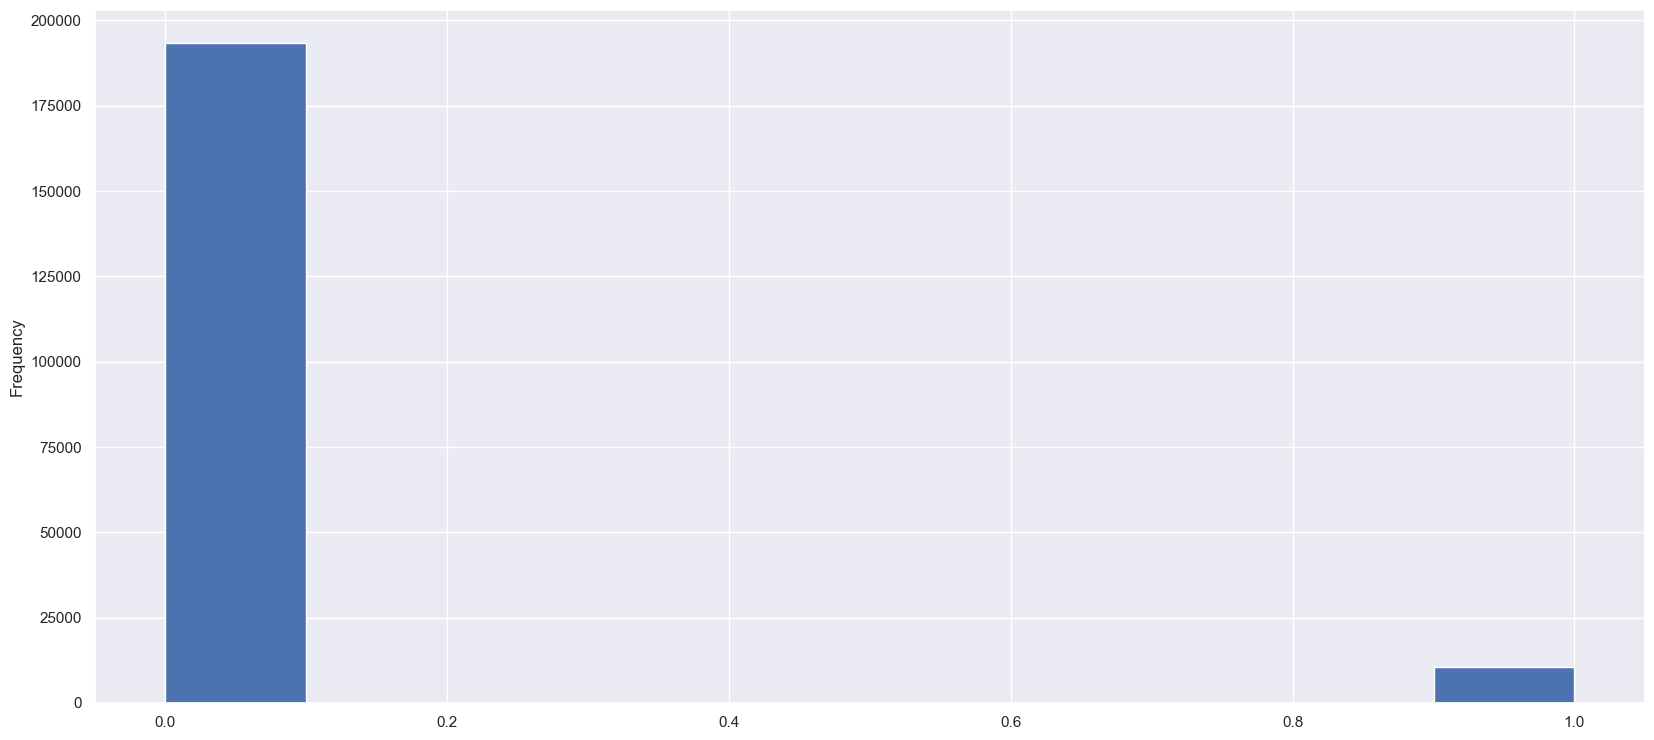

In [518]:
target['target_month'].plot(kind='hist')
plt.show()

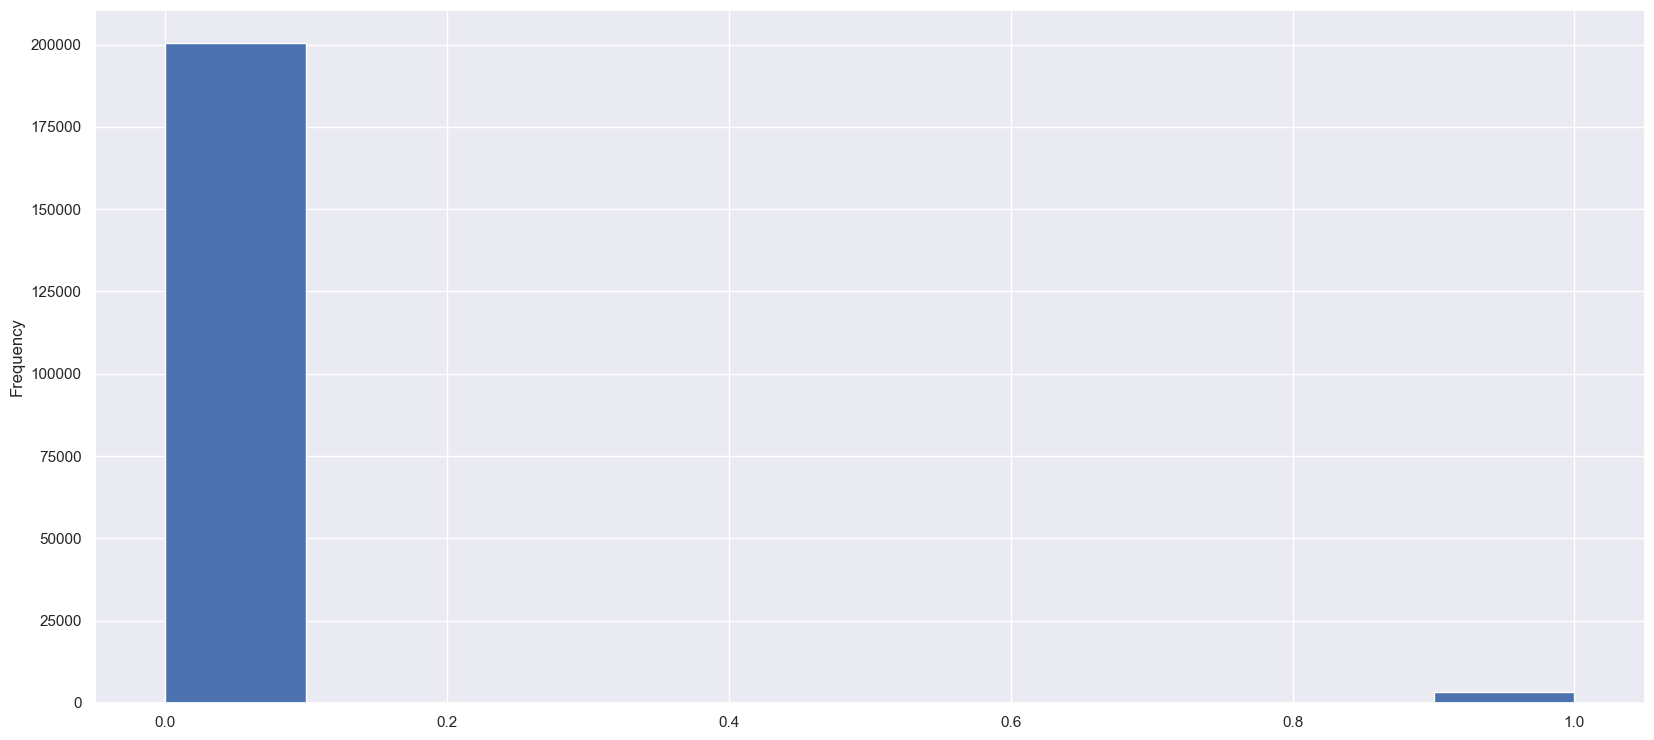

In [519]:
target['target_day'].plot(kind='hist')
plt.show()

# EDA

Посмотреть:
1. Какие параметры из wag_params (тmodel и т.д.) чаще ломаются. Проверить разные типы вагонов
2. Распределения
    1. Кол-во ремонтов на месяц службы
    1. Распределение кол-ва дней до ремонта после ремонта текущего/планового
    1. Распределение при каких значениях в момент среза наступает ремонт в течение месяца

Проверить теорию о влиянии параметров на текущие ремонты:
* Интенсивность эксплуатации, разная норма расхода пробега между ремонтами. Может определятся:
    * География
    * Кто использует вагон
* Перевозимые грузы, посмотреть часто перевозимые грузы по вагонам и их влияние на текущие ремонты
* Норма пробега между плановыми ремонтами
* Календарная норма между плановыми ремонтами

Особое внимание - истечение межремонтного интервала (км пробега) от чего зависит, текущие ремонты снижают межремонтный интервал

## Влияние различных параметров на текущие ремонты

Посчитаем среднемесячное кол-во на ремонт в зависимости от параметров

### Создаём функцию

In [520]:
tr_rem_copy = tr_rem.copy() 

In [521]:
tr_rem_copy['month'] = \
tr_rem_copy['rem_month'].dt.month

In [522]:
tr_rem_copy['month'].unique()

array([ 8,  9, 10, 11, 12,  1], dtype=int64)

In [523]:
tr_rem_wag_mon =\
tr_rem_copy.groupby(['wagnum', 'month'])['kod_vrab'].count()\
.reset_index('month')

In [524]:
wag_param_mon_join =\
tr_rem_wag_mon.join(wag_param.set_index('wagnum'), how='inner')

In [525]:
wag_param_mon_join_agg =\
wag_param_mon_join.groupby(['month', 'model'])\
.agg({'kod_vrab': 'sum', 'model': 'count'})

In [526]:
# wag_param_mon_join_agg['w_tr_rem'] = (wag_param_mon_join_agg['kod_vrab'] * wag_param_mon_join_agg['model']).sum() / (wag_param_mon_join_agg['model']).sum()

In [527]:
wag_param_mon_join_agg =\
wag_param_mon_join_agg.rename(columns={'kod_vrab': 'count_tr_rem', 'model': 'count_wag'})

In [528]:
wag_param_mon_join_agg.head()

count_tr_rem  count_wag
month model                              
1     11-1268               17          8
      11-1807              104         50
      11-1807-01           514        267
      11-2135-01           317        172
      11-2163              142         86

In [529]:
wag_param_mon_join_agg['rem_wag_per_m'] = wag_param_mon_join_agg['count_tr_rem'] / wag_param_mon_join_agg['count_wag']

In [530]:
wag_param_mon_join_agg.reset_index(inplace=True)

In [531]:
wag_param_mon_join_agg.head()

month       model  count_tr_rem  count_wag  rem_wag_per_m
0      1     11-1268            17          8       2.125000
1      1     11-1807           104         50       2.080000
2      1  11-1807-01           514        267       1.925094
3      1  11-2135-01           317        172       1.843023
4      1     11-2163           142         86       1.651163

In [532]:
wag_param_mon_join_agg.groupby('model').mean()['rem_wag_per_m'].sort_values(ascending=False)

model
12-9837       2.416667
12-600-04     2.337418
12-600-02     2.298310
12-600-08     2.234900
12-295        2.149797
12-600-05     2.149665
12-1704-04    2.143623
12-783        2.128316
12-955        2.108333
11-270        2.077381
12-9046       2.068637
12-196-01     2.066667
12-1302       2.066667
12-9790       2.066100
12-9780       2.046413
12-9766       2.046053
12-7023-02    2.039045
12-9788-01    2.032590
12-9085       2.029861
12-4102       2.019333
11-1807       2.017092
12-532-02     2.000000
12-600-07     2.000000
12-753-03     2.000000
11-066-04     2.000000
Р-9494-01     2.000000
11-259        2.000000
12-296-01     1.995802
12-132-03     1.995548
11-7038       1.993400
12-132        1.975041
11-286        1.955645
12-1303-01    1.926767
11-280        1.920707
11-1807-01    1.914535
12-196-02     1.911331
11-276        1.904504
11-2135-01    1.889737
11-1268       1.881944
11-260        1.850000
12-9745       1.833333
11-9962       1.820508
11-264        1.777778
11-28

### Функция

In [533]:
def count_rems_per_month(tr_rem, wag_param, month_to_predict, col, months=False):
    tr_rem_copy = tr_rem.copy()
    
    tr_rem_copy = tr_rem_copy[tr_rem_copy['rem_month'] < month_to_predict]
    
    tr_rem_copy['month'] = \
    tr_rem_copy['rem_month'].dt.month
    if months:
        print('Месяца', tr_rem_copy['month'].unique())
    
    tr_rem_wag_mon =\
    tr_rem_copy.groupby(['wagnum', 'month'])['kod_vrab'].count()\
    .reset_index('month')
    
    wag_param_mon_join =\
    tr_rem_wag_mon.join(wag_param.set_index('wagnum'), how='inner')
    
    wag_param_mon_join_agg =\
    wag_param_mon_join.groupby(['month', col])\
    .agg({'kod_vrab': 'sum', col: 'count'})
    
    wag_param_mon_join_agg =\
    wag_param_mon_join_agg.rename(columns={'kod_vrab': 'count_tr_rem', col: 'count_wag'})
    
    wag_param_mon_join_agg['rem_wag_per_m'] = wag_param_mon_join_agg['count_tr_rem'] / wag_param_mon_join_agg['count_wag']
    
    return wag_param_mon_join_agg

In [534]:
count_rems_per_month(tr_rem, wag_param, '2023-01-01', 'model', True)

Месяца [ 8  9 10 11 12]


count_tr_rem  count_wag  rem_wag_per_m
month model                                             
8     11-066-04              2          1       2.000000
      11-1268                3          2       1.500000
      11-1807               70         38       1.842105
      11-1807-01           427        227       1.881057
      11-2135-01           337        183       1.841530
...                        ...        ...            ...
12    12-9780               77         34       2.264706
      12-9788-01           122         66       1.848485
      12-9790               42         22       1.909091
      12-9850-02             1          1       1.000000
      Р-9494-01              2          1       2.000000

[199 rows x 3 columns]

### Проверяем параметры вагона **wag_param**

In [535]:
wag_params = list(wag_param.columns)

In [536]:
wag_params.remove('wagnum')

In [537]:
wag_params

['model',
 'rod_id',
 'gruz',
 'cnsi_gruz_capacity',
 'cnsi_volumek',
 'tara',
 'date_build',
 'srok_sl',
 'zavod_build',
 'date_iskl',
 'cnsi_probeg_dr',
 'cnsi_probeg_kr',
 'kuzov',
 'telega',
 'tormoz',
 'tipvozd',
 'tippogl',
 'norma_km',
 'ownertype']

In [538]:
for param in wag_params:
    df_rem_by_param = count_rems_per_month(tr_rem, wag_param, '2023-01-01', param)
    
    print('Средне-месячное кол-во ТР одного вагона для значений параметра. Топ-10 самых токсичных')
    rem_by_param_group=\
    df_rem_by_param.groupby(param).mean()['rem_wag_per_m'].sort_values(ascending=False)
    
    print(rem_by_param_group.head(10))

Средне-месячное кол-во ТР одного вагона для значений параметра. Топ-10 самых токсичных
model
12-9837       2.416667
12-600-04     2.321569
12-600-02     2.291305
12-600-08     2.215214
12-295        2.208328
12-1704-04    2.175378
12-600-05     2.163271
12-955        2.130000
12-9085       2.124722
12-783        2.118844
Name: rem_wag_per_m, dtype: float64
Средне-месячное кол-во ТР одного вагона для значений параметра. Топ-10 самых токсичных
rod_id
1    2.003911
0    1.906747
Name: rem_wag_per_m, dtype: float64
Средне-месячное кол-во ТР одного вагона для значений параметра. Топ-10 самых токсичных
gruz
682    2.321569
706    2.291305
696    2.215214
693    2.163271
700    2.043672
688    2.042857
710    2.042292
703    2.031123
719    2.000000
695    1.969871
Name: rem_wag_per_m, dtype: float64
Средне-месячное кол-во ТР одного вагона для значений параметра. Топ-10 самых токсичных
cnsi_gruz_capacity
682    2.321569
706    2.291305
696    2.215214
693    2.163271
700    2.043672
688    2.

## Может ли вагон отправится в плановый ремонт в течение 10 дней, не отправляясь в течение месяца

Проверим может ли в target быть `target_day = 1`, когда `target_month = 0`

In [539]:
# Кол-во таргетов, где target_day == 1 and target_month == 0
target.query('target_day == 1 and target_month == 0')['wagnum'].count()

0

**Вывод:** нет, не может. Значит может для предикта target_day брать предикты target_month с истинной меткой

# Feature engineering

## Средне-месячное кол-во ТР для вагона и всех его параметров

In [540]:
def count_rems_per_month_one_wag(tr_rem, wag_param, month_to_predict, months=False):
    tr_rem_copy = tr_rem.copy()
    
    tr_rem_copy = tr_rem_copy[tr_rem_copy['rem_month'] < month_to_predict]
    
    tr_rem_copy['month'] = \
    tr_rem_copy['rem_month'].dt.month
    if months:
        print('\nМесяца count_rems_per_month_one_wag', tr_rem_copy['month'].unique(), '\n')
    
    tr_rem_wag_mon =\
    tr_rem_copy.groupby(['wagnum', 'month'])[['kod_vrab']].count()
    
    wag_param_mon_join =\
    tr_rem_wag_mon.join(wag_param.set_index('wagnum'), how='inner')
    
    wag_param_mon_join_agg =\
    wag_param_mon_join.groupby(['wagnum', 'month'])\
    .agg({'kod_vrab': 'sum'})
    
    wag_param_mon_join_agg =\
    wag_param_mon_join_agg.rename(columns={'kod_vrab': 'count_tr_rem_per_m'})
    
    
    return wag_param_mon_join_agg.reset_index()

In [541]:
wag_rem_months = count_rems_per_month_one_wag(tr_rem, wag_param, '2023-12-01', True)


Месяца count_rems_per_month_one_wag [ 8  9 10 11 12  1] 



In [542]:
wag_rem_months_group = wag_rem_months.groupby('wagnum').mean()[['count_tr_rem_per_m']].reset_index()

In [543]:
wag_rem_months_group.head()

wagnum  count_tr_rem_per_m
0       0                 1.0
1       2                 2.0
2       3                 2.0
3       6                 3.0
4       8                 2.0

In [544]:
wag_rem_months_group.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17849 entries, 0 to 17848
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   wagnum              17849 non-null  Int64  
 1   count_tr_rem_per_m  17849 non-null  float64
dtypes: Int64(1), float64(1)
memory usage: 296.4 KB


In [545]:
wag_param_test_merge =\
wag_param.merge(wag_rem_months_group, on='wagnum', how='left')

In [546]:
wag_param_test_merge

wagnum       model  rod_id  gruz  cnsi_gruz_capacity  cnsi_volumek  \
0       26318   12-600-04       1   682                 682          85.0   
1       28344      12-132       1   700                 700          88.0   
2        8099      11-286       0   670                 670         138.0   
3       33350  12-9850-02       1   750                 750          90.0   
4        5308      11-276       0   680                 680         122.0   
...       ...         ...     ...   ...                 ...           ...   
33972   18766      11-280       0   680                 680         138.0   
33973   18769      11-280       0   680                 680         138.0   
33974   18899      11-280       0   680                 680         138.0   
33975   18912      11-280       0   680                 680         138.0   
33976   18914      11-280       0   680                 680         138.0   

       tara date_build    srok_sl  zavod_build  date_iskl  cnsi_probeg_dr  \
0       240 1992-12-25 2022-04-27            5 2023-02-16             160   
1       240 2003-08-12 2024-12-24            0 2022-12-14             110   
2       270 1995-08-31 2027-10-01            1        NaT             110   
3       248 2014-10-27 2047-02-05           19        NaT             250   
4       260 1995-09-17 2027-09-28            1        NaT             110   
...     ...        ...        ...          ...        ...             ...   
33972   259 2013-01-07 2046-03-20            1        NaT             110   
33973   259 2013-01-18 2046-02-14            1        NaT             110   
33974   260 2013-07-24 2044-03-03            1        NaT             110   
33975   259 2015-02-28 2044-08-04            1        NaT             110   
33976   259 2013-06-16 2046-07-02            1        NaT             110   

       cnsi_probeg_kr  kuzov  telega  tormoz tipvozd  tippogl  norma_km  \
0                 160      2       9       3       6       11    110000   
1                 160      2       9       2       1       12         0   
2                 160      2       9       2       1        1    160000   
3                 500      2      11       2       7       12    250000   
4                 160      2       9       2       1       11    160000   
...               ...    ...     ...     ...     ...      ...       ...   
33972             160      2       9       2       7       12    160000   
33973             160      2       9       2       7       12    160000   
33974             160      2       9       2       7       11    160000   
33975             160      2       9       2       7       11    160000   
33976             160      2       9       2       7       11    160000   

       ownertype  count_tr_rem_per_m  
0              0                 NaN  
1              0                 2.0  
2              1                 NaN  
3              1                 1.0  
4              1                 NaN  
...          ...                 ...  
33972          0                 2.0  
33973          0                 NaN  
33974          0                 NaN  
33975          0                 NaN  
33976          0                 NaN  

[33977 rows x 21 columns]

In [547]:
for param in wag_params:
    df_rem_by_param = count_rems_per_month(tr_rem, wag_param, '2023-01-01', param)
    
    rem_by_param_group=\
    df_rem_by_param.groupby(param).mean()[['rem_wag_per_m']]
    
    rem_by_param_group=\
    rem_by_param_group.rename(columns={'rem_wag_per_m': f'{param}_rem_wag_per_m'})
    
    wag_param_test_merge =\
    wag_param_test_merge.merge(rem_by_param_group, on=param)

In [548]:
wag_param_test_merge

wagnum   model  rod_id  gruz  cnsi_gruz_capacity  cnsi_volumek  tara  \
0     6318  11-276       0   680                 680         122.0   260   
1     6327  11-276       0   680                 680         122.0   260   
2        6  11-270       0   688                 688         122.0   237   
3     7264  11-286       0   670                 670         138.0   270   
4    28577  12-132       1   695                 695          88.0   245   
..     ...     ...     ...   ...                 ...           ...   ...   
58   28488  12-132       1   695                 695          88.0   245   
59   28586  12-132       1   695                 695          88.0   244   
60   28524  12-132       1   695                 695          88.0   245   
61   28573  12-132       1   695                 695          88.0   244   
62   28595  12-132       1   695                 695          88.0   245   

   date_build    srok_sl  zavod_build  date_iskl  cnsi_probeg_dr  \
0  1993-01-10 2024-12-26            1 2023-05-26             110   
1  1991-12-18 2022-06-11            1 2023-05-26             110   
2  1996-08-21 2026-09-18            1 2023-09-18             110   
3  1993-06-01 2028-09-21            1 2023-09-18             110   
4  2002-11-11 2025-09-06            0 2023-07-11             110   
..        ...        ...          ...        ...             ...   
58 2000-10-10 2023-07-31            0 2023-08-17             110   
59 2001-04-12 2025-07-28            0 2023-07-11             110   
60 2001-05-24 2026-02-04            0 2023-08-21             110   
61 2002-10-16 2023-07-14            0 2023-07-26             110   
62 2003-06-07 2024-02-23            0 2023-09-13             110   

    cnsi_probeg_kr  kuzov  telega  tormoz tipvozd  tippogl  norma_km  \
0              160      2       9       3       1        1    160000   
1              160      2       9       3       1        1    160000   
2              160      2       9       3       1        1    160000   
3              160      2       9       3       1        1    160000   
4              160      2       9       3       1       11    160000   
..             ...    ...     ...     ...     ...      ...       ...   
58             160      2       9       2       1        4    110000   
59             160      2       9       3       4        4    110000   
60             160      2       9       2       4        4    110000   
61             160      2       9       2       4        4    110000   
62             160      2       9       2       4        4    110000   

    ownertype  count_tr_rem_per_m  model_rem_wag_per_m  rod_id_rem_wag_per_m  \
0           0            1.500000             1.890703              1.906747   
1           0            2.000000             1.890703              1.906747   
2           0            3.000000             2.042857              1.906747   
3           0                 NaN             1.954073              1.906747   
4           0                 NaN             1.971476              2.003911   
..        ...                 ...                  ...                   ...   
58          0            2.000000             1.971476              2.003911   
59          0            4.000000             1.971476              2.003911   
60          0            1.000000             1.971476              2.003911   
61          0            1.333333             1.971476              2.003911   
62          0            2.000000             1.971476              2.003911   

    gruz_rem_wag_per_m  cnsi_gruz_capacity_rem_wag_per_m  \
0             1.857019                          1.857019   
1             1.857019                          1.857019   
2             2.042857                          2.042857   
3             1.937393                          1.937393   
4             1.969871                          1.969871   
..                 ...                               ...   
58            1.969871      

## Собираем всё в функцию

In [549]:
def all_rems_for_wagon(tr_rem, wag_param, month_to_predict, m=True):
    wag_params = list(wag_param.columns)
    wag_params.remove('wagnum')
    wag_params.remove('date_iskl')
    
    wag_rem_months = count_rems_per_month_one_wag(tr_rem, wag_param, month_to_predict, m)
    
    wag_rem_months_group = wag_rem_months.groupby('wagnum').mean()[['count_tr_rem_per_m']].reset_index()
    
    wag_param = wag_param.copy()
    
    wag_param_test_merge =\
    wag_param.merge(wag_rem_months_group, on='wagnum', how='left')
    
    for param in wag_params:
        df_rem_by_param = count_rems_per_month(tr_rem, wag_param, month_to_predict, param, m)

        rem_by_param_group=\
        df_rem_by_param.groupby(param).mean()[['rem_wag_per_m']]

        rem_by_param_group=\
        rem_by_param_group.rename(columns={'rem_wag_per_m': f'{param}_rem_wag_per_m'})

        wag_param_test_merge =\
        wag_param_test_merge.merge(rem_by_param_group, on=param, how='left')
        
    return wag_param_test_merge

In [550]:
all_rems_for_wagon(tr_rem, wag_param, '2022-12-01')


Месяца count_rems_per_month_one_wag [ 8  9 10 11] 

Месяца [ 8  9 10 11]
Месяца [ 8  9 10 11]
Месяца [ 8  9 10 11]
Месяца [ 8  9 10 11]
Месяца [ 8  9 10 11]
Месяца [ 8  9 10 11]
Месяца [ 8  9 10 11]
Месяца [ 8  9 10 11]
Месяца [ 8  9 10 11]
Месяца [ 8  9 10 11]
Месяца [ 8  9 10 11]
Месяца [ 8  9 10 11]
Месяца [ 8  9 10 11]
Месяца [ 8  9 10 11]
Месяца [ 8  9 10 11]
Месяца [ 8  9 10 11]
Месяца [ 8  9 10 11]
Месяца [ 8  9 10 11]


wagnum       model  rod_id  gruz  cnsi_gruz_capacity  cnsi_volumek  \
0       26318   12-600-04       1   682                 682          85.0   
1       28344      12-132       1   700                 700          88.0   
2        8099      11-286       0   670                 670         138.0   
3       33350  12-9850-02       1   750                 750          90.0   
4        5308      11-276       0   680                 680         122.0   
...       ...         ...     ...   ...                 ...           ...   
33972   18766      11-280       0   680                 680         138.0   
33973   18769      11-280       0   680                 680         138.0   
33974   18899      11-280       0   680                 680         138.0   
33975   18912      11-280       0   680                 680         138.0   
33976   18914      11-280       0   680                 680         138.0   

       tara date_build    srok_sl  zavod_build  date_iskl  cnsi_probeg_dr  \
0       240 1992-12-25 2022-04-27            5 2023-02-16             160   
1       240 2003-08-12 2024-12-24            0 2022-12-14             110   
2       270 1995-08-31 2027-10-01            1        NaT             110   
3       248 2014-10-27 2047-02-05           19        NaT             250   
4       260 1995-09-17 2027-09-28            1        NaT             110   
...     ...        ...        ...          ...        ...             ...   
33972   259 2013-01-07 2046-03-20            1        NaT             110   
33973   259 2013-01-18 2046-02-14            1        NaT             110   
33974   260 2013-07-24 2044-03-03            1        NaT             110   
33975   259 2015-02-28 2044-08-04            1        NaT             110   
33976   259 2013-06-16 2046-07-02            1        NaT             110   

       cnsi_probeg_kr  kuzov  telega  tormoz tipvozd  tippogl  norma_km  \
0                 160      2       9       3       6       11    110000   
1                 160      2       9       2       1       12         0   
2                 160      2       9       2       1        1    160000   
3                 500      2      11       2       7       12    250000   
4                 160      2       9       2       1       11    160000   
...               ...    ...     ...     ...     ...      ...       ...   
33972             160      2       9       2       7       12    160000   
33973             160      2       9       2       7       12    160000   
33974             160      2       9       2       7       11    160000   
33975             160      2       9       2       7       11    160000   
33976             160      2       9       2       7       11    160000   

       ownertype  count_tr_rem_per_m  model_rem_wag_per_m  \
0              0                 NaN             2.360294   
1              0                 2.0             1.969122   
2              1                 NaN             1.932243   
3              1                 NaN                  NaN   
4              1                 NaN             1.861723   
...          ...                 ...                  ...   
33972          0                 2.0             1.902128   
33973          0                 NaN             1.902128   
33974          0                 NaN             1.902128   
33975          0                 NaN             1.902128   
33976          0                 NaN             1.902128   

       rod_id_rem_wag_per_m  gruz_rem_wag_per_m  \
0                  2.005706            2.360294   
1                  2.005706            2.050967   
2                  1.893871            1.920532   
3                  2.005706            1.890870   
4                  1.893871            1.847788   
...                     ...                 ...   
33972              1.893871            1.847788   
33973              1.893871            1.847788   
33974              1.893871            1.847788   
33975        

# Функция для создания данных

In [555]:
def make_wp(wag_param, wag_prob, pr_rem, tr_rem, dislok, target, month_to_predict='2023-01-01', month_prev=12, info=False):
    '''
    Передаём: параметры вагона, пробег вагона, плановые ремонты, дислокацию, таргет
    дату отчёта на которую предиктим (по умолчанию 2023-01-01), 
    предыдущий месяц от даты отчёта (по умолчанию 12)
    , информация о датасетах
    
    Возвращает: сэмпл фичей для обработки, target
    '''
    
    # Достаём ТАРГЕТ для нужной даты month_to_predict
    target.month = pd.to_datetime(target.month)
    
    target = target[target.month == month_to_predict]
    print('target', target['month'].unique())
    target = target[['wagnum','target_month','target_day']]
    
    
    print('\nДостаём данные')
    # Достаём ПРОБЕГ для нужной даты month_to_predict
    wag_prob = wag_prob[(wag_prob.repdate == month_to_predict) | (wag_prob.repdate == wag_prob.repdate.min())]
    
    print('\nwag_prob', wag_prob['repdate'].unique())
    
    # Оценим среднесуточный пробег из данных по пробегу вагона, на тот случай, если данных по нормативу нет
    wag_prob_ = wag_prob.groupby('wagnum', as_index = False).agg({'repdate':['max', 'min'] , 'ost_prob': ['max','min']},)#.droplevel(1)
    wag_prob_.columns = [head+'_' + name
                         if head!='wagnum'
                         else head
                         for head, name in wag_prob_.columns ]

    wag_prob_['diff_days'] = wag_prob_.repdate_max - wag_prob_.repdate_min
    wag_prob_['mean_run'] = (wag_prob_.ost_prob_max - wag_prob_.ost_prob_min )/ wag_prob_.diff_days.dt.days
    wag_prob = wag_prob[wag_prob.repdate == wag_prob.repdate.max()][['wagnum','ost_prob']]
    wag_prob = wag_prob.merge(wag_prob_[['wagnum','mean_run']])
    
    print('\nwag_param')
    # Достаём ПАРАМЕТРЫ вагона для нужной даты month_to_predict. У вагонов могут меняться параметры, поэтмоу номер дублируется
    wag_param = wag_param.drop_duplicates(subset='wagnum', keep='last')
    # wag_param = wag_param[['wagnum','srok_sl','cnsi_probeg_dr','cnsi_probeg_kr']]
    wag_param = all_rems_for_wagon(tr_rem, wag_param, month_to_predict, True)
    wag_param = wag_param.drop(columns=['date_iskl'])
    # print(wag_param)
    
    
    # Достаём данные по ПЛАНОВЫМ ремонтам за прошедший месяц
    pr_rem = pr_rem[pr_rem['month'] == month_prev].copy()
    
    print('\npr_rem', pr_rem['month'].unique()[0])
    
    # добавим признак, что вагон был в ПР в предыдущем месяце. Скорее всего, если вагон был в ПР недавно, то повторно он не поедет
    pr_rem['was_repair_in_prev_month'] = 1
    pr_rem = pr_rem[['wagnum','was_repair_in_prev_month']]
    pr_rem = pr_rem.drop_duplicates(subset='wagnum') #некоторые вагоны все же ремонтируются больше 1 раза, поэтому нужен сбросить дубли
    
    
    # Достаём данные по ТЕКУЩИМ ремонтам за прошедший месяц
    tr_rem = tr_rem[tr_rem['rem_month'].dt.month == month_prev]
    
    print('tr_rem', tr_rem['rem_month'].dt.month.unique()[0])
    
    tr_rem = tr_rem.groupby('wagnum', as_index= False).kod_vrab.count()
    
    
    # Достаём данные по ДИСЛОКАЦИИ для нужной даты month_to_predict
    dislok = dislok[dislok['plan_date'] <= month_to_predict] \
    .drop_duplicates(subset = 'wagnum', keep='last')
    print('\ndislok', dislok['plan_date'].unique())
    
    # Показать инфо
    if info:
        print('\n', wag_prob.info())
        print('\n', wag_param.info())
        print('\n', pr_rem.info())
        print('\n', tr_rem.info())
        print('\n', dislok.info())
    
    print('\nДелаем фичи')
    # Создаём фичи
    wp = target[['wagnum']].merge(wag_param, on ='wagnum', how = 'left')\
    .merge(wag_prob, how = 'left')\
    .merge(pr_rem, how = 'left')\
    .merge(tr_rem, how = 'left')\
    .merge(dislok[['wagnum','date_pl_rem']], how = 'left')
    

    print('\nЗаполняме пропуски')
    numeric_columns = wp.select_dtypes(include=['int', 'float'])
    # Заменим отсутствующие значения на нули
    wp[numeric_columns.columns] = numeric_columns.fillna(0)
    
    return wp, target

In [573]:
# UPD ошибка, надо передавать month_to_predict
def make_features_wp(wp, target, month_to_predict, month=True):
    '''
     Передаём: сэмпл фичей, target
     таргет за месяц (по умолчанию) или месяц + 10 дней
     
     Возрашает: фичи и таргет
    '''
    
    print('Считаем среднедневный пробег')
    # Считаем среднедневный пробег
    # wp[['cnsi_probeg_dr','cnsi_probeg_kr','mean_run', 'was_repair_in_prev_month', 'kod_vrab']] =\
    # wp[['cnsi_probeg_dr','cnsi_probeg_kr','mean_run', 'was_repair_in_prev_month', 'kod_vrab']].fillna(0)
    wp['day_run'] = wp.apply(lambda x : [ val  for val in [x.cnsi_probeg_kr, x.cnsi_probeg_dr, x.mean_run] if val != 0], axis = 1 )
    wp['day_run']= wp.apply(lambda x : np.mean(x.day_run) if len(x.day_run)> 0 else 0, axis = 1 )

    wp['current_date'] = pd.to_datetime(month_to_predict)
    # Дней до окончания срока службы на month_to_predict
    wp['date_diff_srk_sl'] = wp['srok_sl']- wp['current_date']
    # Дней до планового ремонта на month_to_predict
    wp['date_diff_pl_rem'] = wp['date_pl_rem']- wp['current_date']
    # Остаточный пробег на конец месяца
    wp['prob_end_month'] = wp['ost_prob'] - wp['day_run']* 30
    
    # print('Заполняме пропуски')
    # numeric_columns = wp.select_dtypes(include=['int', 'float'])
    # # Заменим отсутствующие значения на нули
    # wp[numeric_columns.columns] = numeric_columns.fillna(0)
    
    print('Сортируем номега вагонов')
    # Фичи
    X = wp.set_index('wagnum').sort_index()
    
    # Таргет
    y = target.set_index('wagnum').sort_index()
    
    # Если month == True, то оставляем таргет только для месяца
    if month:
        y = y['target_month']
        
    return X, y

In [553]:
# month_to_predict

Timestamp('2023-12-01 00:00:00')

# Тренировочный датасет

In [564]:
# %%time
wp_train, target_train = make_wp(wag_param_clear, wag_prob_clear, pr_rem_clear, tr_rem_clear, dislok_clear, target_clear, '2022-12-01', 11)

target ['2022-12-01T00:00:00.000000000']

Достаём данные

wag_prob ['2022-08-01T00:00:00.000000000' '2022-12-01T00:00:00.000000000']

wag_param

Месяца count_rems_per_month_one_wag [ 8  9 10 11] 

Месяца [ 8  9 10 11]
Месяца [ 8  9 10 11]
Месяца [ 8  9 10 11]
Месяца [ 8  9 10 11]
Месяца [ 8  9 10 11]
Месяца [ 8  9 10 11]
Месяца [ 8  9 10 11]
Месяца [ 8  9 10 11]
Месяца [ 8  9 10 11]
Месяца [ 8  9 10 11]
Месяца [ 8  9 10 11]
Месяца [ 8  9 10 11]
Месяца [ 8  9 10 11]
Месяца [ 8  9 10 11]
Месяца [ 8  9 10 11]
Месяца [ 8  9 10 11]
Месяца [ 8  9 10 11]
Месяца [ 8  9 10 11]

pr_rem 11
tr_rem 11

dislok ['2022-12-01T00:00:00.000000000']

Делаем фичи

Заполняме пропуски


In [565]:
wp_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33977 entries, 0 to 33976
Data columns (total 43 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   wagnum                            33977 non-null  Int64         
 1   model                             33977 non-null  string        
 2   rod_id                            33977 non-null  Int64         
 3   gruz                              33977 non-null  Int64         
 4   cnsi_gruz_capacity                33977 non-null  Int64         
 5   cnsi_volumek                      33977 non-null  Float64       
 6   tara                              33977 non-null  Int64         
 7   date_build                        33977 non-null  datetime64[ns]
 8   srok_sl                           33977 non-null  datetime64[ns]
 9   zavod_build                       33977 non-null  Int64         
 10  cnsi_probeg_dr                    33977 non-nu

In [566]:
wp_train.columns

Index(['wagnum', 'model', 'rod_id', 'gruz', 'cnsi_gruz_capacity',
       'cnsi_volumek', 'tara', 'date_build', 'srok_sl', 'zavod_build',
       'cnsi_probeg_dr', 'cnsi_probeg_kr', 'kuzov', 'telega', 'tormoz',
       'tipvozd', 'tippogl', 'norma_km', 'ownertype', 'count_tr_rem_per_m',
       'model_rem_wag_per_m', 'rod_id_rem_wag_per_m', 'gruz_rem_wag_per_m',
       'cnsi_gruz_capacity_rem_wag_per_m', 'cnsi_volumek_rem_wag_per_m',
       'tara_rem_wag_per_m', 'date_build_rem_wag_per_m',
       'srok_sl_rem_wag_per_m', 'zavod_build_rem_wag_per_m',
       'cnsi_probeg_dr_rem_wag_per_m', 'cnsi_probeg_kr_rem_wag_per_m',
       'kuzov_rem_wag_per_m', 'telega_rem_wag_per_m', 'tormoz_rem_wag_per_m',
       'tipvozd_rem_wag_per_m', 'tippogl_rem_wag_per_m',
       'norma_km_rem_wag_per_m', 'ownertype_rem_wag_per_m', 'ost_prob',
       'mean_run', 'was_repair_in_prev_month', 'kod_vrab', 'date_pl_rem'],
      dtype='object')

In [567]:
target_train

wagnum  target_month  target_day
169876   33361             0           0
169877   33364             1           1
169878   33366             1           1
169879   33358             0           0
169880   33349             0           0
...        ...           ...         ...
203848   25045             0           0
203849   27156             0           0
203850   21361             0           0
203851    8061             0           0
203852   33350             1           0

[33977 rows x 3 columns]

In [568]:
# target_train.value_counts()

In [574]:
%%time
X_train, y_train = make_features_wp(wp_train, target_train, '2022-12-01')

Считаем среднедневный пробег
Сортируем номега вагонов
CPU times: total: 2.38 s
Wall time: 2.43 s


In [575]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33977 entries, 0 to 33976
Data columns (total 47 columns):
 #   Column                            Non-Null Count  Dtype          
---  ------                            --------------  -----          
 0   model                             33977 non-null  string         
 1   rod_id                            33977 non-null  Int64          
 2   gruz                              33977 non-null  Int64          
 3   cnsi_gruz_capacity                33977 non-null  Int64          
 4   cnsi_volumek                      33977 non-null  Float64        
 5   tara                              33977 non-null  Int64          
 6   date_build                        33977 non-null  datetime64[ns] 
 7   srok_sl                           33977 non-null  datetime64[ns] 
 8   zavod_build                       33977 non-null  Int64          
 9   cnsi_probeg_dr                    33977 non-null  Int64          
 10  cnsi_probeg_kr                    33977

In [576]:
X_train.head()

model  rod_id  gruz  cnsi_gruz_capacity  cnsi_volumek  tara  \
wagnum                                                                    
0          11-276       0   680                 680         122.0   244   
1       11-066-04       0   680                 680         120.0   220   
2       Р-9494-01       0   680                 680         122.0   252   
3       11-066-04       0   680                 680         120.0   220   
4          11-217       0   680                 680         120.0   235   

       date_build    srok_sl  zavod_build  cnsi_probeg_dr  cnsi_probeg_kr  \
wagnum                                                                      
0      1993-06-17 2025-12-03            1             110             160   
1      1994-07-09 2026-03-07            1             110             160   
2      1994-10-30 2026-11-15            1             110             160   
3      1993-10-04 2025-10-03            1             110             160   
4      1994-06-03 2028-08-01           23             110             160   

        kuzov  telega  tormoz tipvozd  tippogl  norma_km  ownertype  \
wagnum                                                                
0           2       9       2       1       11    160000          0   
1           1       9       2       4        1    160000          0   
2          22       9       2       1       15    110000          0   
3           1       9       2       4        1    110000          0   
4           2       9       3       6        1    160000          0   

        count_tr_rem_per_m  model_rem_wag_per_m  rod_id_rem_wag_per_m  \
wagnum                                                                  
0                      1.0             1.861723              1.893871   
1                      0.0             2.000000              1.893871   
2                      0.0             0.000000              1.893871   
3                      2.0             2.000000              1.893871   
4                      0.0             0.000000              1.893871   

        gruz_rem_wag_per_m  cnsi_gruz_capacity_rem_wag_per_m  \
wagnum                                                         
0                 1.847788                          1.847788   
1                 1.847788                          1.847788   
2                 1.847788                          1.847788   
3                 1.847788                          1.847788   
4                 1.847788                          1.847788   

        cnsi_volumek_rem_wag_per_m  tara_rem_wag_per_m  \
wagnum                                                   
0                         1.867778            2.021282   
1                         1.500000            1.918750   
2                         1.867778            2.000000   
3                         1.500000            1.918750   
4                         1.500000            2.085602   

        date_build_rem_wag_per_m  srok_sl_rem_wag_per_m  \
wagnum                                                    
0                       1.000000               1.888889   
1                       0.000000               2.020833   
2                       1.833333               1.208333   
3                       2.000000               1.250000   
4                       2.000000               1.875000   

        zavod_build_rem_wag_per_m  cnsi_probeg_dr_rem_wag_per_m  \
wagnum                                                            
0                        1.907561                      1.966344   
1                        1.907561                      1.966344   
2                        1.907561                      1.966344   
3                        1.907561                      1.966344   
4                        0.000000                      1.966344   

        cnsi_probeg_kr_rem_wag_per_m  kuzov_rem_wag_per_m  \
wagnum                                                      
0                           1.976443             1.974733   
1            

In [577]:
y_train.head()

wagnum
0    0
1    0
2    0
3    0
4    0
Name: target_month, dtype: Int64

In [578]:
y_train.value_counts()

0    32393
1     1584
Name: target_month, dtype: Int64

# Тестовый датасет

In [579]:
# %%time
wp_test, target_test = make_wp(wag_param_clear, wag_prob_clear, pr_rem_clear, tr_rem_clear, dislok_clear, target_clear, '2023-01-01', 12)

target ['2023-01-01T00:00:00.000000000']

Достаём данные

wag_prob ['2022-08-01T00:00:00.000000000' '2023-01-01T00:00:00.000000000']

wag_param

Месяца count_rems_per_month_one_wag [ 8  9 10 11 12] 

Месяца [ 8  9 10 11 12]
Месяца [ 8  9 10 11 12]
Месяца [ 8  9 10 11 12]
Месяца [ 8  9 10 11 12]
Месяца [ 8  9 10 11 12]
Месяца [ 8  9 10 11 12]
Месяца [ 8  9 10 11 12]
Месяца [ 8  9 10 11 12]
Месяца [ 8  9 10 11 12]
Месяца [ 8  9 10 11 12]
Месяца [ 8  9 10 11 12]
Месяца [ 8  9 10 11 12]
Месяца [ 8  9 10 11 12]
Месяца [ 8  9 10 11 12]
Месяца [ 8  9 10 11 12]
Месяца [ 8  9 10 11 12]
Месяца [ 8  9 10 11 12]
Месяца [ 8  9 10 11 12]

pr_rem 12
tr_rem 12

dislok ['2022-12-07T00:00:00.000000000' '2022-12-31T00:00:00.000000000'
 '2022-12-12T00:00:00.000000000' '2022-12-22T00:00:00.000000000'
 '2023-01-01T00:00:00.000000000']

Делаем фичи

Заполняме пропуски


In [580]:
wp_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33973 entries, 0 to 33972
Data columns (total 43 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   wagnum                            33973 non-null  Int64         
 1   model                             33973 non-null  string        
 2   rod_id                            33973 non-null  Int64         
 3   gruz                              33973 non-null  Int64         
 4   cnsi_gruz_capacity                33973 non-null  Int64         
 5   cnsi_volumek                      33973 non-null  Float64       
 6   tara                              33973 non-null  Int64         
 7   date_build                        33973 non-null  datetime64[ns]
 8   srok_sl                           33973 non-null  datetime64[ns]
 9   zavod_build                       33973 non-null  Int64         
 10  cnsi_probeg_dr                    33973 non-nu

In [581]:
# target_train.value_counts()

In [582]:
X_test, y_test = make_features_wp(wp_test, target_test)

TypeError: make_features_wp() missing 1 required positional argument: 'month_to_predict'

In [ ]:
X_test.info()

In [ ]:
y_test.value_counts()

# Модель тестовая для target_month. Важность признаков, f1, ver. 1

## Обучаем

In [590]:
cols_cat_n = X_train.select_dtypes(include=['string', 'object'])

In [591]:
cols_cat_n_list = list(cols_cat_n.columns)

In [592]:
cols_cat_n_list

['model', 'tipvozd']

In [593]:
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

In [594]:
scale_pos_weight

20.450126262626263

In [595]:
clf_new = CatBoostClassifier(iterations=100, depth=6, learning_rate=0.01, loss_function='Logloss', scale_pos_weight=scale_pos_weight, cat_features=cols_cat_n_list)

In [596]:
clf_new.fit(X_train, y_train)

0:	learn: 0.6765753	total: 45.1ms	remaining: 4.46s
1:	learn: 0.6602370	total: 90.9ms	remaining: 4.45s
2:	learn: 0.6454855	total: 137ms	remaining: 4.42s
3:	learn: 0.6311278	total: 181ms	remaining: 4.34s
4:	learn: 0.6161042	total: 227ms	remaining: 4.31s
5:	learn: 0.6020848	total: 291ms	remaining: 4.56s
6:	learn: 0.5885816	total: 354ms	remaining: 4.7s
7:	learn: 0.5761491	total: 414ms	remaining: 4.76s
8:	learn: 0.5636375	total: 473ms	remaining: 4.78s
9:	learn: 0.5519178	total: 545ms	remaining: 4.91s
10:	learn: 0.5395713	total: 634ms	remaining: 5.13s
11:	learn: 0.5291729	total: 704ms	remaining: 5.16s
12:	learn: 0.5184426	total: 776ms	remaining: 5.19s
13:	learn: 0.5080257	total: 828ms	remaining: 5.09s
14:	learn: 0.4978707	total: 882ms	remaining: 5s
15:	learn: 0.4871743	total: 943ms	remaining: 4.95s
16:	learn: 0.4783353	total: 1.01s	remaining: 4.93s
17:	learn: 0.4693737	total: 1.06s	remaining: 4.83s
18:	learn: 0.4605390	total: 1.11s	remaining: 4.73s
19:	learn: 0.4522732	total: 1.16s	remaining

In [597]:
cross_val_score(clf_new, X_train, y_train, scoring = 'f1', cv=5).mean()

0:	learn: 0.6797409	total: 34.5ms	remaining: 3.42s
1:	learn: 0.6650814	total: 71ms	remaining: 3.48s
2:	learn: 0.6483381	total: 115ms	remaining: 3.72s
3:	learn: 0.6342804	total: 165ms	remaining: 3.95s
4:	learn: 0.6245771	total: 207ms	remaining: 3.92s
5:	learn: 0.6117835	total: 249ms	remaining: 3.91s
6:	learn: 0.6019788	total: 294ms	remaining: 3.9s
7:	learn: 0.5899936	total: 337ms	remaining: 3.88s
8:	learn: 0.5808335	total: 385ms	remaining: 3.89s
9:	learn: 0.5691430	total: 422ms	remaining: 3.8s
10:	learn: 0.5590258	total: 466ms	remaining: 3.77s
11:	learn: 0.5485821	total: 520ms	remaining: 3.81s
12:	learn: 0.5372282	total: 571ms	remaining: 3.82s
13:	learn: 0.5282623	total: 611ms	remaining: 3.75s
14:	learn: 0.5195298	total: 654ms	remaining: 3.7s
15:	learn: 0.5086113	total: 699ms	remaining: 3.67s
16:	learn: 0.4973060	total: 746ms	remaining: 3.64s
17:	learn: 0.4908041	total: 786ms	remaining: 3.58s
18:	learn: 0.4837036	total: 826ms	remaining: 3.52s
19:	learn: 0.4737621	total: 864ms	remaining:

0.45058156326088916

``f1 = 0.450``

In [598]:
y_pred_tr = clf_new.predict(X_train)

In [599]:
y_pred_tr

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

## Важность признаков

In [600]:
feature_importance = clf_new.get_feature_importance(data=None, type='FeatureImportance')

In [601]:
# Сортируем важность признаков
sorted_idx = feature_importance.argsort()
sorted_feature_importances = feature_importance[sorted_idx]
sorted_feature_names = X_train.columns[sorted_idx]

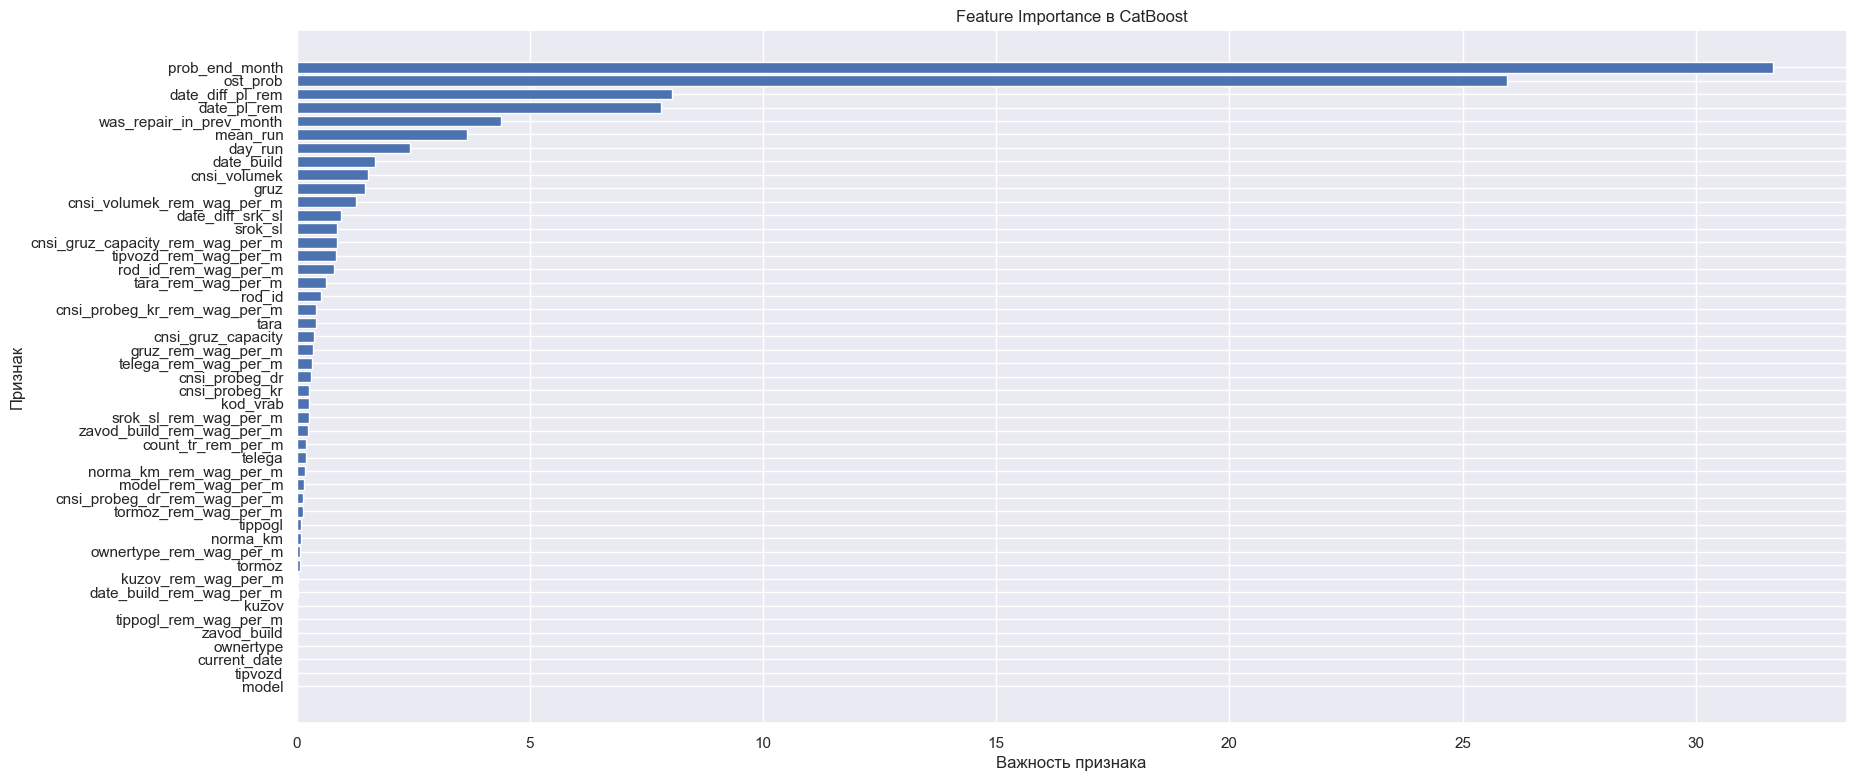

In [602]:
# Строим график важности признаков
plt.barh(range(len(sorted_feature_importances)), sorted_feature_importances, align='center')
plt.yticks(range(len(sorted_feature_importances)), sorted_feature_names)
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.title('Feature Importance в CatBoost')
plt.show()

## CM

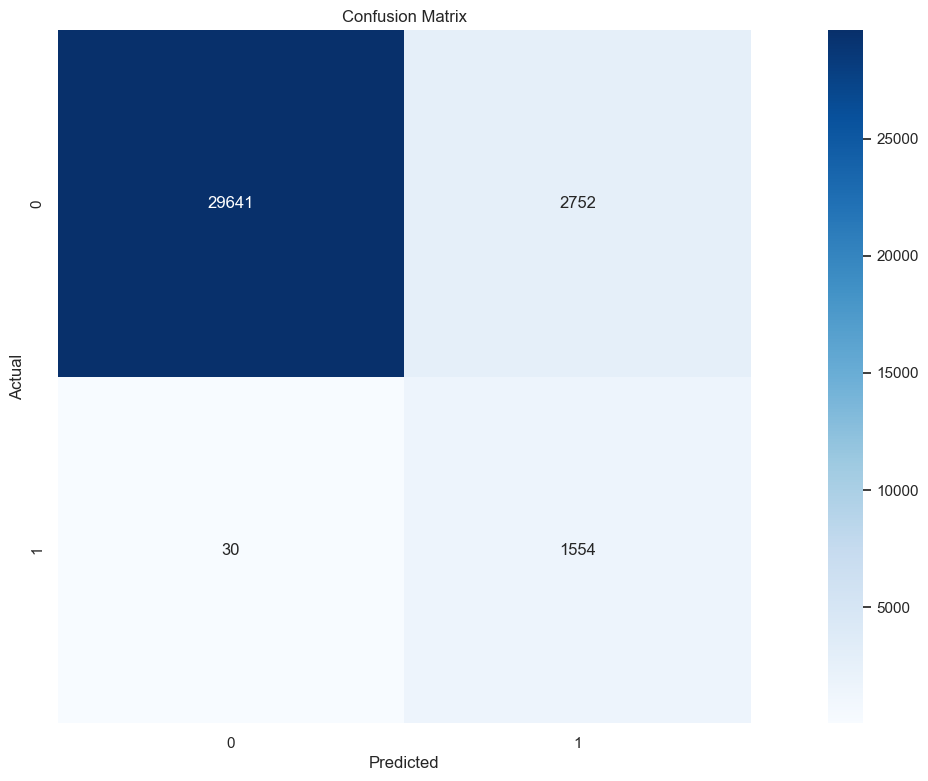

In [603]:
# Создание матрицы ошибок
confusion = confusion_matrix(y_train, y_pred_tr)

# Визуализация матрицы ошибок с использованием библиотеки Seaborn
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", square=True, xticklabels=True, yticklabels=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Threshold

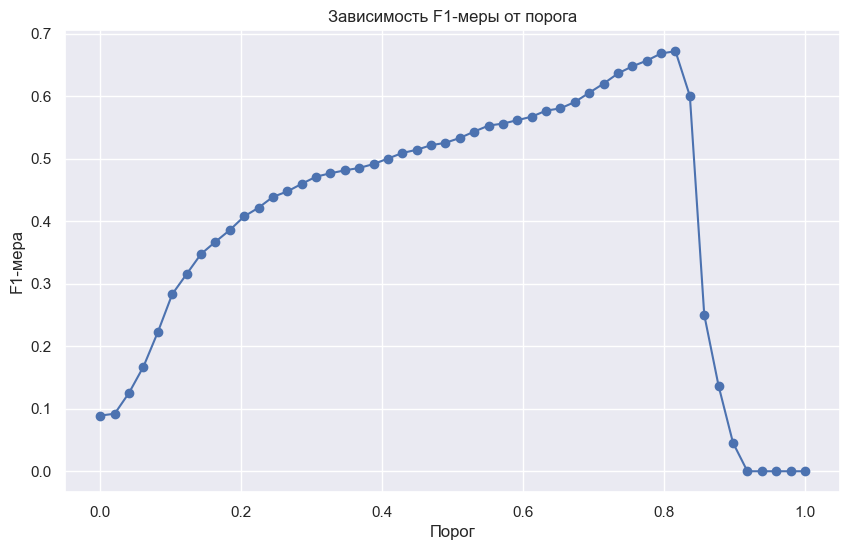

Лучший порог: 0.8163265306122448


In [604]:
y_pred1 = clf_new.predict_proba(X_train)[:, 1]
y_true = y_train

thresholds = np.linspace(0, 1, 50)  # Здесь используется 100 равномерно распределенных порогов от 0 до 1

f1_scores = []
threshold_values = []

# Перебор порогов
for threshold in thresholds:
    y_pred_binary_plot = (y_pred1 > threshold).astype(int)
    f1 = f1_score(y_true, y_pred_binary_plot)
    f1_scores.append(f1)
    threshold_values.append(threshold)

plt.plot(threshold_values, f1_scores, marker='o', linestyle='-')
plt.xlabel('Порог')
plt.ylabel('F1-мера')
plt.title('Зависимость F1-меры от порога')
plt.grid(True)
plt.show()

# Подсчет лучшего порога

best_threshold_index = np.argmax(f1_scores)
best_threshold = threshold_values[best_threshold_index]

print(f"Лучший порог: {best_threshold}")

In [605]:
y_pred_tr1 = clf_new.predict_proba(X_train)[:, 1]  # Получение вероятностей положительного класса
y_pred_binary_tr1 = (y_pred_tr1 > best_threshold).astype(int)  # Бинарные предсказания
f1 = f1_score(y_pred_binary_tr1, y_train)
f1

0.6721529068224049

## Тестим

In [606]:
cross_val_score(clf_new, X_test, y_test, scoring = 'f1', cv=5).mean()

NameError: name 'X_test' is not defined

``f1 = 0.44``

In [ ]:
y_pred1 = clf_new.predict_proba(X_test)[:, 1]
y_true = y_test

thresholds = np.linspace(0, 1, 50)  # Здесь используется 100 равномерно распределенных порогов от 0 до 1

f1_scores = []
threshold_values = []

# Перебор порогов
for threshold in thresholds:
    y_pred_binary_plot = (y_pred1 > threshold).astype(int)
    f1 = f1_score(y_true, y_pred_binary_plot)
    f1_scores.append(f1)
    threshold_values.append(threshold)

# Постройте график
plt.figure(figsize=(10, 6))
plt.plot(threshold_values, f1_scores, marker='o', linestyle='-')
plt.xlabel('Порог')
plt.ylabel('F1-мера')
plt.title('Зависимость F1-меры от порога')
plt.grid(True)
plt.show()

# Подсчет лучшего порога

best_threshold_index = np.argmax(f1_scores)
best_threshold = threshold_values[best_threshold_index]

print(f"Лучший порог: {best_threshold}")

In [ ]:
y_pred_tr1 = clf_new.predict_proba(X_test)[:, 1]  # Получение вероятностей положительного класса
y_pred_binary_tr1 = (y_pred_tr1 > best_threshold).astype(int)  # Бинарные предсказания
f1 = f1_score(y_pred_binary_tr1, y_test)
f1

# Модель тестовая для target_month с фильтром не были в прошлым месяце в ПР

## Обучение

In [607]:
X_train_filt = X_train.query('was_repair_in_prev_month != 1')

In [608]:
y_train_filt = y_train[X_train_filt.index]

In [609]:
X_train_filt.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32183 entries, 0 to 33976
Data columns (total 47 columns):
 #   Column                            Non-Null Count  Dtype          
---  ------                            --------------  -----          
 0   model                             32183 non-null  string         
 1   rod_id                            32183 non-null  Int64          
 2   gruz                              32183 non-null  Int64          
 3   cnsi_gruz_capacity                32183 non-null  Int64          
 4   cnsi_volumek                      32183 non-null  Float64        
 5   tara                              32183 non-null  Int64          
 6   date_build                        32183 non-null  datetime64[ns] 
 7   srok_sl                           32183 non-null  datetime64[ns] 
 8   zavod_build                       32183 non-null  Int64          
 9   cnsi_probeg_dr                    32183 non-null  Int64          
 10  cnsi_probeg_kr                    32183

In [610]:
y_train_filt.info()

<class 'pandas.core.series.Series'>
Index: 32183 entries, 0 to 33976
Series name: target_month
Non-Null Count  Dtype
--------------  -----
32183 non-null  Int64
dtypes: Int64(1)
memory usage: 565.7 KB


In [701]:
clf_new_filt = CatBoostClassifier(iterations=100, depth=6, learning_rate=0.01, loss_function='Logloss', auto_class_weights='SqrtBalanced', cat_features=cols_cat_n_list, verbose=False)

In [702]:
clf_new_filt.fit(X_train_filt, y_train_filt);

In [703]:
cross_val_score(clf_new_filt, X_train_filt, y_train_filt, scoring = 'f1', cv=5).mean()

0.5981886312275753

``f1 = 0.598`` - SqrtBalanced
```f1 = 0.458``` - Balanced

## TH

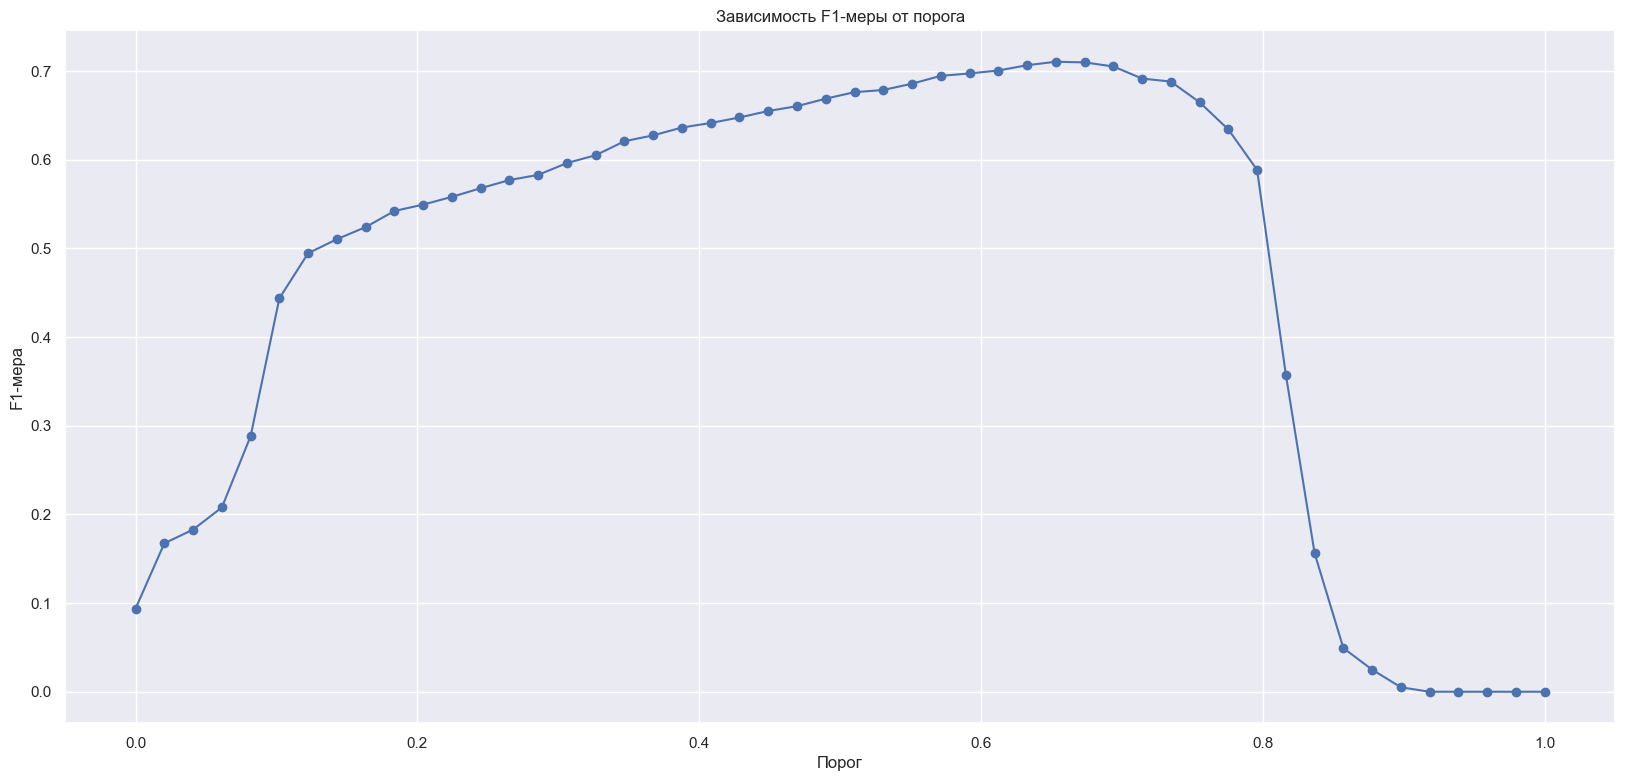

Лучший порог: 0.6530612244897959


In [704]:
y_pred1 = clf_new_filt.predict_proba(X_train_filt)[:, 1]
y_true = y_train_filt

thresholds = np.linspace(0, 1, 50)  # Здесь используется 100 равномерно распределенных порогов от 0 до 1

f1_scores = []
threshold_values = []

# Перебор порогов
for threshold in thresholds:
    y_pred_binary_plot = (y_pred1 > threshold).astype(int)
    f1 = f1_score(y_true, y_pred_binary_plot)
    f1_scores.append(f1)
    threshold_values.append(threshold)

plt.plot(threshold_values, f1_scores, marker='o', linestyle='-')
plt.xlabel('Порог')
plt.ylabel('F1-мера')
plt.title('Зависимость F1-меры от порога')
plt.grid(True)
plt.show()

# Подсчет лучшего порога

best_threshold_index = np.argmax(f1_scores)
best_threshold_m = threshold_values[best_threshold_index]

print(f"Лучший порог: {best_threshold_m}")

In [705]:
best_threshold_m = 0.6530612244897959

In [706]:
y_pred_tr1 = clf_new_filt.predict_proba(X_train_filt)[:, 1]  # Получение вероятностей положительного класса
y_pred_binary_tr1 = (y_pred_tr1 > best_threshold_m).astype(int)  # Бинарные предсказания
f1 = f1_score(y_pred_binary_tr1, y_train_filt)
f1

0.7103759398496241

In [742]:
# Вычисление точности
precision = precision_score(y_train_filt, y_pred_binary_tr1)

# Вычисление полноты
recall = recall_score(y_train_filt, y_pred_binary_tr1)

print("Точность: {:.2f}".format(precision))
print("Полнота: {:.2f}".format(recall))

Точность: 0.68
Полнота: 0.75


In [707]:
sum(y_pred_binary_tr1)

1741

In [708]:
len(y_pred_binary_tr1)

32183

In [709]:
df_pred_binary =\
pd.DataFrame(y_pred_binary_tr1, columns=['pred'], index=y_train_filt.index)

In [710]:
df_pred_binary.head()

pred
wagnum      
0          0
1          0
2          0
3          0
4          0

In [711]:
df_pred_binary.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32183 entries, 0 to 33976
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   pred    32183 non-null  int32
dtypes: int32(1)
memory usage: 408.6 KB


In [712]:
df_pred_binary['pred'].value_counts()

0    30442
1     1741
Name: pred, dtype: int64

## Важность признаков

In [628]:
feature_importance = clf_new_filt.get_feature_importance(data=None, type='FeatureImportance')

In [629]:
# Сортируем важность признаков
sorted_idx = feature_importance.argsort()
sorted_feature_importances = feature_importance[sorted_idx]
sorted_feature_names = X_train.columns[sorted_idx]

In [630]:
feature_importance = clf_new_filt.get_feature_importance(data=None, type='FeatureImportance')

# Создание списка фичей и их важностей
feature_names = clf_new_filt.feature_names_
feature_importance_list = list(zip(feature_names, feature_importance))

# Сортировка по важности в убывающем порядке
feature_importance_list.sort(key=lambda x: x[1], reverse=True)

cool_feat = []
for feature, importance in feature_importance_list:
    if importance > 0:
        cool_feat.append(feature)

In [631]:
cool_feat

['ost_prob',
 'prob_end_month',
 'date_pl_rem',
 'mean_run',
 'date_diff_pl_rem',
 'cnsi_volumek',
 'cnsi_gruz_capacity_rem_wag_per_m',
 'date_build',
 'date_diff_srk_sl',
 'cnsi_volumek_rem_wag_per_m',
 'day_run',
 'srok_sl',
 'tara_rem_wag_per_m',
 'gruz',
 'tara',
 'norma_km_rem_wag_per_m',
 'gruz_rem_wag_per_m',
 'srok_sl_rem_wag_per_m',
 'model_rem_wag_per_m',
 'zavod_build_rem_wag_per_m',
 'rod_id_rem_wag_per_m',
 'telega_rem_wag_per_m',
 'cnsi_gruz_capacity',
 'kuzov_rem_wag_per_m',
 'cnsi_probeg_kr',
 'tipvozd_rem_wag_per_m',
 'tippogl',
 'tormoz',
 'tormoz_rem_wag_per_m',
 'telega',
 'count_tr_rem_per_m',
 'zavod_build',
 'rod_id',
 'norma_km',
 'ownertype_rem_wag_per_m',
 'tippogl_rem_wag_per_m',
 'date_build_rem_wag_per_m',
 'ownertype',
 'kod_vrab',
 'cnsi_probeg_dr_rem_wag_per_m',
 'kuzov']

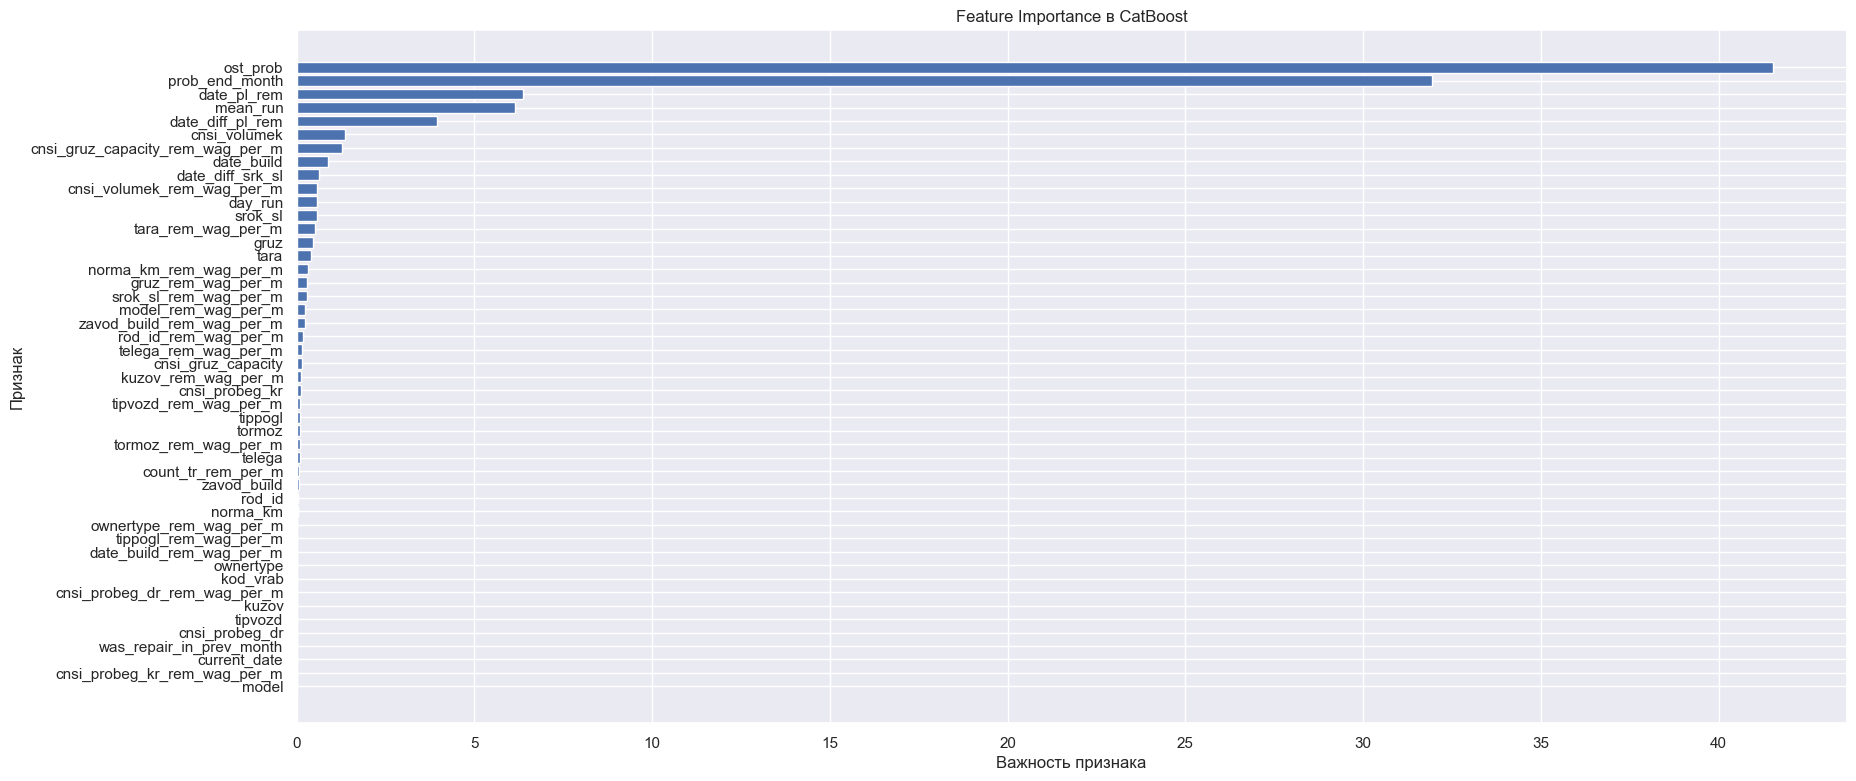

In [632]:
# Строим график важности признаков
plt.barh(range(len(sorted_feature_importances)), sorted_feature_importances, align='center')
plt.yticks(range(len(sorted_feature_importances)), sorted_feature_names)
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.title('Feature Importance в CatBoost')
plt.show()

## Только важные признаки

In [ ]:
X_train_filt_cool = X_train_filt[cool_feat]

In [ ]:
X_train_filt_cool

In [ ]:
clf_new_filt_cool = CatBoostClassifier(iterations=100, depth=6, learning_rate=0.1, loss_function='Logloss', auto_class_weights='SqrtBalanced', verbose=False)

In [ ]:
clf_new_filt_cool.fit(X_train_filt_cool, y_train_filt)

In [ ]:
cross_val_score(clf_new_filt_cool, X_train_filt_cool, y_train_filt, scoring = 'f1', cv=5).mean()

# Модель тестовая для target_day с фильтром не были в прошлым месяце в ПР

## Создаем данные

In [713]:
df_pred_binary_filt =\
df_pred_binary.query('pred == 1')

In [714]:
df_pred_binary_filt.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1741 entries, 91 to 33968
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   pred    1741 non-null   int32
dtypes: int32(1)
memory usage: 22.1 KB


In [715]:
df_pred_binary_filt.head()

pred
wagnum      
91         1
138        1
163        1
180        1
200        1

In [716]:
X_train_filt_day = X_train_filt[X_train_filt.index.isin(df_pred_binary_filt.index)]

In [717]:
X_train_filt_day.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1741 entries, 91 to 33968
Data columns (total 47 columns):
 #   Column                            Non-Null Count  Dtype          
---  ------                            --------------  -----          
 0   model                             1741 non-null   string         
 1   rod_id                            1741 non-null   Int64          
 2   gruz                              1741 non-null   Int64          
 3   cnsi_gruz_capacity                1741 non-null   Int64          
 4   cnsi_volumek                      1741 non-null   Float64        
 5   tara                              1741 non-null   Int64          
 6   date_build                        1741 non-null   datetime64[ns] 
 7   srok_sl                           1741 non-null   datetime64[ns] 
 8   zavod_build                       1741 non-null   Int64          
 9   cnsi_probeg_dr                    1741 non-null   Int64          
 10  cnsi_probeg_kr                    1741 

In [718]:
target_day = target[target.month == '2022-12-01'][['wagnum', 'target_day']]

In [719]:
target_day.set_index('wagnum', inplace=True)

In [720]:
target_day.head()

target_day
wagnum            
33361            0
33364            1
33366            1
33358            0
33349            0

In [721]:
y_train_filt_day = target_day[target_day.index.isin(df_pred_binary_filt.index)]

In [722]:
y_train_filt_day

target_day
wagnum            
33364            1
33366            1
29890            0
29906            0
29933            1
...            ...
29880            0
29909            1
33468            0
13802            1
33350            0

[1741 rows x 1 columns]

In [723]:
y_train_filt_day.value_counts()

target_day
0             1235
1              506
dtype: int64

## Обучаем

In [732]:
scale_pos_weight = len(y_train_filt_day[y_train_filt_day == 0]) / len(y_train_filt_day[y_train_filt_day == 1])

In [733]:
scale_pos_weight

1.0

In [737]:
clf_new_filt_day = CatBoostClassifier(iterations=100, depth=6, learning_rate=0.01, auto_class_weights='Balanced', loss_function='Logloss', cat_features=cols_cat_n_list, verbose=False)

In [738]:
clf_new_filt_day.fit(X_train_filt_day, y_train_filt_day);

In [739]:
cross_val_score(clf_new_filt_day, X_train_filt_day, y_train_filt_day, scoring = 'f1', cv=5, verbose=False).mean()

0.19508731063909016

``f1 = 0.195`` - Balanced
``f1 = 0.015`` - SqrtBalanced
``f1 = 0`` - scale_pos_weight

In [744]:
pred_filt_day =\
clf_new_filt_day.predict(X_train_filt_day)

In [745]:
sum(pred_filt_day)

633

## TH

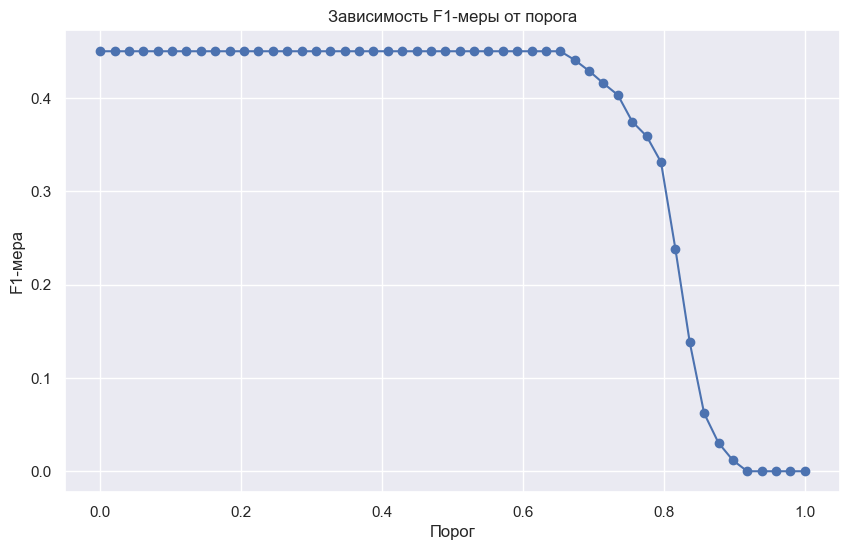

Лучший порог: 0.0


In [746]:
y_pred1 = clf_new_filt.predict_proba(X_train_filt_day)[:, 1]
y_true = y_train_filt_day

thresholds = np.linspace(0, 1, 50)  # Здесь используется 100 равномерно распределенных порогов от 0 до 1

f1_scores = []
threshold_values = []

# Перебор порогов
for threshold in thresholds:
    y_pred_binary_plot = (y_pred1 > threshold).astype(int)
    f1 = f1_score(y_true, y_pred_binary_plot)
    f1_scores.append(f1)
    threshold_values.append(threshold)

# Постройте график
plt.figure(figsize=(10, 6))
plt.plot(threshold_values, f1_scores, marker='o', linestyle='-')
plt.xlabel('Порог')
plt.ylabel('F1-мера')
plt.title('Зависимость F1-меры от порога')
plt.grid(True)
plt.show()

# Подсчет лучшего порога

best_threshold_index = np.argmax(f1_scores)
best_threshold = threshold_values[best_threshold_index]

print(f"Лучший порог: {best_threshold}")

In [796]:
best_threshold_day = 0.71

In [797]:
y_pred_tr1 = clf_new_filt.predict_proba(X_train_filt_day)[:, 1]  # Получение вероятностей положительного класса
y_pred_binary_tr1 = (y_pred_tr1 > best_threshold_day).astype(int)  # Бинарные предсказания
f1 = f1_score(y_pred_binary_tr1, y_train_filt_day)
f1

0.41715817694369967

In [798]:
y_pred_tr1

array([0.78708933, 0.78548701, 0.81782512, ..., 0.74287974, 0.81535424,
       0.65400879])

In [799]:
len(y_pred_binary_tr1)

1741

In [800]:
sum(y_pred_binary_tr1)

1359

In [801]:
df_pred_binary_day =\
pd.DataFrame(y_pred_binary_tr1, columns=['pred'], index=y_train_filt_day.index)

In [802]:
df_pred_binary_day.sum()

pred    1359
dtype: int64

In [803]:
df_pred_binary_day.count()

pred    1741
dtype: int64

In [804]:
df_pred_binary_day['pred'].value_counts()

1    1359
0     382
Name: pred, dtype: int64

# Оценка f1 тестовых моделей для target_month / target_day

## True

In [805]:
target_check_true = target[target.month == '2022-12-01'][['wagnum', 'target_month', 'target_day']]

In [806]:
target_check_true.set_index('wagnum', inplace=True)

In [807]:
target_check_true.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33977 entries, 33361 to 33350
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   target_month  33977 non-null  Int64
 1   target_day    33977 non-null  Int64
dtypes: Int64(2)
memory usage: 895.9 KB


In [808]:
target_check_true.head()

target_month  target_day
wagnum                          
33361              0           0
33364              1           1
33366              1           1
33358              0           0
33349              0           0

In [809]:
# target_check_true.to_csv('test_1_true.csv')

## Pred

In [810]:
target_check_pred = target[target.month == '2022-12-01'][['wagnum']]

In [811]:
target_check_pred.set_index('wagnum', inplace=True)

In [812]:
target_check_pred =\
target_check_pred.join(df_pred_binary, how='left')

In [813]:
target_check_pred.rename(columns={'pred': 'target_month'}, inplace=True)

In [814]:
target_check_pred.head()

target_month
wagnum              
33361            NaN
33364            1.0
33366            1.0
33358            0.0
33349            0.0

In [815]:
target_check_pred =\
target_check_pred.join(df_pred_binary_day, how='left')

In [816]:
target_check_pred.rename(columns={'pred': 'target_day'}, inplace=True)

In [817]:
target_check_pred.fillna(0, inplace=True)

In [818]:
target_check_pred[['target_month', 'target_day']] = target_check_pred[['target_month', 'target_day']].astype(int)

In [819]:
target_check_pred.head()

target_month  target_day
wagnum                          
33361              0           0
33364              1           1
33366              1           1
33358              0           0
33349              0           0

In [820]:
target_check_pred['target_month'].sum(), target_check_pred['target_day'].sum()

(1741, 1359)

In [821]:
# target_check_pred.to_csv('test_1_pred.csv')

In [822]:
def calc_f1_score(true_labels, pred_labels) -> float:
    # Таргет для месячного прогноза
    true_labels_month = true_labels['target_month'].values
    pred_labels_month = pred_labels['target_month'].values

    # Таргет для 10 дневного прогноза
    true_labels_day = true_labels['target_day'].values
    pred_labels_day = pred_labels['target_day'].values

    # Посчитаем метрику для месяца и 10 дней
    score_month = f1_score(true_labels_month, pred_labels_month)
    score_day = f1_score(true_labels_day, pred_labels_day)
    # Посчитаем метрику с весом для двух таргетов
    score = 0.5 * score_month + 0.5 * score_day
    return score

In [823]:
# оценим насколько хорошо удалось предсказать выбытие вагонов  по месяцу и по 10 дням
calc_f1_score(target_check_true, target_check_pred)

0.5568468605417121

# Датасет v2. Объединение файлов

In [824]:
path_train_v2 = './train/test'

In [825]:
# данные по дислокации
dislok_clear_v2 = pd.read_parquet(path_train_v2 + '/dislok_wagons.parquet').convert_dtypes()
# список вагонов с остаточным пробегом на момент прогноза
wag_prob_clear_v2 = pd.read_parquet(path_train_v2 + '/wagons_probeg_ownersip.parquet').convert_dtypes()
 # параметры вагона
wag_param_clear_v2 = pd.read_parquet(path_train_v2 + '/wag_params.parquet').convert_dtypes()
# таргет по прогноза выбытия вагонов в ПР на месяц и на 10 дней
target_clear_v2 = pd.read_csv(path_train +'/target/y_predict.csv').convert_dtypes()
# текущие ремонты вагонов
tr_rem_clear_v2 = pd.read_parquet(path_train_v2 + '/tr_rems.parquet').convert_dtypes()
# данные по текущим ремонтам
pr_rem_clear_v2 = pd.read_parquet(path_train_v2 + '/pr_rems.parquet').convert_dtypes()

In [826]:
dislok_clear_all = pd.concat([dislok_clear, dislok_clear_v2])
wag_prob_clear_all = pd.concat([wag_prob_clear, wag_prob_clear_v2])
tr_rem_clear_all = pd.concat([tr_rem_clear, tr_rem_clear_v2])
pr_rem_clear_all = pd.concat([pr_rem_clear, pr_rem_clear_v2])

In [827]:
target_clear_v2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33707 entries, 0 to 33706
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   wagnum  33707 non-null  Int64 
 1   month   33707 non-null  string
dtypes: Int64(1), string(1)
memory usage: 559.7 KB


### Значения дат срезов

In [828]:
wag_prob_clear_v2['repdate'].unique()

array(['2023-02-01T00:00:00.000000000', '2023-02-02T00:00:00.000000000',
       '2023-02-03T00:00:00.000000000', '2023-02-04T00:00:00.000000000',
       '2023-02-05T00:00:00.000000000', '2023-02-06T00:00:00.000000000',
       '2023-02-07T00:00:00.000000000', '2023-02-08T00:00:00.000000000',
       '2023-02-09T00:00:00.000000000', '2023-02-10T00:00:00.000000000',
       '2023-02-11T00:00:00.000000000', '2023-02-12T00:00:00.000000000',
       '2023-02-13T00:00:00.000000000', '2023-02-14T00:00:00.000000000',
       '2023-02-15T00:00:00.000000000', '2023-02-16T00:00:00.000000000',
       '2023-02-17T00:00:00.000000000', '2023-02-18T00:00:00.000000000',
       '2023-02-19T00:00:00.000000000', '2023-02-20T00:00:00.000000000',
       '2023-02-21T00:00:00.000000000', '2023-02-22T00:00:00.000000000',
       '2023-02-23T00:00:00.000000000', '2023-02-24T00:00:00.000000000',
       '2023-02-25T00:00:00.000000000', '2023-02-26T00:00:00.000000000',
       '2023-02-27T00:00:00.000000000', '2023-02-28

In [829]:
wag_prob_clear_all['repdate'].unique()

array(['2022-08-01T00:00:00.000000000', '2022-08-02T00:00:00.000000000',
       '2022-08-03T00:00:00.000000000', '2022-08-04T00:00:00.000000000',
       '2022-08-05T00:00:00.000000000', '2022-08-06T00:00:00.000000000',
       '2022-08-07T00:00:00.000000000', '2022-08-08T00:00:00.000000000',
       '2022-08-09T00:00:00.000000000', '2022-08-10T00:00:00.000000000',
       '2022-08-11T00:00:00.000000000', '2022-08-12T00:00:00.000000000',
       '2022-08-13T00:00:00.000000000', '2022-08-14T00:00:00.000000000',
       '2022-08-15T00:00:00.000000000', '2022-08-16T00:00:00.000000000',
       '2022-08-17T00:00:00.000000000', '2022-08-18T00:00:00.000000000',
       '2022-08-19T00:00:00.000000000', '2022-08-20T00:00:00.000000000',
       '2022-08-21T00:00:00.000000000', '2022-08-22T00:00:00.000000000',
       '2022-08-23T00:00:00.000000000', '2022-08-24T00:00:00.000000000',
       '2022-08-25T00:00:00.000000000', '2022-08-26T00:00:00.000000000',
       '2022-08-27T00:00:00.000000000', '2022-08-28

# Проверяем тестовую модель ver. 1 на тестовых данных (март)

## Функция для создания данных

In [830]:
def make_wp_test(wag_param, wag_prob, pr_rem, tr_rem, dislok, target, month_to_predict='2023-01-01', month_prev=12, info=False):
    '''
    Передаём: параметры вагона, пробег вагона, плановые ремонты, дислокацию, таргет
    дату отчёта на которую предиктим (по умолчанию 2023-01-01), 
    предыдущий месяц от даты отчёта (по умолчанию 12)
    , информация о датасетах
    
    Возвращает: сэмпл фичей для обработки, target
    '''
    
    # Достаём ТАРГЕТ для нужной даты month_to_predict
    target.month = pd.to_datetime(target.month)
    
    target = target[target.month == month_to_predict]
    print('target', target['month'].unique())
    target = target[['wagnum','month']]
    
    
    print('\nДостаём данные')
    # Достаём ПРОБЕГ для нужной даты month_to_predict
    wag_prob = wag_prob[(wag_prob.repdate == wag_prob.repdate.max()) | (wag_prob.repdate == wag_prob.repdate.min())]
    
    print('\nwag_prob', wag_prob['repdate'].unique())
    
    # Оценим среднесуточный пробег из данных по пробегу вагона, на тот случай, если данных по нормативу нет
    wag_prob_ = wag_prob.groupby('wagnum', as_index = False).agg({'repdate':['max', 'min'] , 'ost_prob': ['max','min']},)#.droplevel(1)
    wag_prob_.columns = [head+'_' + name
                         if head!='wagnum'
                         else head
                         for head, name in wag_prob_.columns ]

    wag_prob_['diff_days'] = wag_prob_.repdate_max - wag_prob_.repdate_min
    wag_prob_['mean_run'] = (wag_prob_.ost_prob_max - wag_prob_.ost_prob_min )/ wag_prob_.diff_days.dt.days
    wag_prob = wag_prob[wag_prob.repdate == wag_prob.repdate.max()][['wagnum','ost_prob']]
    wag_prob = wag_prob.merge(wag_prob_[['wagnum','mean_run']])
    
    print('\nwag_param')
    # Достаём ПАРАМЕТРЫ вагона для нужной даты month_to_predict. У вагонов могут меняться параметры, поэтмоу номер дублируется
    wag_param = wag_param.drop_duplicates(subset='wagnum', keep='last')
    # wag_param = wag_param[['wagnum','srok_sl','cnsi_probeg_dr','cnsi_probeg_kr']]
    wag_param = all_rems_for_wagon(tr_rem, wag_param, month_to_predict, True)
    wag_param = wag_param.drop(columns=['date_iskl'])
    # print(wag_param)
    
    
    # Достаём данные по ПЛАНОВЫМ ремонтам за прошедший месяц
    pr_rem = pr_rem[pr_rem['month'] == month_prev].copy()
    
    print('\npr_rem', pr_rem['month'].unique()[0])
    
    # добавим признак, что вагон был в ПР в предыдущем месяце. Скорее всего, если вагон был в ПР недавно, то повторно он не поедет
    pr_rem['was_repair_in_prev_month'] = 1
    # print(pr_rem)
    # pr_rem = pr_rem[['wagnum','was_repair_in_prev_month']]
    pr_rem = pr_rem.drop_duplicates(subset='wagnum') #некоторые вагоны все же ремонтируются больше 1 раза, поэтому нужен сбросить дубли
    print(pr_rem[['rem_month']])
    pr_rem = pr_rem[['wagnum', 'was_repair_in_prev_month']]
    
    # Достаём данные по ТЕКУЩИМ ремонтам за прошедший месяц
    tr_rem = tr_rem[tr_rem['rem_month'].dt.month == month_prev]
    
    print('tr_rem', tr_rem['rem_month'].dt.month.unique()[0])
    
    tr_rem = tr_rem.groupby('wagnum', as_index= False).kod_vrab.count()
    
    
    # Достаём данные по ДИСЛОКАЦИИ для нужной даты month_to_predict
    dislok = dislok[dislok['plan_date'] <= month_to_predict] \
    .drop_duplicates(subset = 'wagnum', keep='last')
    print('\ndislok', dislok['plan_date'].unique())
    
    # Показать инфо
    if info:
        print('\n', wag_prob.info())
        print('\n', wag_param.info())
        print('\n', pr_rem.info())
        print('\n', tr_rem.info())
        print('\n', dislok.info())
    
    print('\nДелаем фичи')
    # Создаём фичи
    wp = target[['wagnum']].merge(wag_param, on ='wagnum', how = 'left')\
    .merge(wag_prob, how = 'left')\
    .merge(pr_rem, how = 'left')\
    .merge(tr_rem, how = 'left')\
    .merge(dislok[['wagnum','date_pl_rem']], how = 'left')
    

    print('\nЗаполняме пропуски')
    numeric_columns = wp.select_dtypes(include=['int', 'float'])
    # Заменим отсутствующие значения на нули
    wp[numeric_columns.columns] = numeric_columns.fillna(0)
    
    return wp, target

In [842]:
def make_features_wp_test(wp, month_to_predict, month=True):
    '''
     Передаём: сэмпл фичей, target
     таргет за месяц (по умолчанию) или месяц + 10 дней
     
     Возрашает: фичи
    '''
    
    print('Считаем среднедневный пробег')
    # Считаем среднедневный пробег
    # wp[['cnsi_probeg_dr','cnsi_probeg_kr','mean_run', 'was_repair_in_prev_month', 'kod_vrab']] =\
    # wp[['cnsi_probeg_dr','cnsi_probeg_kr','mean_run', 'was_repair_in_prev_month', 'kod_vrab']].fillna(0)
    wp['day_run'] = wp.apply(lambda x : [ val  for val in [x.cnsi_probeg_kr, x.cnsi_probeg_dr, x.mean_run] if val != 0], axis = 1 )
    wp['day_run']= wp.apply(lambda x : np.mean(x.day_run) if len(x.day_run)> 0 else 0, axis = 1 )

    wp['current_date'] = pd.to_datetime(month_to_predict)
    # Дней до окончания срока службы на month_to_predict
    wp['date_diff_srk_sl'] = wp['srok_sl']- wp['current_date']
    # Дней до планового ремонта на month_to_predict
    wp['date_diff_pl_rem'] = wp['date_pl_rem']- wp['current_date']
    # Остаточный пробег на конец месяца
    wp['prob_end_month'] = wp['ost_prob'] - wp['day_run']* 30
    
    # print('Заполняме пропуски')
    # numeric_columns = wp.select_dtypes(include=['int', 'float'])
    # # Заменим отсутствующие значения на нули
    # wp[numeric_columns.columns] = numeric_columns.fillna(0)
    
    print('Сортируем номега вагонов')
    # Фичи
    X = wp.set_index('wagnum').sort_index()
        
    return X

## Тестовый датасет февраль

In [832]:
# %%time
wp_test_real, target_test_real = make_wp_test(wag_param_clear_v2, wag_prob_clear_all, pr_rem_clear_all, tr_rem_clear_all, dislok_clear_all, target_clear_v2, '2023-03-01', 2)

target ['2023-03-01T00:00:00.000000000']

Достаём данные

wag_prob ['2022-08-01T00:00:00.000000000' '2023-02-28T00:00:00.000000000']

wag_param

Месяца count_rems_per_month_one_wag [ 8  9 10 11 12  1  2] 

Месяца [ 8  9 10 11 12  1  2]
Месяца [ 8  9 10 11 12  1  2]
Месяца [ 8  9 10 11 12  1  2]
Месяца [ 8  9 10 11 12  1  2]
Месяца [ 8  9 10 11 12  1  2]
Месяца [ 8  9 10 11 12  1  2]
Месяца [ 8  9 10 11 12  1  2]
Месяца [ 8  9 10 11 12  1  2]
Месяца [ 8  9 10 11 12  1  2]
Месяца [ 8  9 10 11 12  1  2]
Месяца [ 8  9 10 11 12  1  2]
Месяца [ 8  9 10 11 12  1  2]
Месяца [ 8  9 10 11 12  1  2]
Месяца [ 8  9 10 11 12  1  2]
Месяца [ 8  9 10 11 12  1  2]
Месяца [ 8  9 10 11 12  1  2]
Месяца [ 8  9 10 11 12  1  2]
Месяца [ 8  9 10 11 12  1  2]

pr_rem 2
      rem_month
0    2023-02-03
2    2023-02-10
3    2023-02-16
4    2023-02-16
5    2023-02-21
...         ...
1883 2023-02-28
1884 2023-02-28
1890 2023-02-24
1895 2023-02-02
1896 2023-02-21

[1589 rows x 1 columns]
tr_rem 2

dislok ['2022-12-

In [833]:
wp_test_real.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33707 entries, 0 to 33706
Data columns (total 43 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   wagnum                            33707 non-null  Int64         
 1   model                             33707 non-null  string        
 2   rod_id                            33707 non-null  Int64         
 3   gruz                              33707 non-null  Int64         
 4   cnsi_gruz_capacity                33707 non-null  Int64         
 5   cnsi_volumek                      33707 non-null  Float64       
 6   tara                              33707 non-null  Int64         
 7   date_build                        33707 non-null  datetime64[ns]
 8   srok_sl                           33707 non-null  datetime64[ns]
 9   zavod_build                       33707 non-null  Int64         
 10  cnsi_probeg_dr                    33707 non-nu

In [834]:
wp_test_real.head()

wagnum       model  rod_id  gruz  cnsi_gruz_capacity  cnsi_volumek  tara  \
0   33361  12-1303-01       1   690                 690          88.0   245   
1   33364  12-1303-01       1   690                 690          88.0   245   
2   33366  12-1303-01       1   690                 690          88.0   245   
3   33358  12-1303-01       1   690                 690          88.0   245   
4   33349  12-1303-01       1   690                 690          88.0   245   

  date_build    srok_sl  zavod_build  cnsi_probeg_dr  cnsi_probeg_kr  kuzov  \
0 2011-02-08 2033-03-01            6             110             160      2   
1 2010-04-21 2031-04-12            6             110             160      2   
2 2010-06-23 2032-01-21            6             110             160      2   
3 2012-09-27 2032-11-30            6             110             160      2   
4 2011-11-20 2033-12-04            6             110             160      2   

   telega  tormoz tipvozd  tippogl  norma_km  ownertype  count_tr_rem_per_m  \
0       2       2       3       11    160000          0                 1.5   
1       2       2       3       11    160000          0                 2.0   
2       2       2       3       11    160000          0                 2.0   
3       2       2       3       11    160000          0                 2.0   
4       2       2       6       11    160000          0                 0.0   

   model_rem_wag_per_m  rod_id_rem_wag_per_m  gruz_rem_wag_per_m  \
0             1.941624              1.995803             1.98119   
1             1.941624              1.995803             1.98119   
2             1.941624              1.995803             1.98119   
3             1.941624              1.995803             1.98119   
4             1.941624              1.995803             1.98119   

   cnsi_gruz_capacity_rem_wag_per_m  cnsi_volumek_rem_wag_per_m  \
0                           1.98119                     1.98069   
1                           1.98119                     1.98069   
2                           1.98119                     1.98069   
3                           1.98119                     1.98069   
4                           1.98119                     1.98069   

   tara_rem_wag_per_m  date_build_rem_wag_per_m  srok_sl_rem_wag_per_m  \
0            1.943016                  2.083333               1.916667   
1            1.943016                  2.000000               2.500000   
2            1.943016                  2.000000               2.000000   
3            1.943016                  2.250000               2.250000   
4            1.943016                  2.200000               1.694444   

   zavod_build_rem_wag_per_m  cnsi_probeg_dr_rem_wag_per_m  \
0                   1.984252                      1.962495   
1                   1.984252                      1.962495   
2                   1.984252                      1.962495   
3                   1.984252                      1.962495   
4                   1.984252                      1.962495   

   cnsi_probeg_kr_rem_wag_per_m  kuzov_rem_wag_per_m  telega_rem_wag_per_m  \
0                      1.971315             1.969246                1.9861   
1                      1.971315             1.969246                1.9861   
2                      1.971315             1.969246                1.9861   
3                      1.971315             1.969246                1.9861   
4                      1.971315             1.969246                1.9861   

   tormoz_rem_wag_per_m  tipvozd_rem_wag_per_m  tippogl_rem_wag_per_m  \
0              1.960699               1.936906               1.976244   
1              1.960699               1.936906               1.976244   
2              1.960699               1.936906               1.976244   
3              1.960699               1.936906               1.976244   
4              1.960699               1.988983               1.976244   

   norma_km_rem_wag_per_m  ownertype_rem

In [835]:
wp_test_real['mean_run'].value_counts()

0.0           1712
138.454976       6
145.227488       6
161.251185       6
156.49763        6
              ... 
566.312796       1
84.772512        1
173.080569       1
127.2891         1
<NA>             1
Name: mean_run, Length: 25957, dtype: Int64

In [836]:
wp_test_real['was_repair_in_prev_month'].value_counts()

0.0    32118
1.0     1589
Name: was_repair_in_prev_month, dtype: int64

In [837]:
wp_test_real['kod_vrab'].value_counts()

0.0    29785
2.0     2989
1.0      717
4.0      135
3.0       73
6.0        6
5.0        2
Name: kod_vrab, dtype: int64

In [838]:
target_test_real.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33707 entries, 0 to 33706
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   wagnum  33707 non-null  Int64         
 1   month   33707 non-null  datetime64[ns]
dtypes: Int64(1), datetime64[ns](1)
memory usage: 822.9 KB


In [839]:
# target_train.value_counts()

In [843]:
X_test_real = make_features_wp_test(wp_test_real, '2023-03-01')

Считаем среднедневный пробег
Сортируем номега вагонов


In [844]:
X_test_real.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33707 entries, 0 to 33976
Data columns (total 47 columns):
 #   Column                            Non-Null Count  Dtype          
---  ------                            --------------  -----          
 0   model                             33707 non-null  string         
 1   rod_id                            33707 non-null  Int64          
 2   gruz                              33707 non-null  Int64          
 3   cnsi_gruz_capacity                33707 non-null  Int64          
 4   cnsi_volumek                      33707 non-null  Float64        
 5   tara                              33707 non-null  Int64          
 6   date_build                        33707 non-null  datetime64[ns] 
 7   srok_sl                           33707 non-null  datetime64[ns] 
 8   zavod_build                       33707 non-null  Int64          
 9   cnsi_probeg_dr                    33707 non-null  Int64          
 10  cnsi_probeg_kr                    33707

In [845]:
X_test_real.head()

model  rod_id  gruz  cnsi_gruz_capacity  cnsi_volumek  tara  \
wagnum                                                                    
0          11-276       0   680                 680         122.0   244   
1       11-066-04       0   680                 680         120.0   220   
2       Р-9494-01       0   680                 680         122.0   252   
3       11-066-04       0   680                 680         120.0   220   
4          11-217       0   680                 680         120.0   235   

       date_build    srok_sl  zavod_build  cnsi_probeg_dr  cnsi_probeg_kr  \
wagnum                                                                      
0      1993-06-17 2025-12-03            1             110             160   
1      1994-07-09 2026-03-07            1             110             160   
2      1994-10-30 2026-11-15            1             110             160   
3      1993-10-04 2025-10-03            1             110             160   
4      1994-06-03 2028-08-01           23             110             160   

        kuzov  telega  tormoz tipvozd  tippogl  norma_km  ownertype  \
wagnum                                                                
0           2       9       2       1       11    160000          0   
1           1       9       2       4        1    160000          0   
2          22       9       2       1       15    110000          0   
3           1       9       2       4        1    110000          0   
4           2       9       3       6        1    160000          0   

        count_tr_rem_per_m  model_rem_wag_per_m  rod_id_rem_wag_per_m  \
wagnum                                                                  
0                      1.0             1.904648              1.901954   
1                      0.0             2.000000              1.901954   
2                      2.0             2.000000              1.901954   
3                      2.0             2.000000              1.901954   
4                      0.0             0.000000              1.901954   

        gruz_rem_wag_per_m  cnsi_gruz_capacity_rem_wag_per_m  \
wagnum                                                         
0                  1.86736                           1.86736   
1                  1.86736                           1.86736   
2                  1.86736                           1.86736   
3                  1.86736                           1.86736   
4                  1.86736                           1.86736   

        cnsi_volumek_rem_wag_per_m  tara_rem_wag_per_m  \
wagnum                                                   
0                         1.907716            1.985582   
1                         1.625000            2.077381   
2                         1.907716            2.000000   
3                         1.625000            2.077381   
4                         1.625000            2.035035   

        date_build_rem_wag_per_m  srok_sl_rem_wag_per_m  \
wagnum                                                    
0                       1.166667               1.666667   
1                       0.000000               2.011905   
2                       1.900000               1.472222   
3                       2.666667               1.250000   
4                       2.500000               1.916667   

        zavod_build_rem_wag_per_m  cnsi_probeg_dr_rem_wag_per_m  \
wagnum                                                            
0                        1.911367                      1.962495   
1                        1.911367                      1.962495   
2                        1.911367                      1.962495   
3                        1.911367                      1.962495   
4                        0.000000                      1.962495   

        cnsi_probeg_kr_rem_wag_per_m  kuzov_rem_wag_per_m  \
wagnum                                                      
0                           1.971315             1.969246   
1            

In [ ]:
# X_test_real['day_run'].value_counts()

## Предикт месяцев

In [846]:
y_pred_test_real = clf_new_filt.predict(X_test_real)

In [847]:
y_pred_test_real.sum()

2018

In [848]:
y_pred_test_pb = clf_new_filt.predict_proba(X_test_real)[:, 1]  # Получение вероятностей положительного класса
y_pred_test_pb_binary = (y_pred_test_pb > best_threshold_m).astype(int)  # Бинарные предсказания

In [849]:
df_pred_test_binary =\
pd.DataFrame(y_pred_test_pb_binary, columns=['target_month'], index=X_test_real.index)

In [850]:
df_pred_test_binary.head()

target_month
wagnum              
0                  0
1                  0
2                  0
3                  0
4                  0

In [851]:
df_pred_test_binary['target_month'].value_counts()

0    32225
1     1482
Name: target_month, dtype: int64

## Предикт дней

In [852]:
X_test_real_day = X_test_real[X_test_real.index.isin(df_pred_test_binary[df_pred_test_binary['target_month'] == 1].index)]

In [853]:
X_test_real_day.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1482 entries, 361 to 33971
Data columns (total 47 columns):
 #   Column                            Non-Null Count  Dtype          
---  ------                            --------------  -----          
 0   model                             1482 non-null   string         
 1   rod_id                            1482 non-null   Int64          
 2   gruz                              1482 non-null   Int64          
 3   cnsi_gruz_capacity                1482 non-null   Int64          
 4   cnsi_volumek                      1482 non-null   Float64        
 5   tara                              1482 non-null   Int64          
 6   date_build                        1482 non-null   datetime64[ns] 
 7   srok_sl                           1482 non-null   datetime64[ns] 
 8   zavod_build                       1482 non-null   Int64          
 9   cnsi_probeg_dr                    1482 non-null   Int64          
 10  cnsi_probeg_kr                    1482

In [854]:
y_pred_test_real_day = clf_new_filt_day.predict(X_test_real_day)

In [855]:
y_pred_test_real_day.sum()

433

In [856]:
y_pred_test_real_day_pb = clf_new_filt.predict_proba(X_test_real_day)[:, 1]  # Получение вероятностей положительного класса
y_pred_test_real_day_binary = (y_pred_test_real_day_pb > best_threshold_day).astype(int)  # Бинарные предсказания

In [857]:
df_pred_test_day_binary =\
pd.DataFrame(y_pred_test_real_day_binary, columns=['target_day'], index=X_test_real_day.index)

In [858]:
df_pred_test_day_binary.head()

target_day
wagnum            
361              0
919              1
973              1
1062             0
1153             0

In [859]:
df_pred_test_day_binary['target_day'].value_counts()

1    1168
0     314
Name: target_day, dtype: int64

## Собираем файл

In [860]:
def collect_file_test(target, df_month, df_day):
    target_check_pred =\
    target.set_index('wagnum')
    
    target_check_pred =\
    target_check_pred.join(df_month, how='left')
    
    target_check_pred =\
    target_check_pred.join(df_day, how='left')
    
    target_check_pred.fillna(0, inplace=True)
    target_check_pred[['target_month', 'target_day']] = target_check_pred[['target_month', 'target_day']].astype(int)
    
    return target_check_pred

In [861]:
df_test_reall_v1 = collect_file_test(target_test_real, df_pred_test_binary, df_pred_test_day_binary)

In [862]:
df_test_reall_v1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33707 entries, 33361 to 8061
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   month         33707 non-null  datetime64[ns]
 1   target_month  33707 non-null  int32         
 2   target_day    33707 non-null  int32         
dtypes: datetime64[ns](1), int32(2)
memory usage: 1.8 MB


In [863]:
df_test_reall_v1['target_month'].sum(), df_test_reall_v1['target_day'].sum()

(1482, 1168)

In [864]:
df_test_reall_v1.to_csv('dodics_pred_v1(3).csv')

# Feature engineering v2

## Кол-во ТР на 100 тыс. км

### Создаём функцию

In [807]:
wag_prob_clear_all_copy =\
wag_prob_clear_all.copy()

In [811]:
wag_prob_clear_all_copy.head()

repdate  wagnum  ost_prob  manage_type  rod_id  reestr_state  \
0 2022-08-01   33361      7541            0       1             1   
1 2022-08-02   33361      7243            0       1             1   
2 2022-08-03   33361      6990            0       1             1   
3 2022-08-04   33361      6347            0       1             1   
4 2022-08-05   33361      6027            0       1             1   

   ownership_type  month  ost_prob_c  
0               0      8        7541  
1               0      8        7243  
2               0      8        6990  
3               0      8        6347  
4               0      8        6027

In [808]:
wag_prob_clear_all_copy['ost_prob_c'] =\
wag_prob_clear_all_copy['ost_prob']

In [810]:
wag_prob_clear_all_copy.groupby(['wagnum', 'repdate'])\
.agg({'ost_prob_c': 'cumsum', 'ost_prob': 'last'})\
.head()

ost_prob_c  ost_prob
0        7541      <NA>
1        7243      <NA>
2        6990      <NA>
3        6347      <NA>
4        6027      <NA>

In [816]:
wag_prob_['ost_prob_max'] - wag_prob_['ost_prob_min'] // 1000

0         82371
1        132577
2         69295
3         83575
4        115782
          ...  
33972    159999
33973    159999
33974    159975
33975    159999
33976    160000
Length: 33977, dtype: Int64

## Плановый ремонт

### Распределение

In [41]:
pr_rem_clear_all.query('wagnum == 15000').head()

wagnum  rem_month  rod_id   model  road_id_send  road_id_rem  kod_vrab  \
0   15000 2022-08-05       1  12-132             3            3         0   

   st_id_send  st_id_rem  distance  month  
0         493        493        37      8

In [40]:
dislok_clear_all.query('wagnum == 15000').tail(15)

plan_date  wagnum   date_kap   date_dep  kod_vrab date_pl_rem  \
27006  2023-02-15   15000 2017-07-22 2019-11-29         0  2022-11-29   
27007  2023-02-16   15000 2017-07-22 2019-11-29         0  2022-11-29   
27008  2023-02-17   15000 2017-07-22 2019-11-29         0  2022-11-29   
27009  2023-02-18   15000 2017-07-22 2019-11-29         0  2022-11-29   
27010  2023-02-19   15000 2017-07-22 2019-11-29         0  2022-11-29   
27011  2023-02-20   15000 2017-07-22 2019-11-29         0  2022-11-29   
27012  2023-02-21   15000 2017-07-22 2019-11-29         0  2022-11-29   
27013  2023-02-22   15000 2017-07-22 2019-11-29         0  2022-11-29   
27014  2023-02-23   15000 2017-07-22 2019-11-29         0  2022-11-29   
27015  2023-02-24   15000 2017-07-22 2019-11-29         0  2022-11-29   
27016  2023-02-25   15000 2017-07-22 2019-11-29         0  2022-11-29   
27017  2023-02-26   15000 2017-07-22 2019-11-29         0  2022-11-29   
27018  2023-02-27   15000 2017-07-22 2019-11-29         0  2022-11-29   
27019  2023-02-28   15000 2017-07-22 2019-11-29         0  2022-11-29   
427746 2023-03-01   15000 2017-07-22 2019-11-29         0  2022-11-29   

        id_road_disl  st_id_dest  id_road_dest  st_id_send  id_road_send  \
27006             30        7474            30        7697            30   
27007             30        7474            30        7697            30   
27008             30        7474            30        7697            30   
27009             30          22            30        7697            30   
27010             30          22            30        7697            30   
27011             30          22            30        7474            30   
27012             30          22            30        7474            30   
27013             30        7661            30        7474            30   
27014             30        7661            30        7474            30   
27015             30          22            30        7661            30   
27016             30          22            30        7661            30   
27017             30          22            30        7661            30   
27018             30          22            30        7661            30   
27019             30          22            30        7661            30   
427746            30          22            30        7661            30   

        ost_prob  isload  fr_id  last_fr_id  distance  
27006     136074       1   1045        1045        -1  
27007     135963       1   1045        1045        -1  
27008     135777       1   1045        1045        -1  
27009     135512       1   1045        1045        -1  
27010     135512       1   1045        1045        -1  
27011     135512       0   1045        1045        -1  
27012     135512       0   1045        1045        -1  
27013     135512       0   2255        1045        -1  
27014     135218       0   2255        1045        -1  
27015     135074       0   2255        1045        -1  
27016     135074       0   2255        1045        -1  
27017     135074       0   2255        1045        -1  
27018     135074       0   2255        1045        -1  
27019     135074       0   2255        1045        -1  
427746    135074       0   2255        1045        -1

In [100]:
pr_rem_clear_all_cop_t =\
pr_rem_clear_all.copy()

In [101]:
pr_rem_clear_all_cop_t.groupby('month')['wagnum'].unique()

month
1     [26959, 1953, 4108, 28208, 32588, 25714, 21220...
2     [2028, 29864, 4583, 2258, 27460, 4305, 1988, 6...
8     [15000, 25485, 25944, 24080, 28612, 30345, 333...
9     [28270, 21849, 33671, 24515, 25936, 26038, 285...
10    [4842, 4996, 944, 1756, 32252, 1758, 21890, 17...
11    [22465, 9653, 24610, 4115, 4286, 6390, 4076, 1...
12    [22548, 24902, 27478, 6458, 6678, 4278, 4168, ...
Name: wagnum, dtype: object

# Функции для создания данных v2

## Параметры вагона и ТР

In [46]:
# Функция считает кол-во ТР (средне-месячное, общее историческое) для одного вагона
def count_rems_per_month_one_wag_ver2(tr_rem, wag_param, month_to_predict):
    tr_rem_copy = tr_rem.copy()
    
    tr_rem_copy = tr_rem_copy[tr_rem_copy['rem_month'] < month_to_predict]
    
    tr_rem_copy['month'] = \
    tr_rem_copy['rem_month'].dt.month
    
    tr_rem_wag_mon =\
    tr_rem_copy.groupby(['wagnum', 'month'])[['kod_vrab']].count()
    
    wag_param_mon_join =\
    tr_rem_wag_mon.join(wag_param.set_index('wagnum'), how='inner')
    
    wag_param_mon_join_agg =\
    wag_param_mon_join.groupby(['wagnum', 'month'])\
    .agg({'kod_vrab': 'sum'})
    
    wag_param_mon_join_agg =\
    wag_param_mon_join_agg.rename(columns={'kod_vrab': 'count_tr_rem_per_m'})
    
    
    return wag_param_mon_join_agg.reset_index(), list(tr_rem_copy['month'].unique())

In [69]:
# Функция соединяет кол-во ТР (средне-месячное, общее историческое) для одного вагона и кол-во ТР для всех его параметров из wag_params
def all_rems_for_wagon_ver2(tr_rem, wag_param, month_to_predict, m=True):
    wag_params = list(wag_param.columns)
    wag_params.remove('wagnum')
    wag_params.remove('date_iskl')
    
    wag_rem_months, list_months = count_rems_per_month_one_wag_ver2(tr_rem, wag_param, month_to_predict)
    
    wag_rem_months_group = wag_rem_months.groupby('wagnum')\
    .agg({'count_tr_rem_per_m': ['mean', 'sum']})\
    .reset_index()
    
    wag_param = wag_param.copy()
    
    wag_param_test_merge =\
    wag_param.merge(wag_rem_months_group, on='wagnum', how='left')
    
    for param in wag_params:
        df_rem_by_param = count_rems_per_month(tr_rem, wag_param, month_to_predict, param, m)

        rem_by_param_group=\
        df_rem_by_param.groupby(param).mean()[['rem_wag_per_m']]

        rem_by_param_group=\
        rem_by_param_group.rename(columns={'rem_wag_per_m': f'{param}_rem_wag_per_m'})

        wag_param_test_merge =\
        wag_param_test_merge.merge(rem_by_param_group, on=param, how='left')
        
    return wag_param_test_merge.rename(columns={('count_tr_rem_per_m', 'mean'): 'count_tr_rem_per_m', (('count_tr_rem_per_m', 'sum')): 'count_rem_all'}), list_months

## Собираем фичи

In [139]:
def make_wp_ver2(wag_param, wag_prob, pr_rem, tr_rem, dislok, target, month_to_predict='2023-01-01', month_prev=12, info=False):
    '''
    Передаём: параметры вагона, пробег вагона, плановые ремонты, дислокацию, таргет
    дату отчёта на которую предиктим (по умолчанию 2023-01-01), 
    предыдущий месяц от даты отчёта (по умолчанию 12)
    , информация о датасетах
    
    Возвращает: сэмпл фичей для обработки, target
    '''
    target = target.copy()
    # Достаём ТАРГЕТ для нужной даты month_to_predict
    target.month = pd.to_datetime(target.month)
    
    target = target[target.month == month_to_predict].copy()
    print('target', target['month'].unique())
    target = target[['wagnum','target_month','target_day']]
    
    
    print('\nДостаём данные')
    # Достаём ПРОБЕГ для нужной даты month_to_predict
    wag_prob = wag_prob[(wag_prob.repdate == month_to_predict) | (wag_prob.repdate == wag_prob.repdate.min())]
    
    print('\nВ wag_prob уникальные даты:', wag_prob['repdate'].unique())
    
    # Оценим среднесуточный пробег из данных по пробегу вагона, на тот случай, если данных по нормативу нет
    wag_prob_ = wag_prob.groupby('wagnum', as_index = False).agg({'repdate':['max', 'min'] , 'ost_prob': ['max','min']},)#.droplevel(1)
    wag_prob_.columns = [head+'_' + name
                         if head!='wagnum'
                         else head
                         for head, name in wag_prob_.columns ]

    wag_prob_['diff_days'] = (wag_prob_.repdate_max - wag_prob_.repdate_min).dt.days
    wag_prob_['mean_run'] = (wag_prob_.ost_prob_max - wag_prob_.ost_prob_min ) / wag_prob_.diff_days
    wag_prob = wag_prob[wag_prob.repdate == wag_prob.repdate.max()][['wagnum','ost_prob']]
    wag_prob = wag_prob.merge(wag_prob_)
    
    print('\nСобираем wag_param')
    # Достаём ПАРАМЕТРЫ вагона для нужной даты month_to_predict. У вагонов могут меняться параметры, поэтмоу номер дублируется
    wag_param = wag_param.drop_duplicates(subset='wagnum', keep='last')
    # wag_param = wag_param[['wagnum','srok_sl','cnsi_probeg_dr','cnsi_probeg_kr']]
    wag_param, list_months = all_rems_for_wagon_ver2(tr_rem, wag_param, month_to_predict, True)
    print('Месяца в wag_param', list_months)
    wag_param = wag_param.drop(columns=['date_iskl'])
    # print(wag_param)
    wag_param['wag_age'] = (pd.to_datetime(month_to_predict) - wag_param['date_build']).dt.days
    
    
    # Достаём данные по ПЛАНОВЫМ ремонтам за прошедший месяц
    pr_rem_l = pr_rem[pr_rem['month'] == month_prev].copy()
    
    print('\npr_rem за месяц:', pr_rem_l['month'].unique()[0])
    
    # добавим признак, что вагон был в ПР в предыдущем месяце. Скорее всего, если вагон был в ПР недавно, то повторно он не поедет
    pr_rem_l[f'was_repair_in_month_{month_prev}'] = 1
    pr_rem_l = pr_rem_l[['wagnum', f'was_repair_in_month_{month_prev}']]
    pr_rem_l = pr_rem_l.drop_duplicates(subset='wagnum') #некоторые вагоны все же ремонтируются больше 1 раза, поэтому нужен сбросить дубли
    
    # добавляем признаки что вагона был в предыдущиъ месяцах в ПР
    for i in range(len(list_months)-2, -1, -1):
        month = list_months[i]

        pr_rem_c = pr_rem[pr_rem['month'] == month].copy()
        print(f'Was_repair_in_month_{month}')

        pr_rem_c[f'was_repair_in_month_{month}'] = 1
        pr_rem_c = pr_rem_c[['wagnum', f'was_repair_in_month_{month}']]
        pr_rem_c = pr_rem_c.drop_duplicates(subset='wagnum') #некоторые вагоны все же ремонтируются больше 1 раза, поэтому нужен сбросить дубли
        
        pr_rem_l =\
        pr_rem_l.merge(pr_rem_c, on='wagnum', how='left')
        
    print('pr_rem_columns', pr_rem_l.columns, '\n')
    
    # Достаём данные по ТЕКУЩИМ ремонтам за прошедший месяц
    tr_rem = tr_rem[tr_rem['rem_month'].dt.month == month_prev]
    
    print('tr_rem за месяц:', tr_rem['rem_month'].dt.month.unique()[0])
    
    tr_rem = tr_rem.groupby('wagnum', as_index= False).kod_vrab.count()
    
    
    # Достаём данные по ДИСЛОКАЦИИ для нужной даты month_to_predict
    dislok = dislok[dislok['plan_date'] <= month_to_predict] \
    .drop_duplicates(subset = 'wagnum', keep='last')
    print('\nВ dislok уникальные даты:', dislok['plan_date'].unique())
    
    # Показать инфо
    if info:
        print('\n', wag_prob.info())
        print('\n', wag_param.info())
        print('\n', pr_rem.info())
        print('\n', tr_rem.info())
        print('\n', dislok.info())
    
    print('\nДелаем фичи')
    # Создаём фичи
    wp = target[['wagnum']]\
    .merge(wag_param, on ='wagnum', how = 'left')\
    .merge(wag_prob, on ='wagnum', how = 'left')\
    .merge(pr_rem_l, on ='wagnum', how = 'left')\
    .merge(tr_rem, on ='wagnum', how = 'left')\
    .merge(dislok[['wagnum','date_pl_rem']], on ='wagnum', how = 'left')
    

    print('\nЗаполняме пропуски')
    numeric_columns = wp.select_dtypes(include=['int', 'float'])
    # Заменим отсутствующие значения на нули
    wp[numeric_columns.columns] = numeric_columns.fillna(0)
    
    return wp, target

In [871]:
def make_features_wp_ver2(wp, target, month_to_predict, month=True):
    '''
     Передаём: сэмпл фичей, target
     таргет за месяц (по умолчанию) или месяц + 10 дней
     
     Возрашает: фичи и таргет
    '''
    
    print('Считаем среднедневный пробег')
    # Считаем среднедневный пробег
    # wp[['cnsi_probeg_dr','cnsi_probeg_kr','mean_run', 'was_repair_in_prev_month', 'kod_vrab']] =\
    # wp[['cnsi_probeg_dr','cnsi_probeg_kr','mean_run', 'was_repair_in_prev_month', 'kod_vrab']].fillna(0)
    wp['day_run'] = wp.apply(lambda x : [ val  for val in [x.cnsi_probeg_kr, x.cnsi_probeg_dr, x.mean_run] if val != 0], axis = 1 )
    wp['day_run']= wp.apply(lambda x : np.mean(x.day_run) if len(x.day_run)> 0 else 0, axis = 1 )

    wp['current_date'] = pd.to_datetime(month_to_predict)
    # Дней до окончания срока службы на month_to_predict
    wp['date_diff_srk_sl'] = (wp['srok_sl']- wp['current_date']).dt.days
    # Дней до планового ремонта на month_to_predict
    wp['date_diff_pl_rem'] = (wp['date_pl_rem']- wp['current_date']).dt.days
    # Остаточный пробег на конец месяца
    wp['prob_end_month'] = wp['ost_prob'] - wp['day_run'] * 30
    
    wp['ost_prob_diff'] = wp['ost_prob_max'] - wp['ost_prob_min']
    
    wp['tr_rem_for_1k_km'] = np.where((wp['count_rem_all'] > 0), (wp['ost_prob_diff'] // 1000) / wp['count_rem_all'], 0).astype(float)
    wp['tr_rem_for_km'] = np.where((wp['count_rem_all'] > 0), (wp['ost_prob_diff']) / wp['count_rem_all'], 0).astype(float)
    
    
    # вагон выбывает в ПР в следующем месяце, если:
    # остаточный пробег < 5 000 км
    # срок службы < 500 лней
    # до следующего  ПР < 40 дней
    # число текущих ремонтов > 5
    wp['flag_less_ost_prob'] = np.where((wp.prob_end_month <= 5000), 1, 0)
    wp['flag_less_sr_sl'] = np.where((wp.date_diff_srk_sl < 500), 1, 0)
    wp['flag_less_pr'] = np.where((wp.date_diff_pl_rem < 40), 1, 0)
    wp['flag_less_kod_vrab'] = np.where((wp.kod_vrab > 5), 1, 0)
    
    
    print('Заполняме пропуски')
    numeric_columns = wp.select_dtypes(include=['int', 'float'])
    # Заменим отсутствующие значения на нули
    wp[numeric_columns.columns] = numeric_columns.fillna(0)
    
    print('Сортируем номега вагонов')
    # Фичи
    X = wp.set_index('wagnum').sort_index()
    
    # Таргет
    y = target.set_index('wagnum').sort_index()
    
    # Если month == True, то оставляем таргет только для месяца
    if month:
        y = y['target_month']
        
    return X, y

## Проверка

In [54]:
rems_wag_check =\
all_rems_for_wagon_ver2(tr_rem_clear_all, wag_param_clear_v2, '2023-02-01')

MultiIndex([(            'wagnum',     ''),
            ('count_tr_rem_per_m', 'mean'),
            ('count_tr_rem_per_m',  'sum')],
           )
Месяца [ 8  9 10 11 12  1]
Месяца [ 8  9 10 11 12  1]


C:\Users\mayer\AppData\Local\Temp\ipykernel_21784\3185316322.py:22: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  wag_param.merge(wag_rem_months_group, on='wagnum', how='left')
C:\Users\mayer\AppData\Local\Temp\ipykernel_21784\3185316322.py:22: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  wag_param.merge(wag_rem_months_group, on='wagnum', how='left')


Месяца [ 8  9 10 11 12  1]
Месяца [ 8  9 10 11 12  1]
Месяца [ 8  9 10 11 12  1]
Месяца [ 8  9 10 11 12  1]
Месяца [ 8  9 10 11 12  1]
Месяца [ 8  9 10 11 12  1]
Месяца [ 8  9 10 11 12  1]
Месяца [ 8  9 10 11 12  1]
Месяца [ 8  9 10 11 12  1]
Месяца [ 8  9 10 11 12  1]
Месяца [ 8  9 10 11 12  1]
Месяца [ 8  9 10 11 12  1]
Месяца [ 8  9 10 11 12  1]
Месяца [ 8  9 10 11 12  1]
Месяца [ 8  9 10 11 12  1]
Месяца [ 8  9 10 11 12  1]


In [25]:
rems_wag_check.columns

Index(['wagnum', 'model', 'rod_id', 'gruz', 'cnsi_gruz_capacity',
       'cnsi_volumek', 'tara', 'date_build', 'srok_sl', 'zavod_build',
       'date_iskl', 'cnsi_probeg_dr', 'cnsi_probeg_kr', 'kuzov', 'telega',
       'tormoz', 'tipvozd', 'tippogl', 'norma_km', 'ownertype',
       'count_tr_rem_per_m', 'count_rem_all', 'model_rem_wag_per_m',
       'rod_id_rem_wag_per_m', 'gruz_rem_wag_per_m',
       'cnsi_gruz_capacity_rem_wag_per_m', 'cnsi_volumek_rem_wag_per_m',
       'tara_rem_wag_per_m', 'date_build_rem_wag_per_m',
       'srok_sl_rem_wag_per_m', 'zavod_build_rem_wag_per_m',
       'cnsi_probeg_dr_rem_wag_per_m', 'cnsi_probeg_kr_rem_wag_per_m',
       'kuzov_rem_wag_per_m', 'telega_rem_wag_per_m', 'tormoz_rem_wag_per_m',
       'tipvozd_rem_wag_per_m', 'tippogl_rem_wag_per_m',
       'norma_km_rem_wag_per_m', 'ownertype_rem_wag_per_m'],
      dtype='object')

# Тренировочный датасет v2

In [165]:
target_train_v2 = pd.read_csv(path_train_v2 + '/target/y_test.csv').convert_dtypes()

In [166]:
# %%time
wp_train_v2, target_train_v2 = make_wp_ver2(wag_param_clear_v2, wag_prob_clear_all, pr_rem_clear_all, tr_rem_clear_all, dislok_clear_all, target_train_v2, '2023-02-01', 1)

target ['2023-02-01T00:00:00.000000000']

Достаём данные

В wag_prob уникальные даты: ['2022-08-01T00:00:00.000000000' '2023-02-01T00:00:00.000000000']

Собираем wag_param


C:\Users\mayer\AppData\Local\Temp\ipykernel_21784\1739779545.py:16: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  wag_param.merge(wag_rem_months_group, on='wagnum', how='left')
C:\Users\mayer\AppData\Local\Temp\ipykernel_21784\1739779545.py:16: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  wag_param.merge(wag_rem_months_group, on='wagnum', how='left')


Месяца [ 8  9 10 11 12  1]
Месяца [ 8  9 10 11 12  1]
Месяца [ 8  9 10 11 12  1]
Месяца [ 8  9 10 11 12  1]
Месяца [ 8  9 10 11 12  1]
Месяца [ 8  9 10 11 12  1]
Месяца [ 8  9 10 11 12  1]
Месяца [ 8  9 10 11 12  1]
Месяца [ 8  9 10 11 12  1]
Месяца [ 8  9 10 11 12  1]
Месяца [ 8  9 10 11 12  1]
Месяца [ 8  9 10 11 12  1]
Месяца [ 8  9 10 11 12  1]
Месяца [ 8  9 10 11 12  1]
Месяца [ 8  9 10 11 12  1]
Месяца [ 8  9 10 11 12  1]
Месяца [ 8  9 10 11 12  1]
Месяца [ 8  9 10 11 12  1]
Месяца в wag_param [8, 9, 10, 11, 12, 1]

pr_rem за месяц: 1
Was_repair_in_month_12
Was_repair_in_month_11
Was_repair_in_month_10
Was_repair_in_month_9
Was_repair_in_month_8
pr_rem_columns Index(['wagnum', 'was_repair_in_month_1', 'was_repair_in_month_12',
       'was_repair_in_month_11', 'was_repair_in_month_10',
       'was_repair_in_month_9', 'was_repair_in_month_8'],
      dtype='object') 

tr_rem за месяц: 1

В dislok уникальные даты: ['2022-12-07T00:00:00.000000000' '2022-12-31T00:00:00.000000000'
 '202

In [167]:
wp_train_v2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33708 entries, 0 to 33707
Data columns (total 55 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   wagnum                            33708 non-null  Int64         
 1   model                             33708 non-null  string        
 2   rod_id                            33708 non-null  Int64         
 3   gruz                              33708 non-null  Int64         
 4   cnsi_gruz_capacity                33708 non-null  Int64         
 5   cnsi_volumek                      33708 non-null  Float64       
 6   tara                              33708 non-null  Int64         
 7   date_build                        33708 non-null  datetime64[ns]
 8   srok_sl                           33708 non-null  datetime64[ns]
 9   zavod_build                       33708 non-null  Int64         
 10  cnsi_probeg_dr                    33708 non-nu

In [168]:
wp_train_v2.head()

wagnum       model  rod_id  gruz  cnsi_gruz_capacity  cnsi_volumek  tara  \
0   33361  12-1303-01       1   690                 690          88.0   245   
1   33364  12-1303-01       1   690                 690          88.0   245   
2   33366  12-1303-01       1   690                 690          88.0   245   
3   33358  12-1303-01       1   690                 690          88.0   245   
4   33349  12-1303-01       1   690                 690          88.0   245   

  date_build    srok_sl  zavod_build  cnsi_probeg_dr  cnsi_probeg_kr  kuzov  \
0 2011-02-08 2033-03-01            6             110             160      2   
1 2010-04-21 2031-04-12            6             110             160      2   
2 2010-06-23 2032-01-21            6             110             160      2   
3 2012-09-27 2032-11-30            6             110             160      2   
4 2011-11-20 2033-12-04            6             110             160      2   

   telega  tormoz tipvozd  tippogl  norma_km  ownertype  count_tr_rem_per_m  \
0       2       2       3       11    160000          0                 1.5   
1       2       2       3       11    160000          0                 2.0   
2       2       2       3       11    160000          0                 2.0   
3       2       2       3       11    160000          0                 2.0   
4       2       2       6       11    160000          0                 0.0   

   count_rem_all  model_rem_wag_per_m  rod_id_rem_wag_per_m  \
0            3.0             1.926767              2.004323   
1            2.0             1.926767              2.004323   
2            2.0             1.926767              2.004323   
3            2.0             1.926767              2.004323   
4            0.0             1.926767              2.004323   

   gruz_rem_wag_per_m  cnsi_gruz_capacity_rem_wag_per_m  \
0            1.971206                          1.971206   
1            1.971206                          1.971206   
2            1.971206                          1.971206   
3            1.971206                          1.971206   
4            1.971206                          1.971206   

   cnsi_volumek_rem_wag_per_m  tara_rem_wag_per_m  date_build_rem_wag_per_m  \
0                    1.988116            1.935628                  1.930556   
1                    1.988116            1.935628                  2.000000   
2                    1.988116            1.935628                  2.000000   
3                    1.988116            1.935628                  2.333333   
4                    1.988116            1.935628                  2.200000   

   srok_sl_rem_wag_per_m  zavod_build_rem_wag_per_m  \
0               1.916667                   1.973952   
1               2.500000                   1.973952   
2               2.000000                   1.973952   
3               2.000000                   1.973952   
4               1.633333                   1.973952   

   cnsi_probeg_dr_rem_wag_per_m  cnsi_probeg_kr_rem_wag_per_m  \
0                      1.970467                      1.980483   
1                      1.970467                      1.980483   
2                      1.970467                      1.980483   
3                      1.970467                      1.980483   
4                      1.970467                      1.980483   

   kuzov_rem_wag_per_m  telega_rem_wag_per_m  tormoz_rem_wag_per_m  \
0             1.978625              1.989976              1.969503   
1             1.978625              1.989976              1.969503   
2             1.978625              1.989976              1.969503   
3             1.978625              1.989976              1.969503   
4             1.978625              1.989976              1.969503   

   tipvozd_rem_wag_per_m  tippogl_rem_wag_per_m  norma_km_rem_wag_per_m  \
0               1.926390               1.983096                1.981799   
1               1.926390               1.983096                1.981799   
2

In [169]:
target_train_v2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33708 entries, 0 to 33707
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   wagnum        33708 non-null  Int64
 1   target_month  33708 non-null  Int64
 2   target_day    33708 non-null  Int64
dtypes: Int64(3)
memory usage: 1.1 MB


In [170]:
target_train_v2.head()

wagnum  target_month  target_day
0   33361             0           0
1   33364             0           0
2   33366             0           0
3   33358             0           0
4   33349             0           0

In [171]:
# %%time
X_train_v2, y_train_v2 = make_features_wp_ver2(wp_train_v2, target_train_v2, '2023-02-01')

Считаем среднедневный пробег
Заполняме пропуски
Сортируем номега вагонов


In [172]:
X_train_v2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33708 entries, 0 to 33976
Data columns (total 65 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   model                             33708 non-null  string        
 1   rod_id                            33708 non-null  Int64         
 2   gruz                              33708 non-null  Int64         
 3   cnsi_gruz_capacity                33708 non-null  Int64         
 4   cnsi_volumek                      33708 non-null  Float64       
 5   tara                              33708 non-null  Int64         
 6   date_build                        33708 non-null  datetime64[ns]
 7   srok_sl                           33708 non-null  datetime64[ns]
 8   zavod_build                       33708 non-null  Int64         
 9   cnsi_probeg_dr                    33708 non-null  Int64         
 10  cnsi_probeg_kr                    33708 non-null  I

In [173]:
X_train_v2.head()

model  rod_id  gruz  cnsi_gruz_capacity  cnsi_volumek  tara  \
wagnum                                                                    
0          11-276       0   680                 680         122.0   244   
1       11-066-04       0   680                 680         120.0   220   
2       Р-9494-01       0   680                 680         122.0   252   
3       11-066-04       0   680                 680         120.0   220   
4          11-217       0   680                 680         120.0   235   

       date_build    srok_sl  zavod_build  cnsi_probeg_dr  cnsi_probeg_kr  \
wagnum                                                                      
0      1993-06-17 2025-12-03            1             110             160   
1      1994-07-09 2026-03-07            1             110             160   
2      1994-10-30 2026-11-15            1             110             160   
3      1993-10-04 2025-10-03            1             110             160   
4      1994-06-03 2028-08-01           23             110             160   

        kuzov  telega  tormoz tipvozd  tippogl  norma_km  ownertype  \
wagnum                                                                
0           2       9       2       1       11    160000          0   
1           1       9       2       4        1    160000          0   
2          22       9       2       1       15    110000          0   
3           1       9       2       4        1    110000          0   
4           2       9       3       6        1    160000          0   

        count_tr_rem_per_m  count_rem_all  model_rem_wag_per_m  \
wagnum                                                           
0                      1.0            2.0             1.904504   
1                      0.0            0.0             2.000000   
2                      2.0            2.0             2.000000   
3                      2.0            2.0             2.000000   
4                      0.0            0.0             0.000000   

        rod_id_rem_wag_per_m  gruz_rem_wag_per_m  \
wagnum                                             
0                   1.910255            1.866488   
1                   1.910255            1.866488   
2                   1.910255            1.866488   
3                   1.910255            1.866488   
4                   1.910255            1.866488   

        cnsi_gruz_capacity_rem_wag_per_m  cnsi_volumek_rem_wag_per_m  \
wagnum                                                                 
0                               1.866488                    1.908626   
1                               1.866488                    1.500000   
2                               1.866488                    1.908626   
3                               1.866488                    1.500000   
4                               1.866488                    1.500000   

        tara_rem_wag_per_m  date_build_rem_wag_per_m  srok_sl_rem_wag_per_m  \
wagnum                                                                        
0                 2.015230                  1.166667               1.666667   
1                 2.056944                  0.000000               2.013889   
2                 2.000000                  1.875000               1.366667   
3                 2.056944                  3.000000               1.250000   
4                 2.040874                  2.000000               1.900000   

        zavod_build_rem_wag_per_m  cnsi_probeg_dr_rem_wag_per_m  \
wagnum                                                            
0                        1.918238                      1.970467   
1                        1.918238                      1.970467   
2                        1.918238                      1.970467   
3                        1.918238                      1.970467   
4                        0.000000                      1.970467   

        cnsi_probeg_kr_rem_wag_per_m  kuzov_rem_wag_per_m  \
wagnum                        

In [174]:
y_train_v2.head()

wagnum
0    0
1    0
2    0
3    0
4    0
Name: target_month, dtype: Int64

In [175]:
y_train_v2.value_counts()

0    32119
1     1589
Name: target_month, dtype: Int64

# Модель тестовая для target_month. Важность признаков, f1, ver. 2

## Функция

In [278]:
def fit_model_get_f1_fet_imp(X_train, y_train, cat_feat=[''], need_cat_feat=True, bal='SqrtBalanced', tr=0):
    # Получаем категориальные признаки
    # cols_cat_n = X_train.select_dtypes(include=['string', 'object'])
    # cols_cat_n_list = list(cols_cat_n.columns)
    if need_cat_feat:
        print(cat_feat)

        # Создаем и обучаем модель
        clf = CatBoostClassifier(iterations=100, depth=6, learning_rate=0.01, loss_function='Logloss', auto_class_weights='SqrtBalanced', cat_features=cat_feat, verbose=False)
        clf.fit(X_train, y_train)
    else:
        clf = CatBoostClassifier(iterations=100, depth=6, learning_rate=0.01, loss_function='Logloss', auto_class_weights='SqrtBalanced', verbose=False)
        clf.fit(X_train, y_train)
    
    print('cros_val_f1', cross_val_score(clf, X_train, y_train, scoring = 'f1', cv=5).mean())
    
    # Важность признаков
    feature_importance = clf.get_feature_importance(type='PredictionValuesChange')
    feature_names = X_train.columns

    important_features = [feature for feature, importance in zip(feature_names, feature_importance) if importance > 0]

    # Визуализация
    bars = plt.barh(important_features, feature_importance[feature_importance > 0])

    # Добавление значений важности в цифрах
    for bar, importance in zip(bars, feature_importance[feature_importance > 0]):
        plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{importance:.2f}', va='center')

    plt.xlabel('Важность признака')
    plt.title('Важность признаков модели')
    plt.show()
    
    important_features_out = [feature for feature, importance in zip(feature_names, feature_importance) if importance > tr]
            
    return clf, important_features_out

## Модель без фильтра

Было `0.45` на Декабре

['model', 'tipvozd']
cros_val_f1 0.5685986477051258


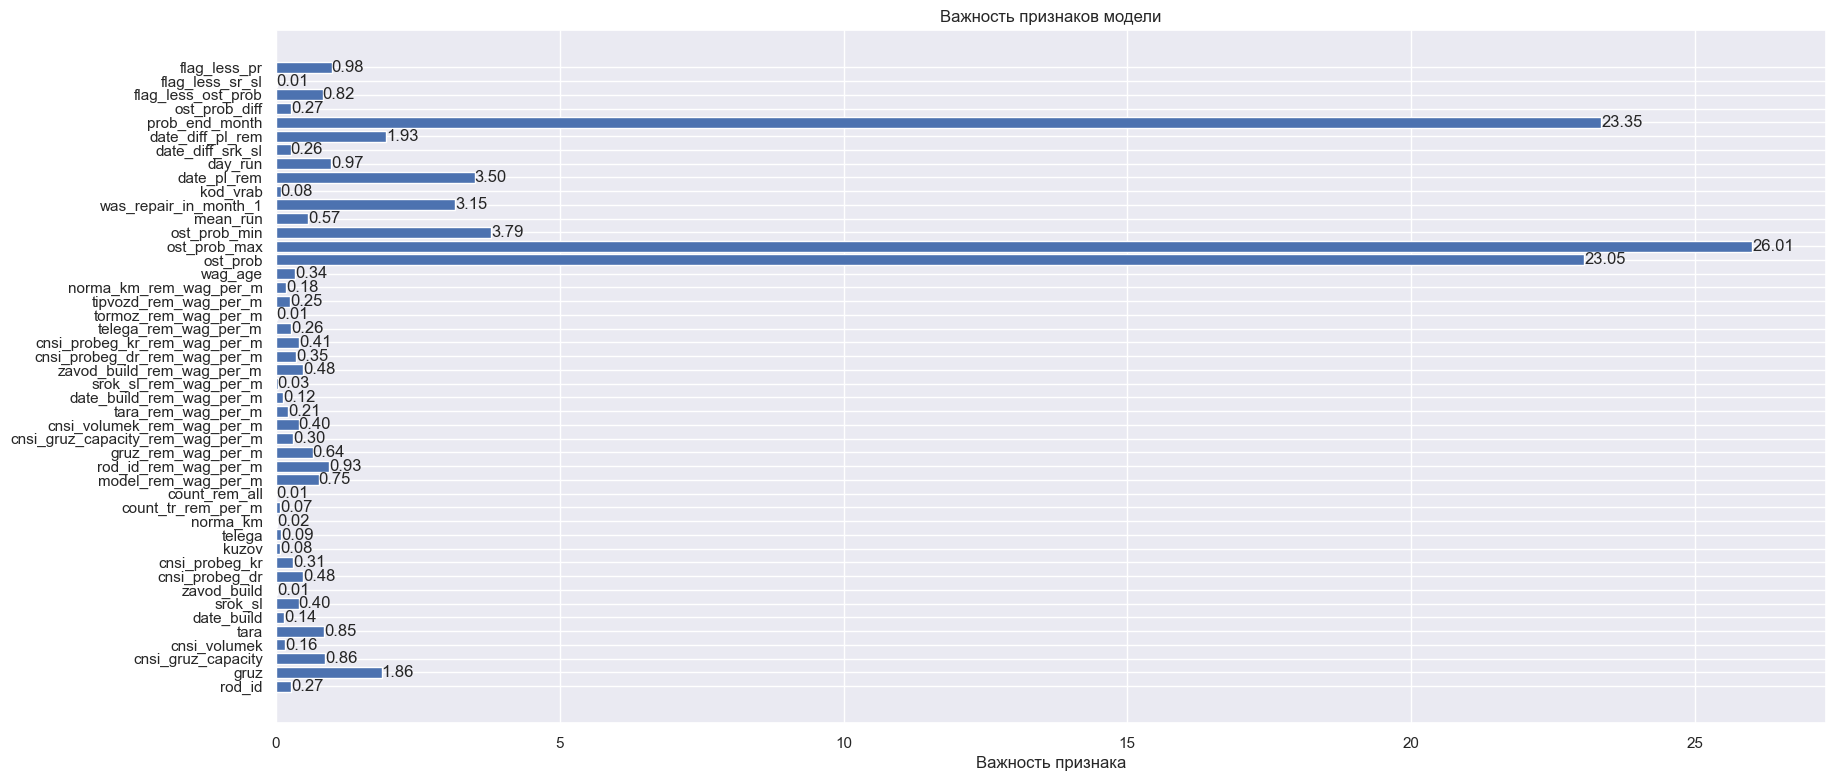

In [177]:
clf_ver2, feat_imp_list = fit_model_get_f1_fet_imp(X_train_v2, y_train_v2, ['model', 'tipvozd'])

## C фильтром не были в прошлым месяце в ПР

### Данные

In [179]:
X_train_v2_filt = X_train_v2.query('was_repair_in_month_1 != 1')

In [180]:
y_train_v2_filt = y_train_v2[X_train_v2_filt.index]

### Обучение

Было `0.59` на Декабре

['model', 'tipvozd']
cros_val_f1 0.5754851972668668


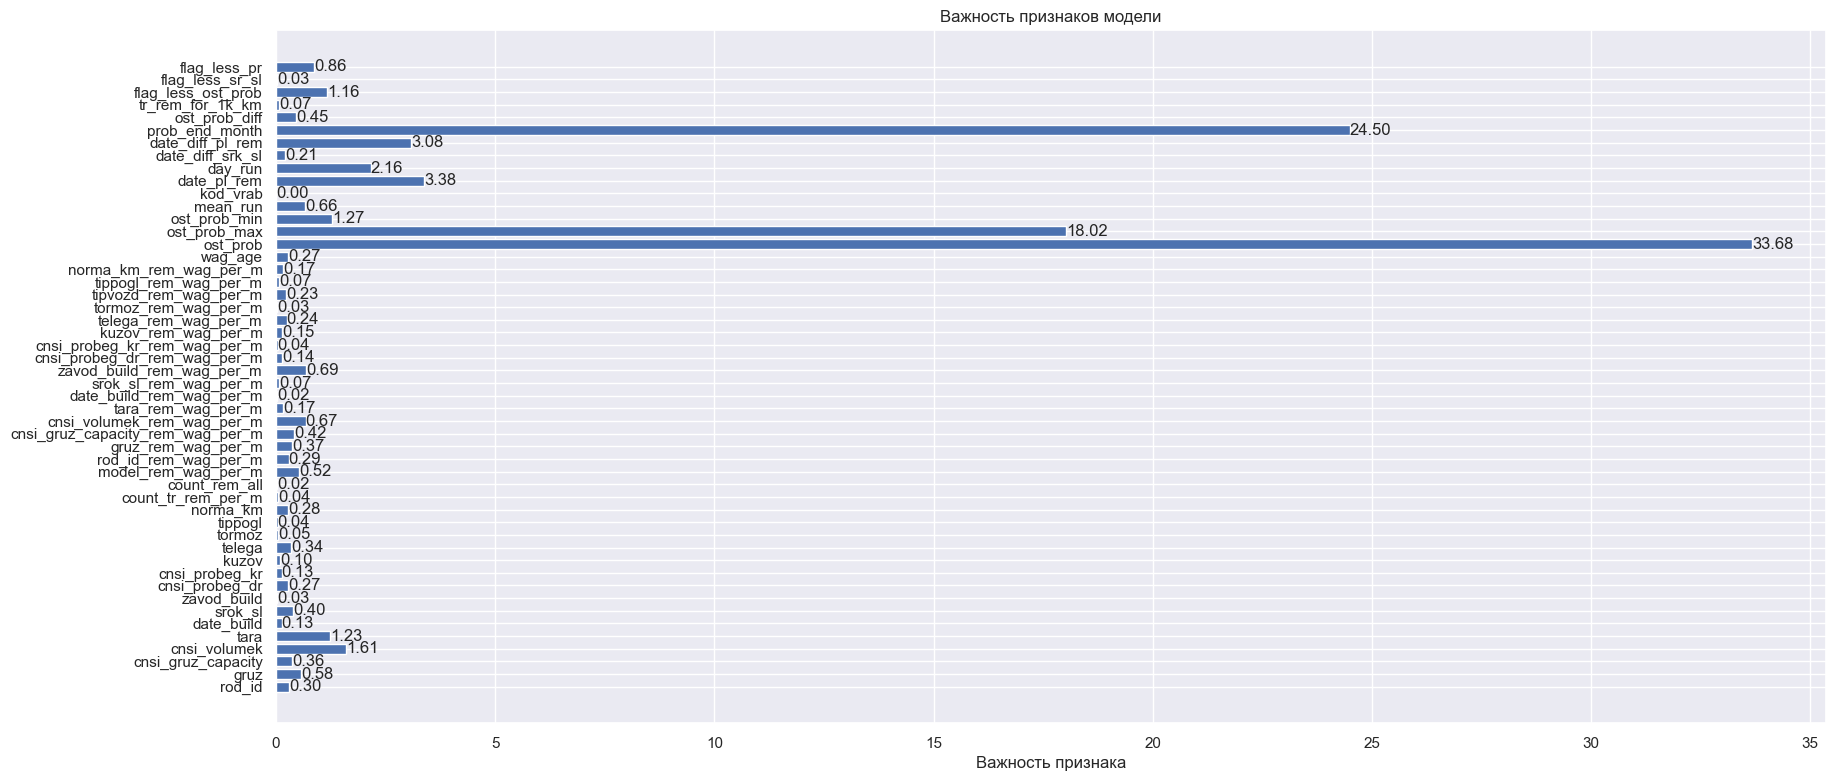

In [375]:
clf_ver2_filt, feat_imp_list_filt = fit_model_get_f1_fet_imp(X_train_v2_filt, y_train_v2_filt, ['model', 'tipvozd'])

### Отбор наиболее важных признаков

In [233]:
# Важность признаков
feature_importance = clf_ver2_filt.get_feature_importance(type='PredictionValuesChange')
feature_names = X_train_v2.columns

important_features_gr_3 = [feature for feature, importance in zip(feature_names, feature_importance) if importance > 20]

In [234]:
important_features_gr_3

['ost_prob', 'prob_end_month']

In [235]:
# important_features_gr_3.remove('date_pl_rem')

## Перебираем важные наборы признаков применяя к ним мат. операции

In [395]:
def perform_operations(df, col1, col2, opers=['+', '-', '/', '*']):
    """
    Сложение, умножение, деление и вычитание между колонками DataFrame.

    Parameters:
    - df (pd.DataFrame): Исходный DataFrame.
    - col1 (str): Имя первой колонки.
    - col2 (str): Имя второй колонки.

    Returns:
    - pd.DataFrame: DataFrame с результатами операций.
    """
    result_df = df.copy()
    
    # Сложение
    if '+' in opers:
        result_df[f'{col1}_{col2}_pl'] = df[col1] + df[col2]

    # Умножение
    if '*' in opers:
        result_df[f'{col1}_{col2}_um'] = df[col1] * df[col2]

    # Деление
    if '/' in opers:
        result_df[f'{col1}_{col2}_di'] = df[col1] / df[col2]

    # Вычитание
    if '-' in opers:
        result_df[f'{col1}_{col2}_mi'] = df[col1] - df[col2]

    return result_df

In [396]:
X_train_v2_filt_fet = perform_operations(X_train_v2_filt, 'ost_prob_max', 'ost_prob_min', ['+', '/', '*'])

In [397]:
for col1 in important_features_gr_3:
    for col2 in important_features_gr_3:
        if col1 != col2:
            X_train_v2_filt_fet = perform_operations(X_train_v2_filt_fet,  col1, col2)

In [398]:
X_train_v2_filt_fet.head()

model  rod_id  gruz  cnsi_gruz_capacity  cnsi_volumek  tara  \
wagnum                                                                    
0          11-276       0   680                 680         122.0   244   
1       11-066-04       0   680                 680         120.0   220   
2       Р-9494-01       0   680                 680         122.0   252   
3       11-066-04       0   680                 680         120.0   220   
4          11-217       0   680                 680         120.0   235   

       date_build    srok_sl  zavod_build  cnsi_probeg_dr  cnsi_probeg_kr  \
wagnum                                                                      
0      1993-06-17 2025-12-03            1             110             160   
1      1994-07-09 2026-03-07            1             110             160   
2      1994-10-30 2026-11-15            1             110             160   
3      1993-10-04 2025-10-03            1             110             160   
4      1994-06-03 2028-08-01           23             110             160   

        kuzov  telega  tormoz tipvozd  tippogl  norma_km  ownertype  \
wagnum                                                                
0           2       9       2       1       11    160000          0   
1           1       9       2       4        1    160000          0   
2          22       9       2       1       15    110000          0   
3           1       9       2       4        1    110000          0   
4           2       9       3       6        1    160000          0   

        count_tr_rem_per_m  count_rem_all  model_rem_wag_per_m  \
wagnum                                                           
0                      1.0            2.0             1.904504   
1                      0.0            0.0             2.000000   
2                      2.0            2.0             2.000000   
3                      2.0            2.0             2.000000   
4                      0.0            0.0             0.000000   

        rod_id_rem_wag_per_m  gruz_rem_wag_per_m  \
wagnum                                             
0                   1.910255            1.866488   
1                   1.910255            1.866488   
2                   1.910255            1.866488   
3                   1.910255            1.866488   
4                   1.910255            1.866488   

        cnsi_gruz_capacity_rem_wag_per_m  cnsi_volumek_rem_wag_per_m  \
wagnum                                                                 
0                               1.866488                    1.908626   
1                               1.866488                    1.500000   
2                               1.866488                    1.908626   
3                               1.866488                    1.500000   
4                               1.866488                    1.500000   

        tara_rem_wag_per_m  date_build_rem_wag_per_m  srok_sl_rem_wag_per_m  \
wagnum                                                                        
0                 2.015230                  1.166667               1.666667   
1                 2.056944                  0.000000               2.013889   
2                 2.000000                  1.875000               1.366667   
3                 2.056944                  3.000000               1.250000   
4                 2.040874                  2.000000               1.900000   

        zavod_build_rem_wag_per_m  cnsi_probeg_dr_rem_wag_per_m  \
wagnum                                                            
0                        1.918238                      1.970467   
1                        1.918238                      1.970467   
2                        1.918238                      1.970467   
3                        1.918238                      1.970467   
4                        0.000000                      1.970467   

        cnsi_probeg_kr_rem_wag_per_m  kuzov_rem_wag_per_m  \
wagnum                        

In [402]:
X_train_v2_filt_fet['rod_id'] = X_train_v2_filt_fet['rod_id'].astype(float)

['model', 'tipvozd']
cros_val_f1 0.5755519095017068


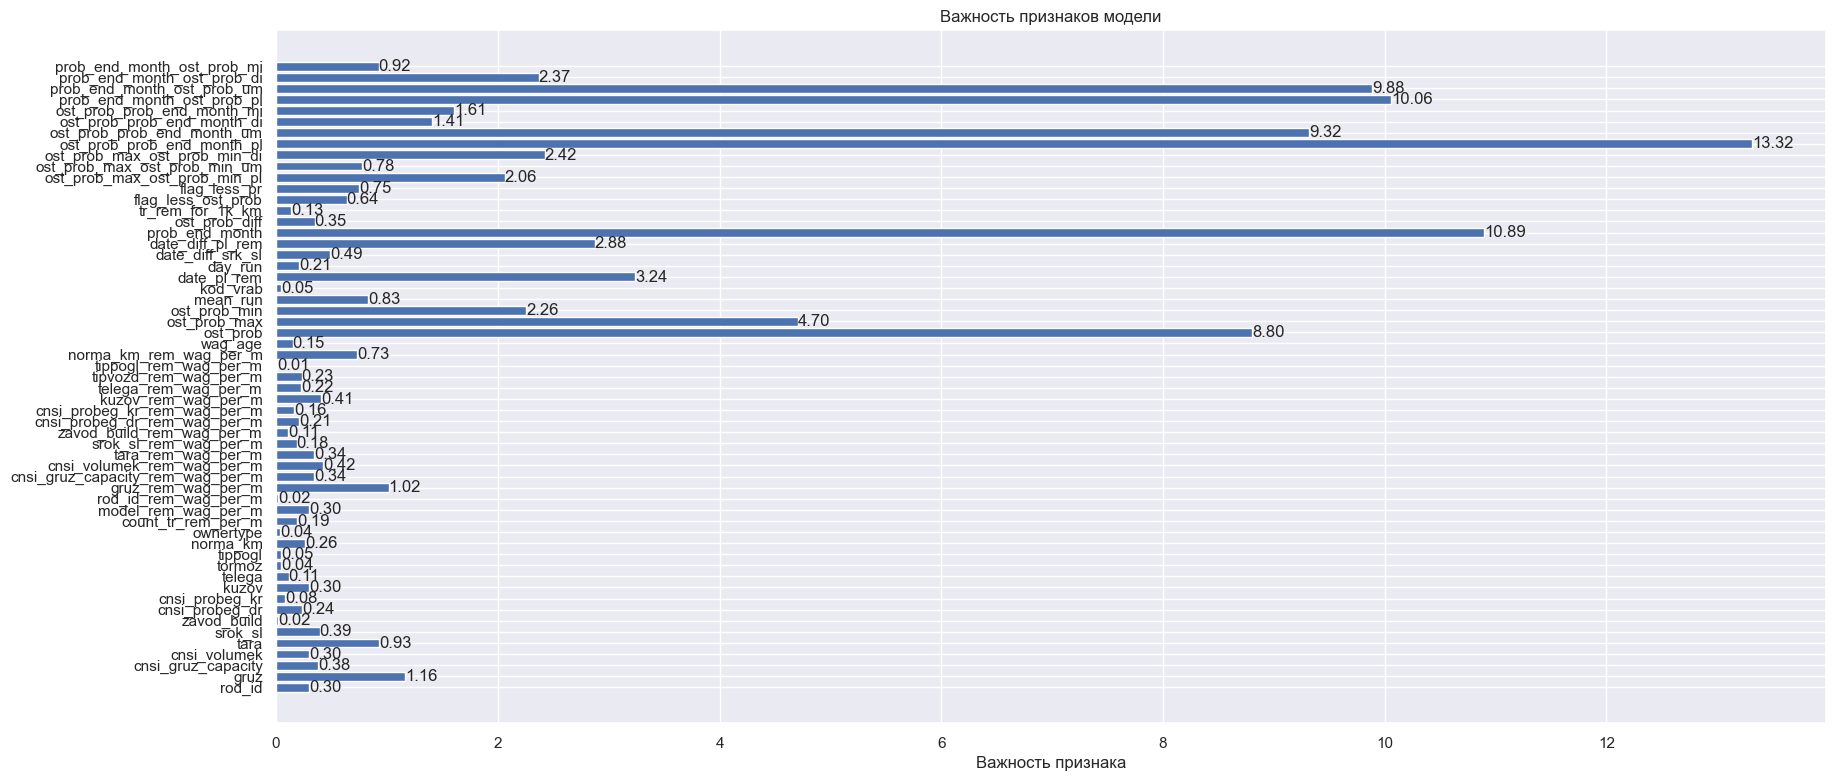

In [403]:
clf_ver2_filt_fet, feat_imp_list_filt_fet = fit_model_get_f1_fet_imp(X_train_v2_filt_fet, y_train_v2_filt, ['model', 'tipvozd'])

## Обучение. Только важные признаки

Было `0.59` на Декабре

cros_val_f1 0.5760774797469169


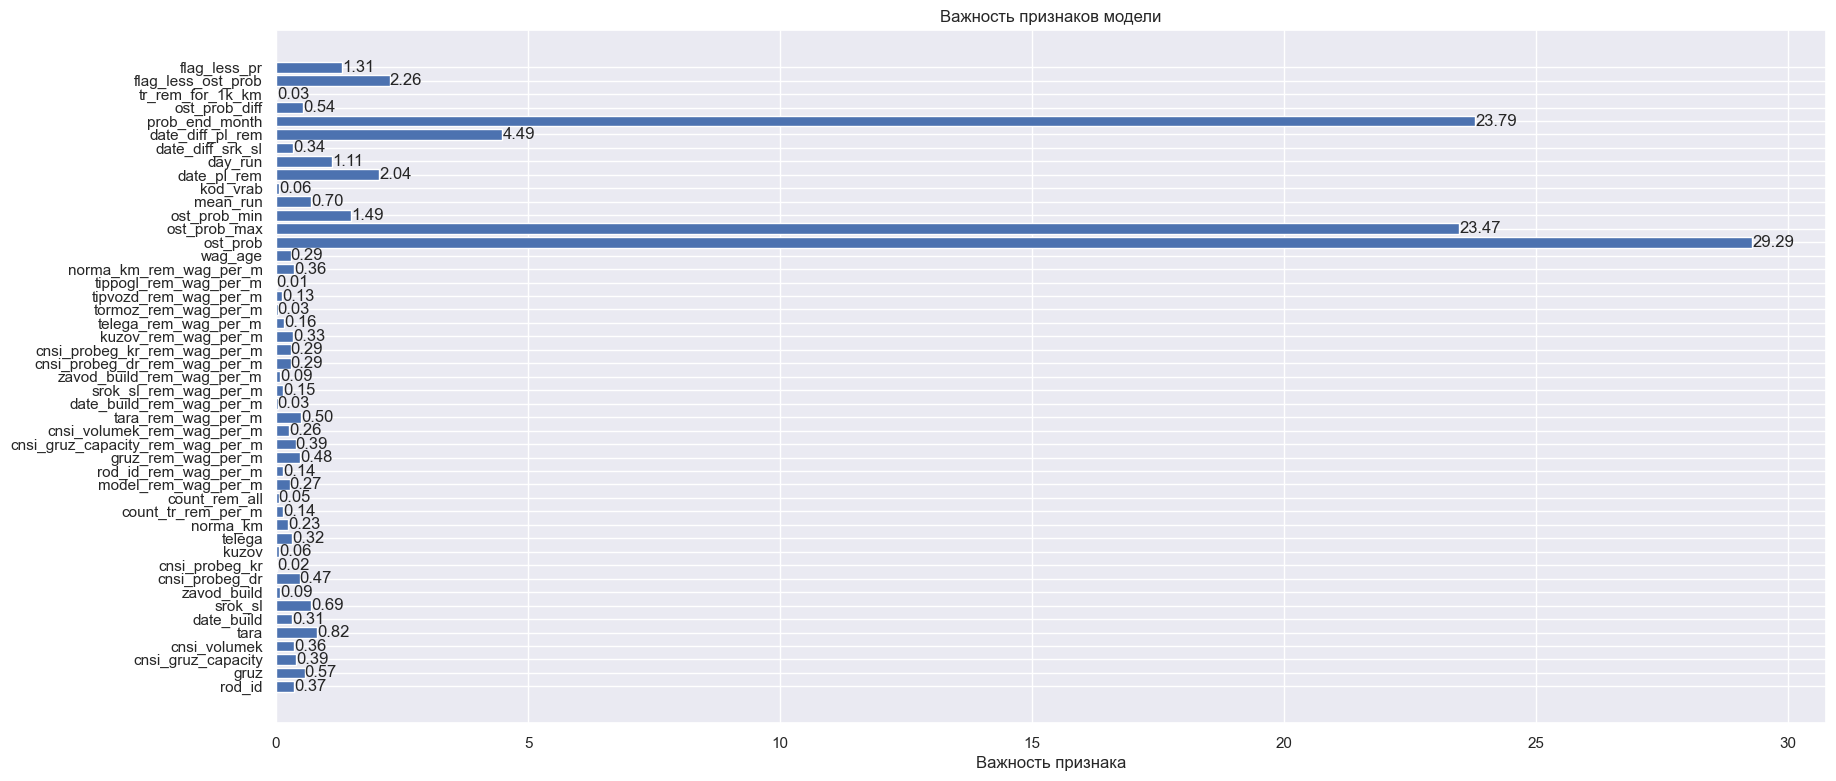

In [381]:
clf_ver2_filt_imp , feat_imp_list_filt_imp = fit_model_get_f1_fet_imp(X_train_v2_filt_fet[feat_imp_list_filt], y_train_v2_filt, need_cat_feat=False, bal='Balanced')

In [385]:
len(feat_imp_list_filt_imp), len(feat_imp_list_filt)

(47, 50)

In [386]:
clf_ver2_filt_imp.predict(X_train_v2_filt_fet[feat_imp_list_filt_imp])

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [387]:
X_train_v2_filt_fet[feat_imp_list_filt_imp].info()

<class 'pandas.core.frame.DataFrame'>
Index: 32038 entries, 0 to 33976
Data columns (total 47 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   rod_id                            32038 non-null  Int64         
 1   gruz                              32038 non-null  Int64         
 2   cnsi_gruz_capacity                32038 non-null  Int64         
 3   cnsi_volumek                      32038 non-null  Float64       
 4   tara                              32038 non-null  Int64         
 5   date_build                        32038 non-null  datetime64[ns]
 6   srok_sl                           32038 non-null  datetime64[ns]
 7   zavod_build                       32038 non-null  Int64         
 8   cnsi_probeg_dr                    32038 non-null  Int64         
 9   cnsi_probeg_kr                    32038 non-null  Int64         
 10  kuzov                             32038 non-null  I

## Применяем порог

In [241]:
def make_and_plot_thre(clf, X_train, y_train):
    y_pred1 = clf.predict_proba(X_train)[:, 1]
    y_true = y_train

    thresholds = np.linspace(0, 1, 50)  

    f1_scores = []
    threshold_values = []

    # Перебор порогов
    for threshold in thresholds:
        y_pred_binary_plot = (y_pred1 > threshold).astype(int)
        f1 = f1_score(y_true, y_pred_binary_plot)
        f1_scores.append(f1)
        threshold_values.append(threshold)

    plt.plot(threshold_values, f1_scores, marker='o', linestyle='-')
    plt.xlabel('Порог')
    plt.ylabel('F1-мера')
    plt.title('Зависимость F1-меры от порога')
    plt.grid(True)
    plt.show()

    # Подсчет лучшего порога
    best_threshold_index = np.argmax(f1_scores)
    best_threshold_m = threshold_values[best_threshold_index]

    print(f"Лучший порог: {best_threshold_m}")
    
    y_pred_tr1 = clf.predict_proba(X_train)[:, 1]  # Получение вероятностей положительного класса
    y_pred_binary_tr1 = (y_pred_tr1 > best_threshold_m).astype(int)  # Бинарные предсказания
    
    # Считаем f1_score
    f1 = f1_score(y_pred_binary_tr1, y_train)
    print(f'f1', round(f1, 3))

    return best_threshold_m, y_pred_binary_tr1, y_pred_tr1

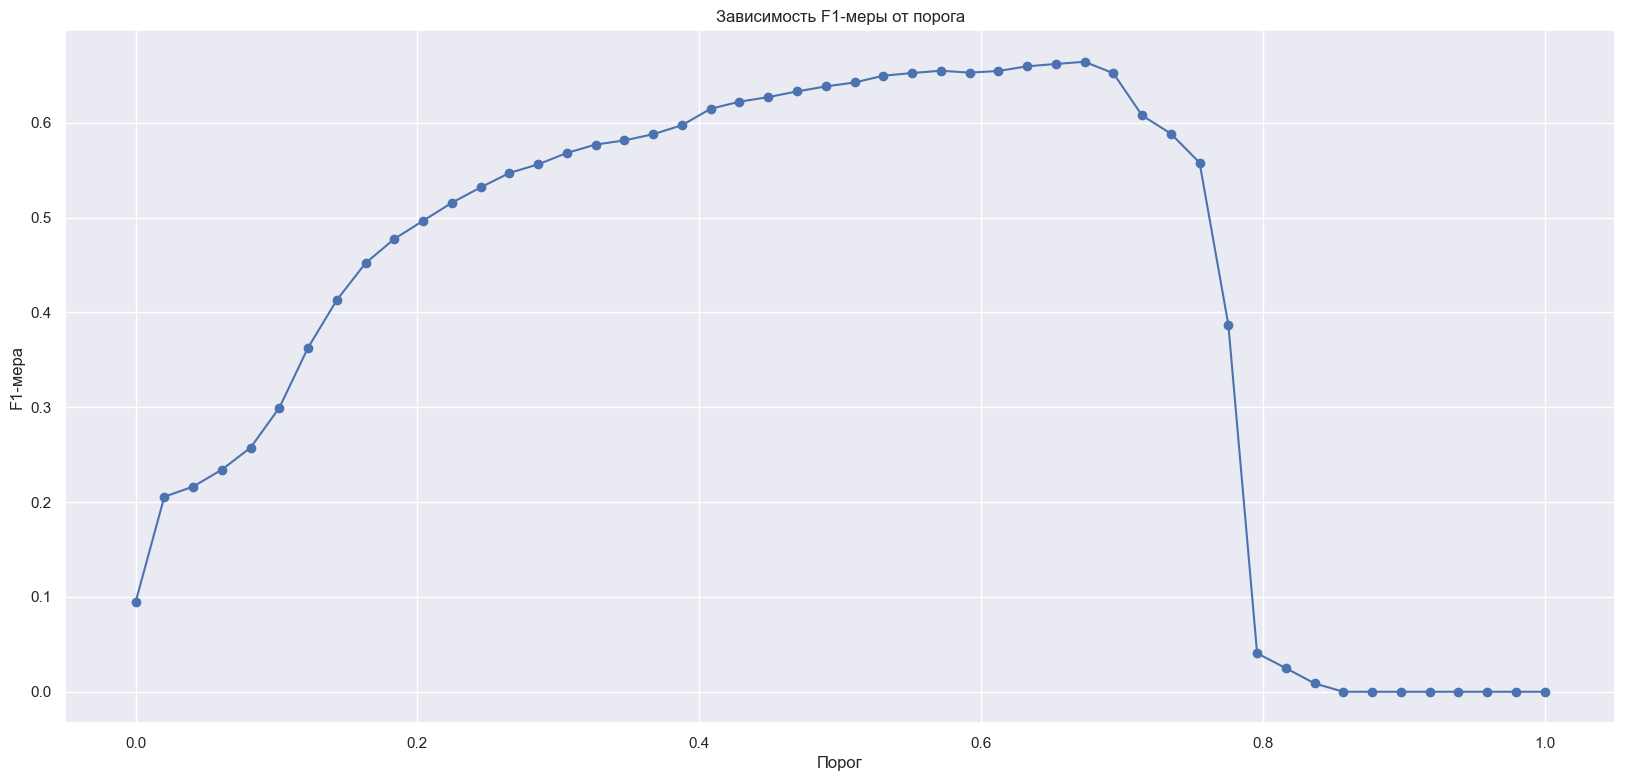

Лучший порог: 0.673469387755102
f1 0.664


In [404]:
best_threshold_month_v2, y_pred_binary_v2, y_pred_tr_v2  = make_and_plot_thre(clf_ver2_filt_fet, X_train_v2_filt_fet, y_train_v2_filt)

In [405]:
df_pred_month_v2 =\
pd.DataFrame(y_pred_binary_v2, columns=['target_month'], index=y_train_v2_filt.index)

In [406]:
df_pred_month_v2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32038 entries, 0 to 33976
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   target_month  32038 non-null  int32
dtypes: int32(1)
memory usage: 1.4 MB


In [407]:
df_pred_month_v2['target_month'].value_counts()

0    30225
1     1813
Name: target_month, dtype: int64

# Модель тестовая для target_day. target_month как фича. Важность признаков, f1, ver. 2

### Данные

In [293]:
X_train_v2_day =\
X_train_v2_filt_fet[feat_imp_list_filt_fet].copy()

In [294]:
X_train_v2_day =\
X_train_v2_day.join(df_pred_month_v2)

In [295]:
X_train_v2_day.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32038 entries, 0 to 33976
Data columns (total 58 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   rod_id                            32038 non-null  Int64         
 1   gruz                              32038 non-null  Int64         
 2   cnsi_gruz_capacity                32038 non-null  Int64         
 3   cnsi_volumek                      32038 non-null  Float64       
 4   tara                              32038 non-null  Int64         
 5   srok_sl                           32038 non-null  datetime64[ns]
 6   zavod_build                       32038 non-null  Int64         
 7   cnsi_probeg_dr                    32038 non-null  Int64         
 8   cnsi_probeg_kr                    32038 non-null  Int64         
 9   kuzov                             32038 non-null  Int64         
 10  telega                            32038 non-null  I

In [296]:
target_train_v2_day = pd.read_csv(path_train_v2 + '/target/y_test.csv').convert_dtypes()

In [297]:
y_train_v2_day =\
target_train_v2_day.set_index('wagnum')['target_day']

In [298]:
y_train_v2_day =\
y_train_v2_day[y_train_v2_day.index.isin(y_train_v2_filt.index)]

In [299]:
y_train_v2_day.info()

<class 'pandas.core.series.Series'>
Index: 32038 entries, 33361 to 8061
Series name: target_day
Non-Null Count  Dtype
--------------  -----
32038 non-null  Int64
dtypes: Int64(1)
memory usage: 563.2 KB


### Обучение

cros_val_f1 0.0


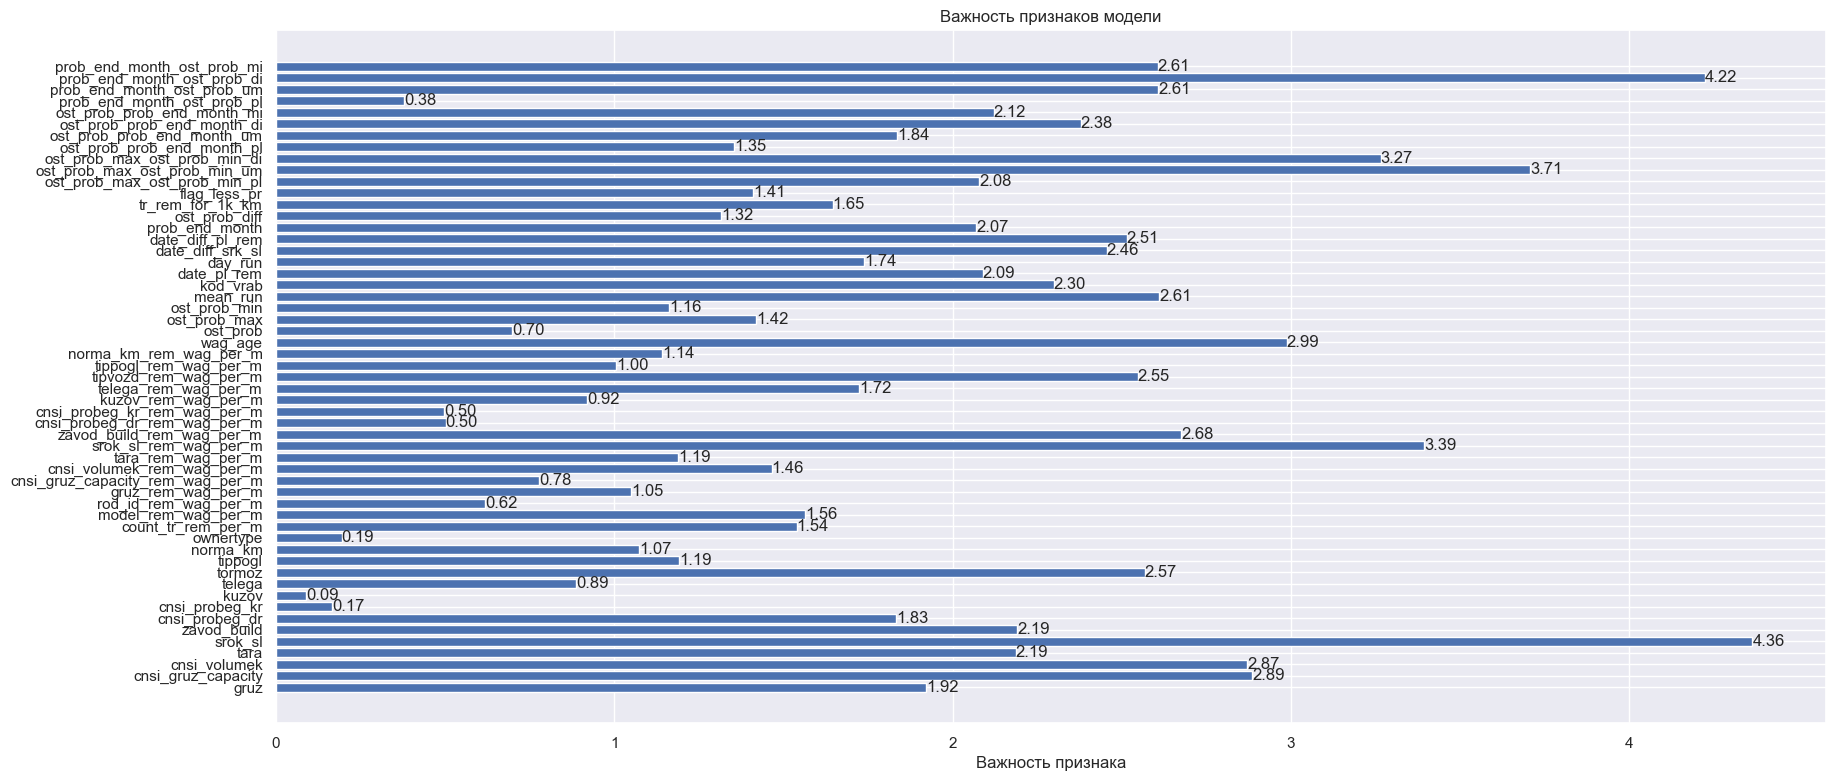

In [300]:
clf_ver2_filt_day, feat_imp_list_filt_day = fit_model_get_f1_fet_imp(X_train_v2_day, y_train_v2_day, need_cat_feat=False, bal='Balanced')

### Порог

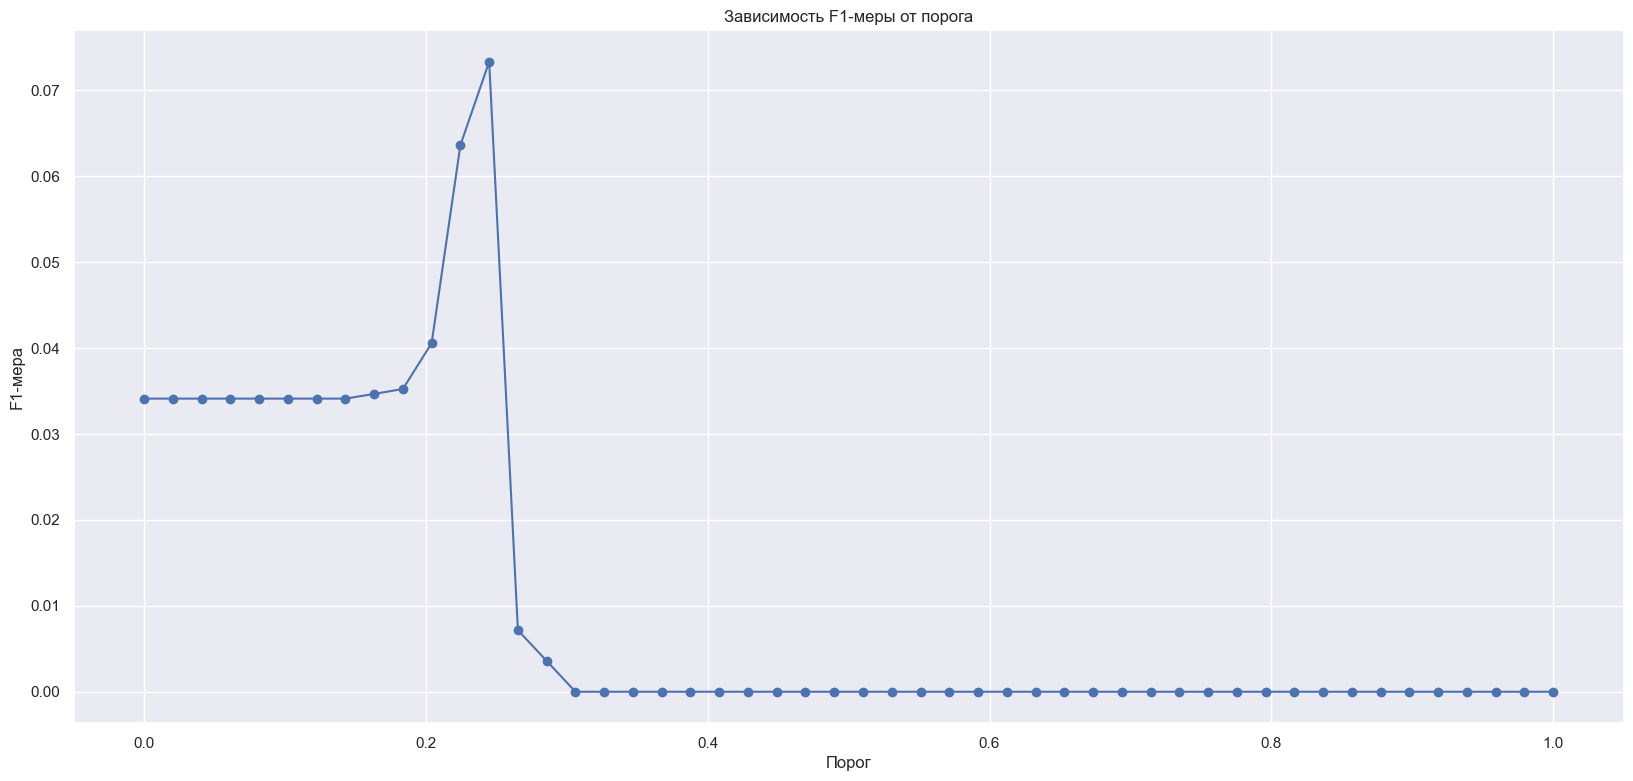

Лучший порог: 0.24489795918367346
f1 0.073


In [301]:
best_threshold_month_v2_day, y_pred_binary_v2_day, y_pred_tr_v2_day = make_and_plot_thre(clf_ver2_filt_day, X_train_v2_day, y_train_v2_day)

# Модель тестовая для target_day. target_month как фильтр. Важность признаков, f1, ver. 2

### Данные

In [408]:
X_train_v2_day =\
X_train_v2_filt_fet.copy()

In [409]:
X_train_v2_day =\
X_train_v2_day.join(df_pred_month_v2)

In [410]:
X_train_v2_day =\
X_train_v2_day.query('target_month == 1').drop(columns=['target_month'])

In [411]:
X_train_v2_day.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1813 entries, 842 to 33912
Data columns (total 76 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   model                             1813 non-null   string        
 1   rod_id                            1813 non-null   float64       
 2   gruz                              1813 non-null   Int64         
 3   cnsi_gruz_capacity                1813 non-null   Int64         
 4   cnsi_volumek                      1813 non-null   Float64       
 5   tara                              1813 non-null   Int64         
 6   date_build                        1813 non-null   datetime64[ns]
 7   srok_sl                           1813 non-null   datetime64[ns]
 8   zavod_build                       1813 non-null   Int64         
 9   cnsi_probeg_dr                    1813 non-null   Int64         
 10  cnsi_probeg_kr                    1813 non-null   

In [412]:
target_train_v2_day = pd.read_csv(path_train_v2 + '/target/y_test.csv').convert_dtypes()

In [413]:
y_train_v2_day =\
target_train_v2_day.set_index('wagnum')['target_day']

In [414]:
y_train_v2_day =\
y_train_v2_day[y_train_v2_day.index.isin(X_train_v2_day.index)]

In [415]:
y_train_v2_day.info()

<class 'pandas.core.series.Series'>
Index: 1813 entries, 33355 to 14242
Series name: target_day
Non-Null Count  Dtype
--------------  -----
1813 non-null   Int64
dtypes: Int64(1)
memory usage: 31.9 KB


### Обучение

['model', 'tipvozd']
cros_val_f1 0.0


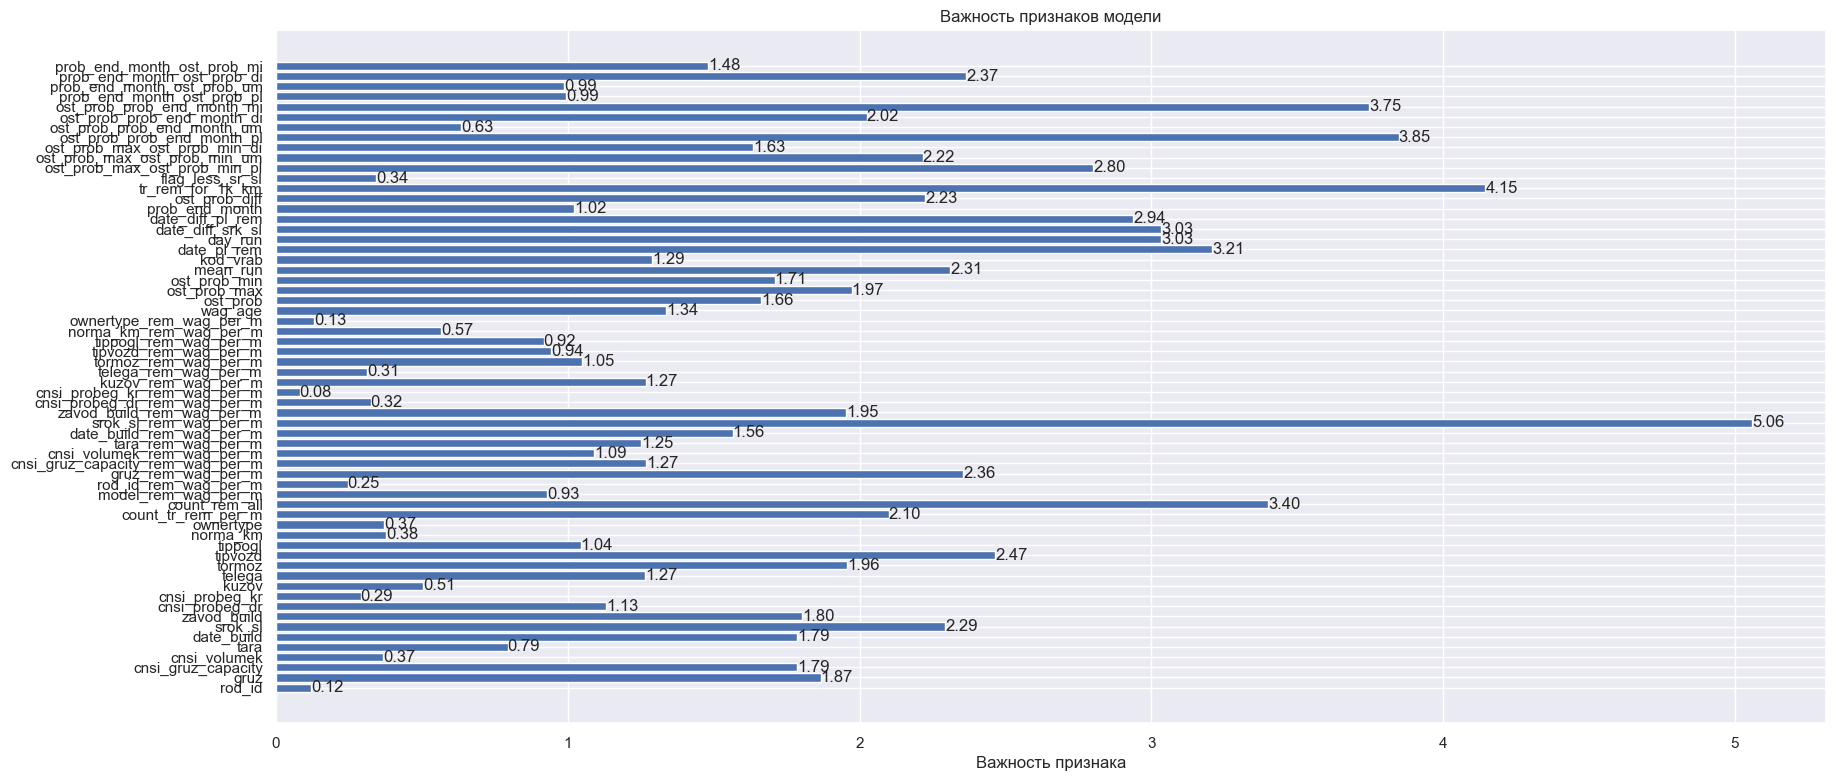

In [417]:
clf_ver2_filt_day, feat_imp_list_filt_day = fit_model_get_f1_fet_imp(X_train_v2_day, y_train_v2_day, ['model', 'tipvozd'], bal='Balanced')

### Порог

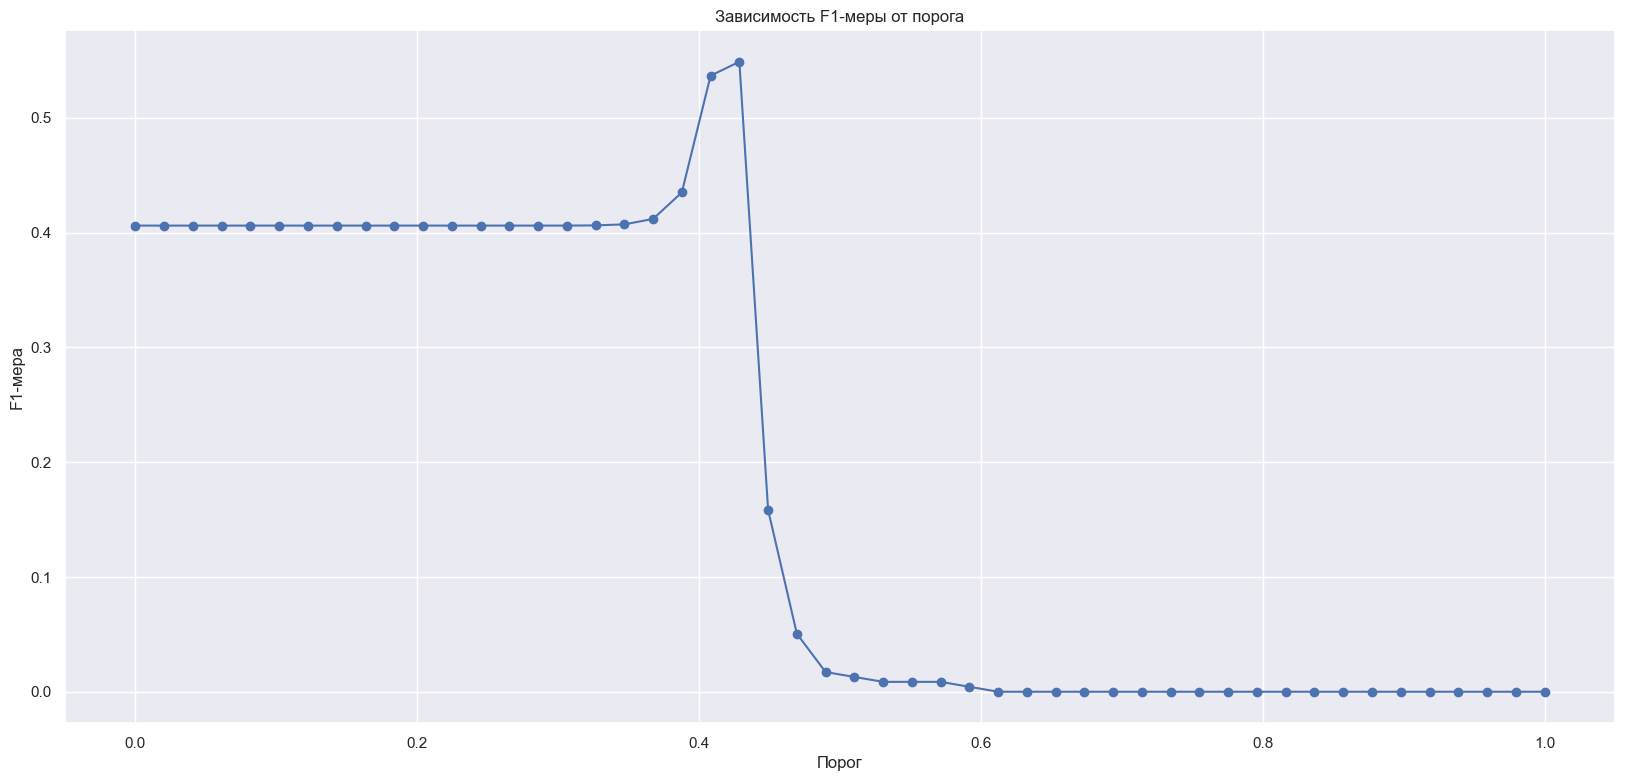

Лучший порог: 0.42857142857142855
f1 0.549


In [418]:
best_threshold_month_v2_day, y_pred_binary_v2_day, y_pred_tr_v2_day = make_and_plot_thre(clf_ver2_filt_day, X_train_v2_day, y_train_v2_day)

Если удалять ненужные столбы:
```Лучший порог: 0.42857142857142855
f1 0.526```

# Проверяем тестовую модель ver. 2 на тестовых данных (март)

## Функции для создания данных v2

In [325]:
def make_wp_test_ver2(wag_param, wag_prob, pr_rem, tr_rem, dislok, target, month_to_predict='2023-01-01', month_prev=12, info=False):
    '''
    Передаём: параметры вагона, пробег вагона, плановые ремонты, дислокацию, таргет
    дату отчёта на которую предиктим (по умолчанию 2023-01-01), 
    предыдущий месяц от даты отчёта (по умолчанию 12)
    , информация о датасетах
    
    Возвращает: сэмпл фичей для обработки, target
    '''
    target = target.copy()
    # Достаём ТАРГЕТ для нужной даты month_to_predict
    target.month = pd.to_datetime(target.month)
    
    target = target[target.month == month_to_predict].copy()
    print('target', target['month'].unique())
    target = target[['wagnum','month']]
    
    
    print('\nДостаём данные')
    # Достаём ПРОБЕГ для нужной даты month_to_predict
    wag_prob = wag_prob[(wag_prob.repdate == wag_prob.repdate.max()) | (wag_prob.repdate == wag_prob.repdate.min())]
    
    print('\nВ wag_prob уникальные даты:', wag_prob['repdate'].unique())
    
    # Оценим среднесуточный пробег из данных по пробегу вагона, на тот случай, если данных по нормативу нет
    wag_prob_ = wag_prob.groupby('wagnum', as_index = False).agg({'repdate':['max', 'min'] , 'ost_prob': ['max','min']},)#.droplevel(1)
    wag_prob_.columns = [head+'_' + name
                         if head!='wagnum'
                         else head
                         for head, name in wag_prob_.columns ]

    wag_prob_['diff_days'] = (wag_prob_.repdate_max - wag_prob_.repdate_min).dt.days
    wag_prob_['mean_run'] = (wag_prob_.ost_prob_max - wag_prob_.ost_prob_min ) / wag_prob_.diff_days
    wag_prob = wag_prob[wag_prob.repdate == wag_prob.repdate.max()][['wagnum','ost_prob']]
    wag_prob = wag_prob.merge(wag_prob_)
    
    print('\nСобираем wag_param')
    # Достаём ПАРАМЕТРЫ вагона для нужной даты month_to_predict. У вагонов могут меняться параметры, поэтмоу номер дублируется
    wag_param = wag_param.drop_duplicates(subset='wagnum', keep='last')
    # wag_param = wag_param[['wagnum','srok_sl','cnsi_probeg_dr','cnsi_probeg_kr']]
    wag_param, list_months = all_rems_for_wagon_ver2(tr_rem, wag_param, month_to_predict, True)
    print('Месяца в wag_param', list_months)
    wag_param = wag_param.drop(columns=['date_iskl'])
    # print(wag_param)
    wag_param['wag_age'] = (pd.to_datetime(month_to_predict) - wag_param['date_build']).dt.days
    
    
    # Достаём данные по ПЛАНОВЫМ ремонтам за прошедший месяц
    pr_rem_l = pr_rem[pr_rem['month'] == month_prev].copy()
    
    print('\npr_rem за месяц:', pr_rem_l['month'].unique()[0])
    
    # добавим признак, что вагон был в ПР в предыдущем месяце. Скорее всего, если вагон был в ПР недавно, то повторно он не поедет
    pr_rem_l[f'was_repair_in_month_{month_prev}'] = 1
    pr_rem_l = pr_rem_l[['wagnum', f'was_repair_in_month_{month_prev}']]
    pr_rem_l = pr_rem_l.drop_duplicates(subset='wagnum') #некоторые вагоны все же ремонтируются больше 1 раза, поэтому нужен сбросить дубли
    
    # добавляем признаки что вагона был в предыдущиъ месяцах в ПР
    for i in range(len(list_months)-2, -1, -1):
        month = list_months[i]

        pr_rem_c = pr_rem[pr_rem['month'] == month].copy()
        print(f'Was_repair_in_month_{month}')

        pr_rem_c[f'was_repair_in_month_{month}'] = 1
        pr_rem_c = pr_rem_c[['wagnum', f'was_repair_in_month_{month}']]
        pr_rem_c = pr_rem_c.drop_duplicates(subset='wagnum') #некоторые вагоны все же ремонтируются больше 1 раза, поэтому нужен сбросить дубли
        
        pr_rem_l =\
        pr_rem_l.merge(pr_rem_c, on='wagnum', how='left')
        
    print('pr_rem_columns', pr_rem_l.columns, '\n')
    
    # Достаём данные по ТЕКУЩИМ ремонтам за прошедший месяц
    tr_rem = tr_rem[tr_rem['rem_month'].dt.month == month_prev]
    
    print('tr_rem за месяц:', tr_rem['rem_month'].dt.month.unique()[0])
    
    tr_rem = tr_rem.groupby('wagnum', as_index= False).kod_vrab.count()
    
    
    # Достаём данные по ДИСЛОКАЦИИ для нужной даты month_to_predict
    dislok = dislok[dislok['plan_date'] <= month_to_predict] \
    .drop_duplicates(subset = 'wagnum', keep='last')
    print('\nВ dislok уникальные даты:', dislok['plan_date'].unique())
    
    # Показать инфо
    if info:
        print('\n', wag_prob.info())
        print('\n', wag_param.info())
        print('\n', pr_rem.info())
        print('\n', tr_rem.info())
        print('\n', dislok.info())
    
    print('\nДелаем фичи')
    # Создаём фичи
    wp = target[['wagnum']]\
    .merge(wag_param, on ='wagnum', how = 'left')\
    .merge(wag_prob, on ='wagnum', how = 'left')\
    .merge(pr_rem_l, on ='wagnum', how = 'left')\
    .merge(tr_rem, on ='wagnum', how = 'left')\
    .merge(dislok[['wagnum','date_pl_rem']], on ='wagnum', how = 'left')
    

    print('\nЗаполняме пропуски')
    numeric_columns = wp.select_dtypes(include=['int', 'float'])
    # Заменим отсутствующие значения на нули
    wp[numeric_columns.columns] = numeric_columns.fillna(0)
    
    return wp, target

In [333]:
def make_features_wp_test_ver2(wp, month_to_predict, month=True):
    '''
     Передаём: сэмпл фичей, target
     таргет за месяц (по умолчанию) или месяц + 10 дней
     
     Возрашает: фичи и таргет
    '''
    
    print('Считаем среднедневный пробег')
    # Считаем среднедневный пробег
    # wp[['cnsi_probeg_dr','cnsi_probeg_kr','mean_run', 'was_repair_in_prev_month', 'kod_vrab']] =\
    # wp[['cnsi_probeg_dr','cnsi_probeg_kr','mean_run', 'was_repair_in_prev_month', 'kod_vrab']].fillna(0)
    wp['day_run'] = wp.apply(lambda x : [ val  for val in [x.cnsi_probeg_kr, x.cnsi_probeg_dr, x.mean_run] if val != 0], axis = 1 )
    wp['day_run']= wp.apply(lambda x : np.mean(x.day_run) if len(x.day_run)> 0 else 0, axis = 1 )

    wp['current_date'] = pd.to_datetime(month_to_predict)
    # Дней до окончания срока службы на month_to_predict
    wp['date_diff_srk_sl'] = (wp['srok_sl']- wp['current_date']).dt.days
    # Дней до планового ремонта на month_to_predict
    wp['date_diff_pl_rem'] = (wp['date_pl_rem']- wp['current_date']).dt.days
    # Остаточный пробег на конец месяца
    wp['prob_end_month'] = wp['ost_prob'] - wp['day_run'] * 30
    
    wp['ost_prob_diff'] = wp['ost_prob_max'] - wp['ost_prob_min']
    
    wp['tr_rem_for_1k_km'] = np.where((wp['count_rem_all'] > 0), (wp['ost_prob_diff'] // 1000) / wp['count_rem_all'], 0).astype(float)
    wp['tr_rem_for_km'] = np.where((wp['count_rem_all'] > 0), (wp['ost_prob_diff']) / wp['count_rem_all'], 0).astype(float)
    
    
    # вагон выбывает в ПР в следующем месяце, если:
    # остаточный пробег < 5 000 км
    # срок службы < 500 лней
    # до следующего  ПР < 40 дней
    # число текущих ремонтов > 5
    wp['flag_less_ost_prob'] = np.where((wp.prob_end_month <= 5000), 1, 0)
    wp['flag_less_sr_sl'] = np.where((wp.date_diff_srk_sl < 500), 1, 0)
    wp['flag_less_pr'] = np.where((wp.date_diff_pl_rem < 40), 1, 0)
    wp['flag_less_kod_vrab'] = np.where((wp.kod_vrab > 5), 1, 0)
    
    
    print('Заполняме пропуски')
    numeric_columns = wp.select_dtypes(include=['int', 'float'])
    # Заменим отсутствующие значения на нули
    wp[numeric_columns.columns] = numeric_columns.fillna(0)
    
    print('Сортируем номега вагонов')
    # Фичи
    X = wp.set_index('wagnum').sort_index()
        
    return X

## Тестовый датасет февраль v2

In [420]:
# %%time
wp_test_real, target_test_real = make_wp_test_ver2(wag_param_clear_v2, wag_prob_clear_all, pr_rem_clear_all, tr_rem_clear_all, dislok_clear_all, target_clear_v2, '2023-03-01', 2)

target ['2023-03-01T00:00:00.000000000']

Достаём данные

В wag_prob уникальные даты: ['2022-08-01T00:00:00.000000000' '2023-02-28T00:00:00.000000000']

Собираем wag_param


C:\Users\mayer\AppData\Local\Temp\ipykernel_21784\1739779545.py:16: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  wag_param.merge(wag_rem_months_group, on='wagnum', how='left')
C:\Users\mayer\AppData\Local\Temp\ipykernel_21784\1739779545.py:16: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  wag_param.merge(wag_rem_months_group, on='wagnum', how='left')


Месяца [ 8  9 10 11 12  1  2]
Месяца [ 8  9 10 11 12  1  2]
Месяца [ 8  9 10 11 12  1  2]
Месяца [ 8  9 10 11 12  1  2]
Месяца [ 8  9 10 11 12  1  2]
Месяца [ 8  9 10 11 12  1  2]
Месяца [ 8  9 10 11 12  1  2]
Месяца [ 8  9 10 11 12  1  2]
Месяца [ 8  9 10 11 12  1  2]
Месяца [ 8  9 10 11 12  1  2]
Месяца [ 8  9 10 11 12  1  2]
Месяца [ 8  9 10 11 12  1  2]
Месяца [ 8  9 10 11 12  1  2]
Месяца [ 8  9 10 11 12  1  2]
Месяца [ 8  9 10 11 12  1  2]
Месяца [ 8  9 10 11 12  1  2]
Месяца [ 8  9 10 11 12  1  2]
Месяца [ 8  9 10 11 12  1  2]
Месяца в wag_param [8, 9, 10, 11, 12, 1, 2]

pr_rem за месяц: 2
Was_repair_in_month_1
Was_repair_in_month_12
Was_repair_in_month_11
Was_repair_in_month_10
Was_repair_in_month_9
Was_repair_in_month_8
pr_rem_columns Index(['wagnum', 'was_repair_in_month_2', 'was_repair_in_month_1',
       'was_repair_in_month_12', 'was_repair_in_month_11',
       'was_repair_in_month_10', 'was_repair_in_month_9',
       'was_repair_in_month_8'],
      dtype='object') 

tr_re

In [421]:
wp_test_real.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33707 entries, 0 to 33706
Data columns (total 56 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   wagnum                            33707 non-null  Int64         
 1   model                             33707 non-null  string        
 2   rod_id                            33707 non-null  Int64         
 3   gruz                              33707 non-null  Int64         
 4   cnsi_gruz_capacity                33707 non-null  Int64         
 5   cnsi_volumek                      33707 non-null  Float64       
 6   tara                              33707 non-null  Int64         
 7   date_build                        33707 non-null  datetime64[ns]
 8   srok_sl                           33707 non-null  datetime64[ns]
 9   zavod_build                       33707 non-null  Int64         
 10  cnsi_probeg_dr                    33707 non-nu

In [422]:
wp_test_real.head()

wagnum       model  rod_id  gruz  cnsi_gruz_capacity  cnsi_volumek  tara  \
0   33361  12-1303-01       1   690                 690          88.0   245   
1   33364  12-1303-01       1   690                 690          88.0   245   
2   33366  12-1303-01       1   690                 690          88.0   245   
3   33358  12-1303-01       1   690                 690          88.0   245   
4   33349  12-1303-01       1   690                 690          88.0   245   

  date_build    srok_sl  zavod_build  cnsi_probeg_dr  cnsi_probeg_kr  kuzov  \
0 2011-02-08 2033-03-01            6             110             160      2   
1 2010-04-21 2031-04-12            6             110             160      2   
2 2010-06-23 2032-01-21            6             110             160      2   
3 2012-09-27 2032-11-30            6             110             160      2   
4 2011-11-20 2033-12-04            6             110             160      2   

   telega  tormoz tipvozd  tippogl  norma_km  ownertype  count_tr_rem_per_m  \
0       2       2       3       11    160000          0                 1.5   
1       2       2       3       11    160000          0                 2.0   
2       2       2       3       11    160000          0                 2.0   
3       2       2       3       11    160000          0                 2.0   
4       2       2       6       11    160000          0                 0.0   

   count_rem_all  model_rem_wag_per_m  rod_id_rem_wag_per_m  \
0            3.0             1.941624              1.995803   
1            2.0             1.941624              1.995803   
2            2.0             1.941624              1.995803   
3            2.0             1.941624              1.995803   
4            0.0             1.941624              1.995803   

   gruz_rem_wag_per_m  cnsi_gruz_capacity_rem_wag_per_m  \
0             1.98119                           1.98119   
1             1.98119                           1.98119   
2             1.98119                           1.98119   
3             1.98119                           1.98119   
4             1.98119                           1.98119   

   cnsi_volumek_rem_wag_per_m  tara_rem_wag_per_m  date_build_rem_wag_per_m  \
0                     1.98069            1.943016                  2.083333   
1                     1.98069            1.943016                  2.000000   
2                     1.98069            1.943016                  2.000000   
3                     1.98069            1.943016                  2.250000   
4                     1.98069            1.943016                  2.200000   

   srok_sl_rem_wag_per_m  zavod_build_rem_wag_per_m  \
0               1.916667                   1.984252   
1               2.500000                   1.984252   
2               2.000000                   1.984252   
3               2.250000                   1.984252   
4               1.694444                   1.984252   

   cnsi_probeg_dr_rem_wag_per_m  cnsi_probeg_kr_rem_wag_per_m  \
0                      1.962495                      1.971315   
1                      1.962495                      1.971315   
2                      1.962495                      1.971315   
3                      1.962495                      1.971315   
4                      1.962495                      1.971315   

   kuzov_rem_wag_per_m  telega_rem_wag_per_m  tormoz_rem_wag_per_m  \
0             1.969246                1.9861              1.960699   
1             1.969246                1.9861              1.960699   
2             1.969246                1.9861              1.960699   
3             1.969246                1.9861              1.960699   
4             1.969246                1.9861              1.960699   

   tipvozd_rem_wag_per_m  tippogl_rem_wag_per_m  norma_km_rem_wag_per_m  \
0               1.936906               1.976244                1.972471   
1               1.936906               1.976244                1.972471   
2

In [423]:
target_test_real.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33707 entries, 0 to 33706
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   wagnum  33707 non-null  Int64         
 1   month   33707 non-null  datetime64[ns]
dtypes: Int64(1), datetime64[ns](1)
memory usage: 822.9 KB


In [424]:
X_test_real = make_features_wp_test_ver2(wp_test_real, '2023-03-01')

Считаем среднедневный пробег
Заполняме пропуски
Сортируем номега вагонов


In [425]:
# Генерим доп. фичи
X_test_real = perform_operations(X_test_real, 'ost_prob_max', 'ost_prob_min', ['+', '/', '*'])

In [426]:
# Перебираем уже сохраненные важные признаки
for col1 in important_features_gr_3:
    for col2 in important_features_gr_3:
        if col1 != col2:
            X_test_real = perform_operations(X_test_real, col1, col2)

In [427]:
# Оставляем только важные
X_test_real = X_test_real

In [428]:
X_test_real['rod_id'] = X_test_real['rod_id'].astype(float)

In [429]:
X_test_real.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33707 entries, 0 to 33976
Data columns (total 78 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   model                             33707 non-null  string        
 1   rod_id                            33707 non-null  float64       
 2   gruz                              33707 non-null  Int64         
 3   cnsi_gruz_capacity                33707 non-null  Int64         
 4   cnsi_volumek                      33707 non-null  Float64       
 5   tara                              33707 non-null  Int64         
 6   date_build                        33707 non-null  datetime64[ns]
 7   srok_sl                           33707 non-null  datetime64[ns]
 8   zavod_build                       33707 non-null  Int64         
 9   cnsi_probeg_dr                    33707 non-null  Int64         
 10  cnsi_probeg_kr                    33707 non-null  I

In [431]:
X_test_real.head()

model  rod_id  gruz  cnsi_gruz_capacity  cnsi_volumek  tara  \
wagnum                                                                    
0          11-276     0.0   680                 680         122.0   244   
1       11-066-04     0.0   680                 680         120.0   220   
2       Р-9494-01     0.0   680                 680         122.0   252   
3       11-066-04     0.0   680                 680         120.0   220   
4          11-217     0.0   680                 680         120.0   235   

       date_build    srok_sl  zavod_build  cnsi_probeg_dr  cnsi_probeg_kr  \
wagnum                                                                      
0      1993-06-17 2025-12-03            1             110             160   
1      1994-07-09 2026-03-07            1             110             160   
2      1994-10-30 2026-11-15            1             110             160   
3      1993-10-04 2025-10-03            1             110             160   
4      1994-06-03 2028-08-01           23             110             160   

        kuzov  telega  tormoz tipvozd  tippogl  norma_km  ownertype  \
wagnum                                                                
0           2       9       2       1       11    160000          0   
1           1       9       2       4        1    160000          0   
2          22       9       2       1       15    110000          0   
3           1       9       2       4        1    110000          0   
4           2       9       3       6        1    160000          0   

        count_tr_rem_per_m  count_rem_all  model_rem_wag_per_m  \
wagnum                                                           
0                      1.0            2.0             1.904648   
1                      0.0            0.0             2.000000   
2                      2.0            4.0             2.000000   
3                      2.0            2.0             2.000000   
4                      0.0            0.0             0.000000   

        rod_id_rem_wag_per_m  gruz_rem_wag_per_m  \
wagnum                                             
0                   1.901954             1.86736   
1                   1.901954             1.86736   
2                   1.901954             1.86736   
3                   1.901954             1.86736   
4                   1.901954             1.86736   

        cnsi_gruz_capacity_rem_wag_per_m  cnsi_volumek_rem_wag_per_m  \
wagnum                                                                 
0                                1.86736                    1.907716   
1                                1.86736                    1.625000   
2                                1.86736                    1.907716   
3                                1.86736                    1.625000   
4                                1.86736                    1.625000   

        tara_rem_wag_per_m  date_build_rem_wag_per_m  srok_sl_rem_wag_per_m  \
wagnum                                                                        
0                 1.985582                  1.166667               1.666667   
1                 2.077381                  0.000000               2.011905   
2                 2.000000                  1.900000               1.472222   
3                 2.077381                  2.666667               1.250000   
4                 2.035035                  2.500000               1.916667   

        zavod_build_rem_wag_per_m  cnsi_probeg_dr_rem_wag_per_m  \
wagnum                                                            
0                        1.911367                      1.962495   
1                        1.911367                      1.962495   
2                        1.911367                      1.962495   
3                        1.911367                      1.962495   
4                        0.000000                      1.962495   

        cnsi_probeg_kr_rem_wag_per_m  kuzov_rem_wag_per_m  \
wagnum                        

## Предикт месяцев

In [432]:
y_pred_test_real = clf_ver2_filt_fet.predict(X_test_real)

In [433]:
y_pred_test_real.sum()

2587

In [434]:
y_pred_test_pb = clf_ver2_filt_fet.predict_proba(X_test_real)[:, 1]  # Получение вероятностей положительного класса
y_pred_test_pb_binary = (y_pred_test_pb > best_threshold_month_v2).astype(int)  # Бинарные предсказания

In [435]:
df_pred_test_binary =\
pd.DataFrame(y_pred_test_pb_binary, columns=['target_month'], index=X_test_real.index)

In [436]:
df_pred_test_binary.head()

target_month
wagnum              
0                  0
1                  0
2                  0
3                  0
4                  0

In [437]:
df_pred_test_binary['target_month'].value_counts()

0    31845
1     1862
Name: target_month, dtype: int64

## Предикт дней

In [438]:
X_test_real_day = X_test_real[X_test_real.index.isin(df_pred_test_binary[df_pred_test_binary['target_month'] == 1].index)]

In [439]:
X_test_real_day.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1862 entries, 361 to 33971
Data columns (total 78 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   model                             1862 non-null   string        
 1   rod_id                            1862 non-null   float64       
 2   gruz                              1862 non-null   Int64         
 3   cnsi_gruz_capacity                1862 non-null   Int64         
 4   cnsi_volumek                      1862 non-null   Float64       
 5   tara                              1862 non-null   Int64         
 6   date_build                        1862 non-null   datetime64[ns]
 7   srok_sl                           1862 non-null   datetime64[ns]
 8   zavod_build                       1862 non-null   Int64         
 9   cnsi_probeg_dr                    1862 non-null   Int64         
 10  cnsi_probeg_kr                    1862 non-null   

In [440]:
y_pred_test_real_day = clf_ver2_filt_day.predict(X_test_real_day)

In [441]:
y_pred_test_real_day.sum()

1

In [443]:
y_pred_test_real_day_pb = clf_ver2_filt_day.predict_proba(X_test_real_day)[:, 1]  # Получение вероятностей положительного класса
y_pred_test_real_day_binary = (y_pred_test_real_day_pb > best_threshold_month_v2_day).astype(int)  # Бинарные предсказания

In [444]:
df_pred_test_day_binary =\
pd.DataFrame(y_pred_test_real_day_binary, columns=['target_day'], index=X_test_real_day.index)

In [445]:
df_pred_test_day_binary.head()

target_day
wagnum            
361              0
842              0
845              0
854              0
879              0

In [446]:
df_pred_test_day_binary['target_day'].value_counts()

0    1627
1     235
Name: target_day, dtype: int64

## Собираем файл

In [449]:
df_test_reall_v1 = collect_file_test(target_test_real, df_pred_test_binary, df_pred_test_day_binary)

In [450]:
df_test_reall_v1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33707 entries, 33361 to 8061
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   month         33707 non-null  datetime64[ns]
 1   target_month  33707 non-null  int32         
 2   target_day    33707 non-null  int32         
dtypes: datetime64[ns](1), int32(2)
memory usage: 1.8 MB


In [451]:
df_test_reall_v1['target_month'].sum(), df_test_reall_v1['target_day'].sum()

(1862, 235)

In [452]:
# UPD 0.38 score
df_test_reall_v1.to_csv('dodics_pred_v3.csv')

# Тренировочный датасет v3. Декабрь

In [1075]:
# %%time
wp_train_v2, target_train_v2 = make_wp_ver2(wag_param_clear_v2, wag_prob_clear_all, pr_rem_clear_all, tr_rem_clear_all, dislok_clear_all, target_clear, '2022-12-01', 1)

target ['2022-12-01T00:00:00.000000000']

Достаём данные

В wag_prob уникальные даты: ['2022-08-01T00:00:00.000000000' '2022-12-01T00:00:00.000000000']

Собираем wag_param
Месяца [ 8  9 10 11]


C:\Users\mayer\AppData\Local\Temp\ipykernel_21784\1739779545.py:16: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  wag_param.merge(wag_rem_months_group, on='wagnum', how='left')
C:\Users\mayer\AppData\Local\Temp\ipykernel_21784\1739779545.py:16: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  wag_param.merge(wag_rem_months_group, on='wagnum', how='left')


Месяца [ 8  9 10 11]
Месяца [ 8  9 10 11]
Месяца [ 8  9 10 11]
Месяца [ 8  9 10 11]
Месяца [ 8  9 10 11]
Месяца [ 8  9 10 11]
Месяца [ 8  9 10 11]
Месяца [ 8  9 10 11]
Месяца [ 8  9 10 11]
Месяца [ 8  9 10 11]
Месяца [ 8  9 10 11]
Месяца [ 8  9 10 11]
Месяца [ 8  9 10 11]
Месяца [ 8  9 10 11]
Месяца [ 8  9 10 11]
Месяца [ 8  9 10 11]
Месяца [ 8  9 10 11]
Месяца в wag_param [8, 9, 10, 11]

pr_rem за месяц: 1
Was_repair_in_month_10
Was_repair_in_month_9
Was_repair_in_month_8
pr_rem_columns Index(['wagnum', 'was_repair_in_month_1', 'was_repair_in_month_10',
       'was_repair_in_month_9', 'was_repair_in_month_8'],
      dtype='object') 

tr_rem за месяц: 1

В dislok уникальные даты: ['2022-12-01T00:00:00.000000000']

Делаем фичи

Заполняме пропуски


In [1076]:
wp_train_v2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33977 entries, 0 to 33976
Data columns (total 53 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   wagnum                            33977 non-null  Int64         
 1   model                             33977 non-null  string        
 2   rod_id                            33977 non-null  Int64         
 3   gruz                              33977 non-null  Int64         
 4   cnsi_gruz_capacity                33977 non-null  Int64         
 5   cnsi_volumek                      33977 non-null  Float64       
 6   tara                              33977 non-null  Int64         
 7   date_build                        33977 non-null  datetime64[ns]
 8   srok_sl                           33977 non-null  datetime64[ns]
 9   zavod_build                       33977 non-null  Int64         
 10  cnsi_probeg_dr                    33977 non-nu

In [1077]:
wp_train_v2.head()

wagnum       model  rod_id  gruz  cnsi_gruz_capacity  cnsi_volumek  tara  \
0   33361  12-1303-01       1   690                 690          88.0   245   
1   33364  12-1303-01       1   690                 690          88.0   245   
2   33366  12-1303-01       1   690                 690          88.0   245   
3   33358  12-1303-01       1   690                 690          88.0   245   
4   33349  12-1303-01       1   690                 690          88.0   245   

  date_build    srok_sl  zavod_build  cnsi_probeg_dr  cnsi_probeg_kr  kuzov  \
0 2011-02-08 2033-03-01            6             110             160      2   
1 2010-04-21 2031-04-12            6             110             160      2   
2 2010-06-23 2032-01-21            6             110             160      2   
3 2012-09-27 2032-11-30            6             110             160      2   
4 2011-11-20 2033-12-04            6             110             160      2   

   telega  tormoz tipvozd  tippogl  norma_km  ownertype  count_tr_rem_per_m  \
0       2       2       3       11    160000          0                 1.5   
1       2       2       3       11    160000          0                 0.0   
2       2       2       3       11    160000          0                 2.0   
3       2       2       3       11    160000          0                 2.0   
4       2       2       6       11    160000          0                 0.0   

   count_rem_all  model_rem_wag_per_m  rod_id_rem_wag_per_m  \
0            3.0             1.931172              2.005706   
1            0.0             1.931172              2.005706   
2            2.0             1.931172              2.005706   
3            2.0             1.931172              2.005706   
4            0.0             1.931172              2.005706   

   gruz_rem_wag_per_m  cnsi_gruz_capacity_rem_wag_per_m  \
0            1.973677                          1.973677   
1            1.973677                          1.973677   
2            1.973677                          1.973677   
3            1.973677                          1.973677   
4            1.973677                          1.973677   

   cnsi_volumek_rem_wag_per_m  tara_rem_wag_per_m  date_build_rem_wag_per_m  \
0                    1.984127            1.934377                  1.958333   
1                    1.984127            1.934377                  2.000000   
2                    1.984127            1.934377                  2.000000   
3                    1.984127            1.934377                  2.333333   
4                    1.984127            1.934377                  1.666667   

   srok_sl_rem_wag_per_m  zavod_build_rem_wag_per_m  \
0               1.875000                   2.001273   
1               3.000000                   2.001273   
2               2.000000                   2.001273   
3               2.000000                   2.001273   
4               1.541667                   2.001273   

   cnsi_probeg_dr_rem_wag_per_m  cnsi_probeg_kr_rem_wag_per_m  \
0                      1.966344                      1.976443   
1                      1.966344                      1.976443   
2                      1.966344                      1.976443   
3                      1.966344                      1.976443   
4                      1.966344                      1.976443   

   kuzov_rem_wag_per_m  telega_rem_wag_per_m  tormoz_rem_wag_per_m  \
0             1.974733              1.990587              1.966333   
1             1.974733              1.990587              1.966333   
2             1.974733              1.990587              1.966333   
3             1.974733              1.990587              1.966333   
4             1.974733              1.990587              1.966333   

   tipvozd_rem_wag_per_m  tippogl_rem_wag_per_m  norma_km_rem_wag_per_m  \
0               1.961013               1.982032                 1.97817   
1               1.961013               1.982032                 1.97817   
2

In [1078]:
target_train_v2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33977 entries, 169876 to 203852
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   wagnum        33977 non-null  Int64
 1   target_month  33977 non-null  Int64
 2   target_day    33977 non-null  Int64
dtypes: Int64(3)
memory usage: 1.1 MB


In [1079]:
target_train_v2.head()

wagnum  target_month  target_day
169876   33361             0           0
169877   33364             1           1
169878   33366             1           1
169879   33358             0           0
169880   33349             0           0

In [1080]:
# %%time
X_train_v2, y_train_v2 = make_features_wp_ver2(wp_train_v2, target_train_v2, '2022-12-01')

Считаем среднедневный пробег
Заполняме пропуски
Сортируем номега вагонов


In [1081]:
X_train_v2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33977 entries, 0 to 33976
Data columns (total 64 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   model                             33977 non-null  string        
 1   rod_id                            33977 non-null  Int64         
 2   gruz                              33977 non-null  Int64         
 3   cnsi_gruz_capacity                33977 non-null  Int64         
 4   cnsi_volumek                      33977 non-null  Float64       
 5   tara                              33977 non-null  Int64         
 6   date_build                        33977 non-null  datetime64[ns]
 7   srok_sl                           33977 non-null  datetime64[ns]
 8   zavod_build                       33977 non-null  Int64         
 9   cnsi_probeg_dr                    33977 non-null  Int64         
 10  cnsi_probeg_kr                    33977 non-null  I

In [1082]:
X_train_v2.head()

model  rod_id  gruz  cnsi_gruz_capacity  cnsi_volumek  tara  \
wagnum                                                                    
0          11-276       0   680                 680         122.0   244   
1       11-066-04       0   680                 680         120.0   220   
2       Р-9494-01       0   680                 680         122.0   252   
3       11-066-04       0   680                 680         120.0   220   
4          11-217       0   680                 680         120.0   235   

       date_build    srok_sl  zavod_build  cnsi_probeg_dr  cnsi_probeg_kr  \
wagnum                                                                      
0      1993-06-17 2025-12-03            1             110             160   
1      1994-07-09 2026-03-07            1             110             160   
2      1994-10-30 2026-11-15            1             110             160   
3      1993-10-04 2025-10-03            1             110             160   
4      1994-06-03 2028-08-01           23             110             160   

        kuzov  telega  tormoz tipvozd  tippogl  norma_km  ownertype  \
wagnum                                                                
0           2       9       2       1       11    160000          0   
1           1       9       2       4        1    160000          0   
2          22       9       2       1       15    110000          0   
3           1       9       2       4        1    110000          0   
4           2       9       3       6        1    160000          0   

        count_tr_rem_per_m  count_rem_all  model_rem_wag_per_m  \
wagnum                                                           
0                      1.0            1.0             1.861723   
1                      0.0            0.0             2.000000   
2                      0.0            0.0             0.000000   
3                      2.0            2.0             2.000000   
4                      0.0            0.0             0.000000   

        rod_id_rem_wag_per_m  gruz_rem_wag_per_m  \
wagnum                                             
0                   1.893871            1.847788   
1                   1.893871            1.847788   
2                   1.893871            1.847788   
3                   1.893871            1.847788   
4                   1.893871            1.847788   

        cnsi_gruz_capacity_rem_wag_per_m  cnsi_volumek_rem_wag_per_m  \
wagnum                                                                 
0                               1.847788                    1.867778   
1                               1.847788                    1.500000   
2                               1.847788                    1.867778   
3                               1.847788                    1.500000   
4                               1.847788                    1.500000   

        tara_rem_wag_per_m  date_build_rem_wag_per_m  srok_sl_rem_wag_per_m  \
wagnum                                                                        
0                 2.021282                  1.000000               1.888889   
1                 1.918750                  0.000000               2.020833   
2                 2.000000                  1.833333               1.208333   
3                 1.918750                  2.000000               1.250000   
4                 2.085602                  2.000000               1.875000   

        zavod_build_rem_wag_per_m  cnsi_probeg_dr_rem_wag_per_m  \
wagnum                                                            
0                        1.907561                      1.966344   
1                        1.907561                      1.966344   
2                        1.907561                      1.966344   
3                        1.907561                      1.966344   
4                        0.000000                      1.966344   

        cnsi_probeg_kr_rem_wag_per_m  kuzov_rem_wag_per_m  \
wagnum                        

In [1083]:
y_train_v2.head()

wagnum
0    0
1    0
2    0
3    0
4    0
Name: target_month, dtype: Int64

In [1084]:
y_train_v2.value_counts()

0    32393
1     1584
Name: target_month, dtype: Int64

# target_month. Важность признаков, f1, ver. 3

## Модель без фильтра

Было `0.45` на Декабре без фич.  `0.568` на Феврале с фичами

['model', 'tipvozd']
cros_val_f1 0.6852005872286704


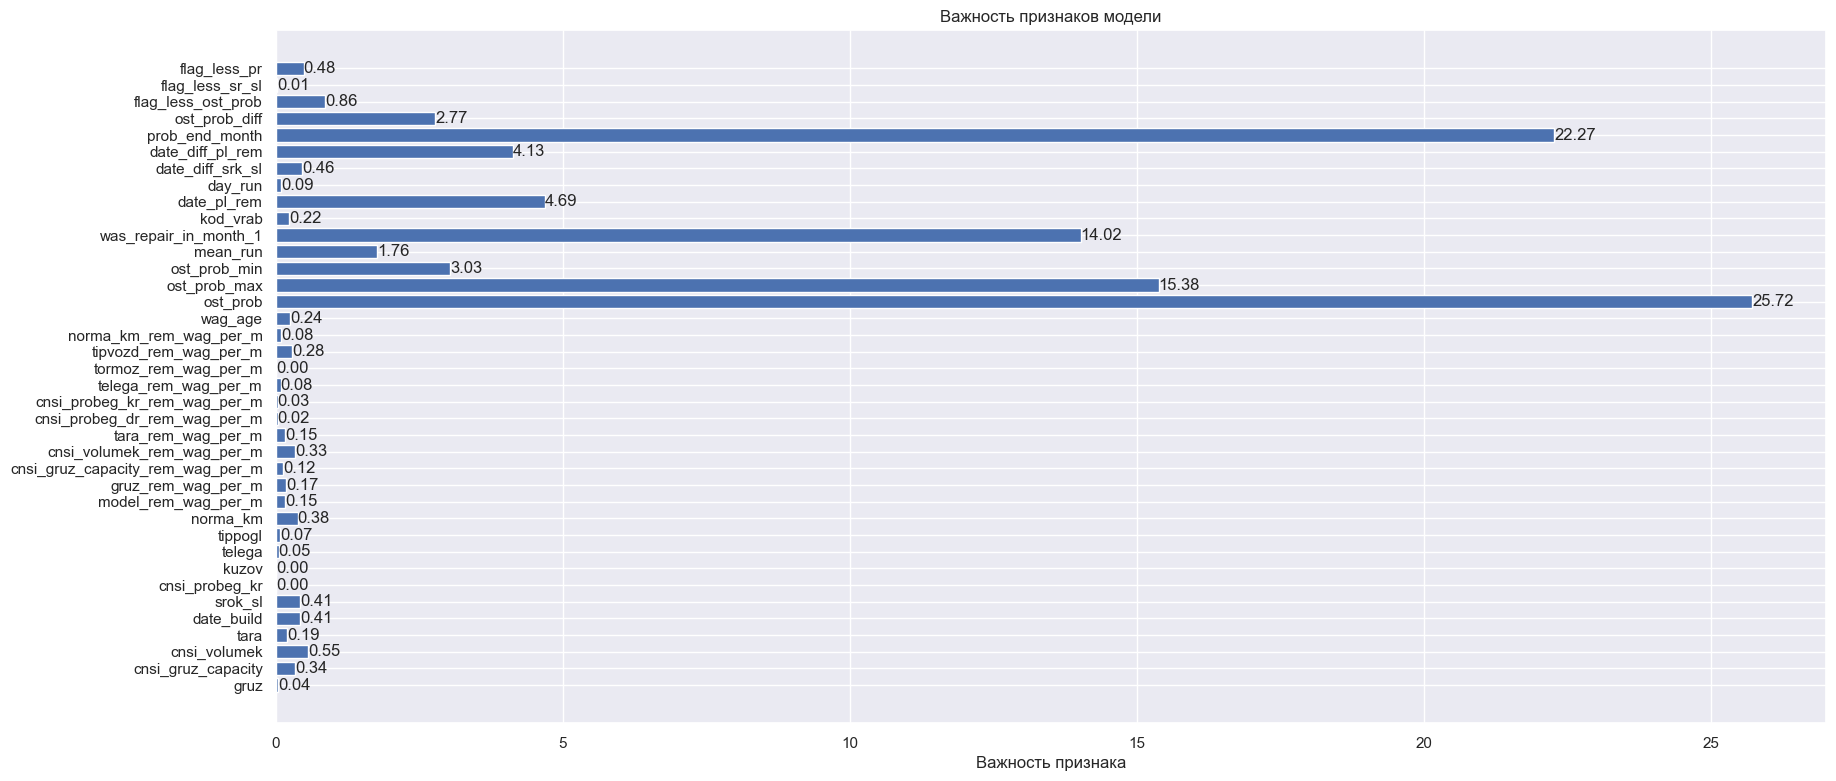

In [877]:
clf_ver2, feat_imp_list = fit_model_get_f1_fet_imp(X_train_v2, y_train_v2, ['model', 'tipvozd'])

cros_val_f1 0.6811644125386864


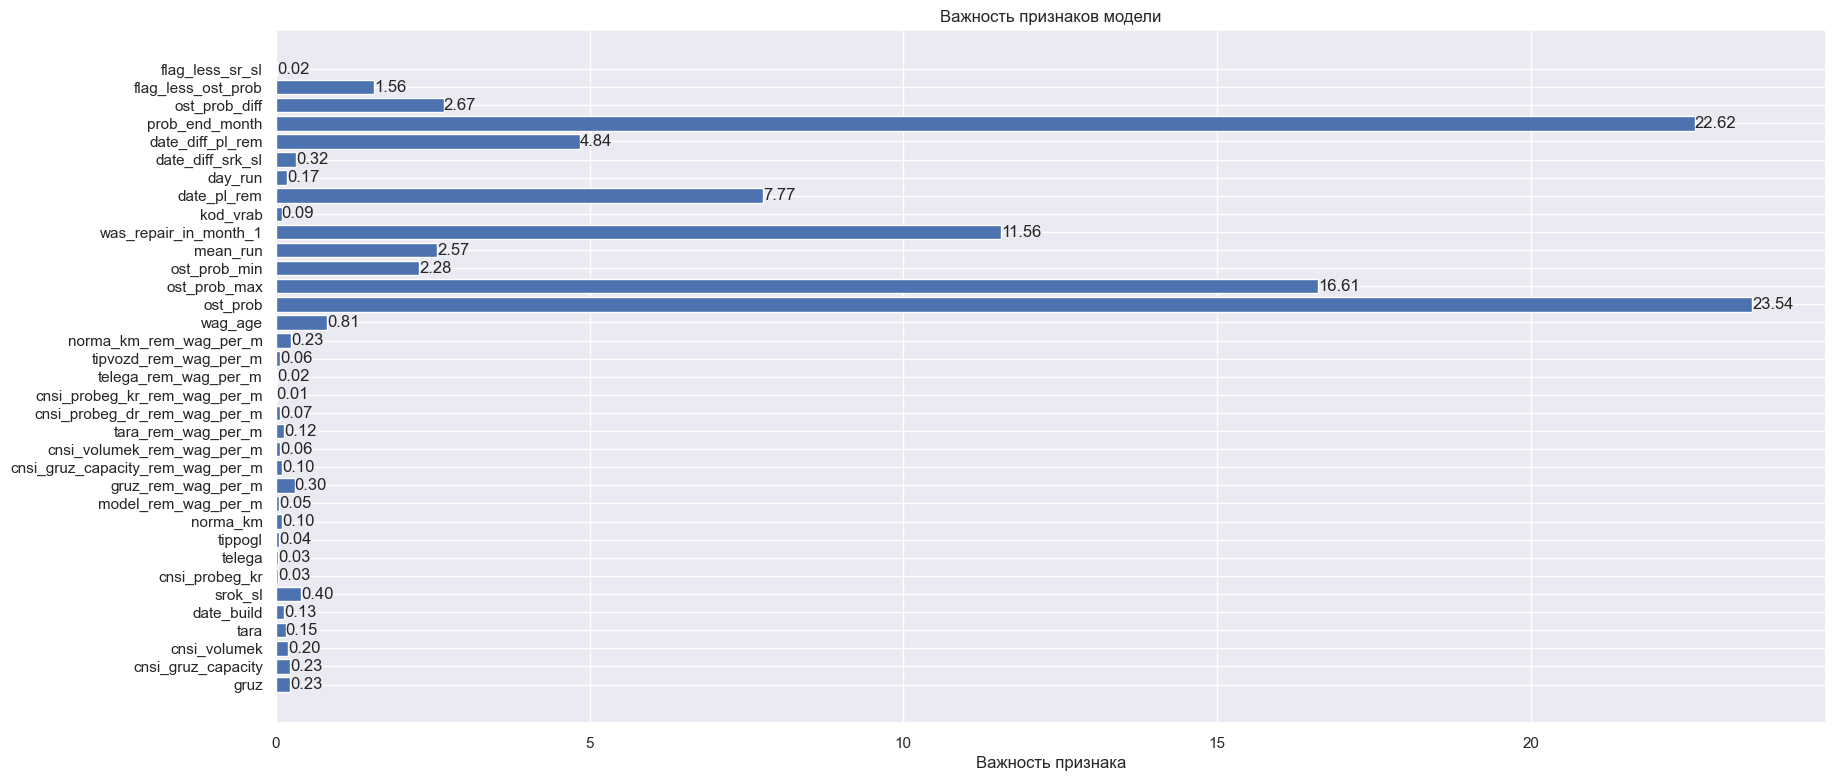

In [878]:
fit_model_get_f1_fet_imp(X_train_v2[feat_imp_list], y_train_v2, need_cat_feat=False);

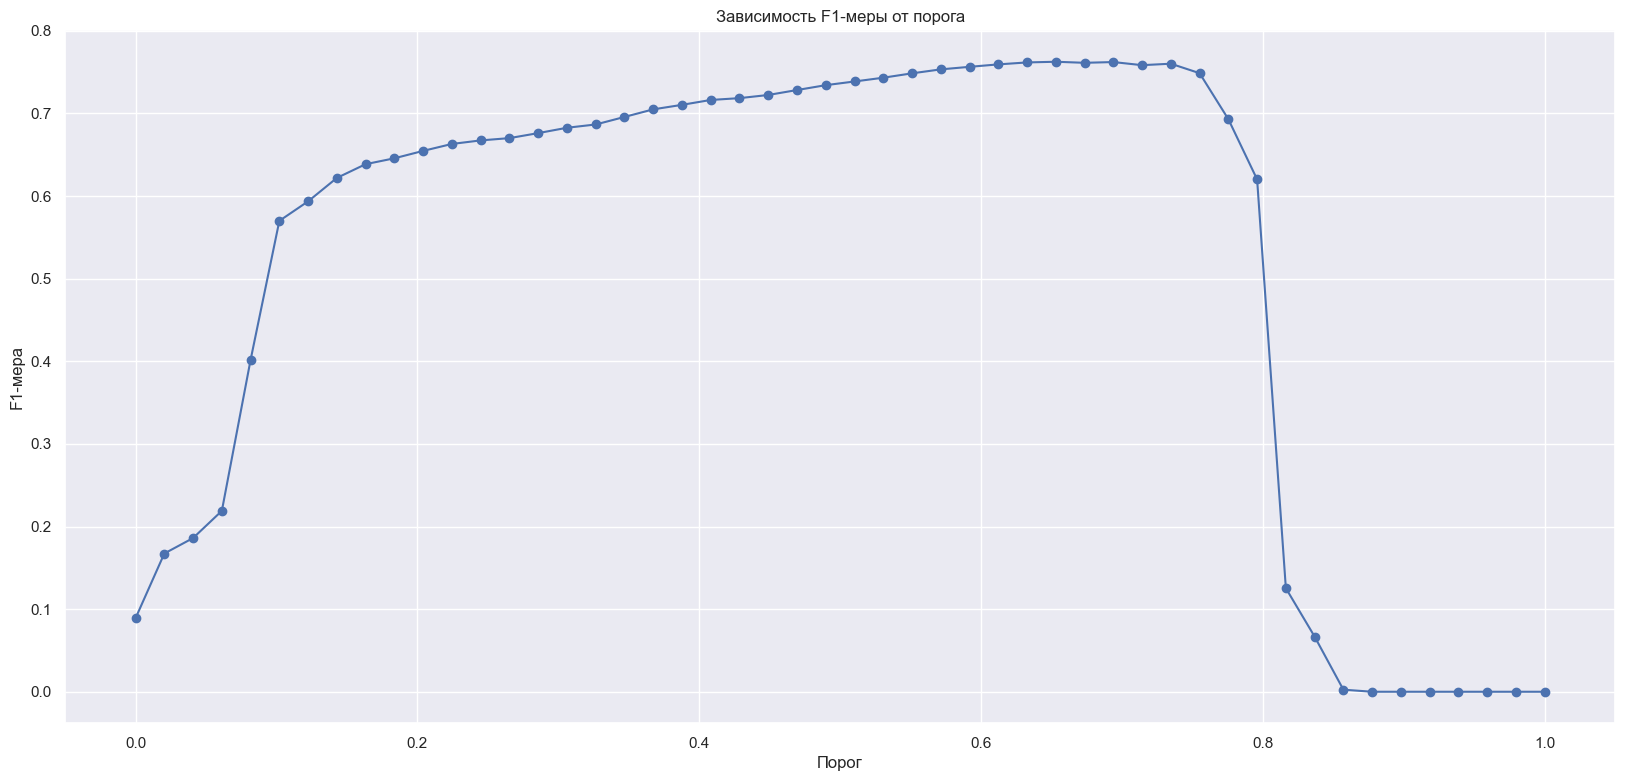

Лучший порог: 0.6530612244897959
f1 0.763


In [882]:
make_and_plot_thre(clf_ver2, X_train_v2, y_train_v2);

`0.672` без фич в Декабре

## C фильтром не были в прошлым месяце в ПР

### Данные

In [879]:
X_train_v2_filt = X_train_v2.query('was_repair_in_month_1 != 1')

In [880]:
y_train_v2_filt = y_train_v2[X_train_v2_filt.index]

### Обучение

Было `0.59` на Декабре без фич. `0.575` на Феврале с фичами

['model', 'tipvozd']
cros_val_f1 0.6737174538572894


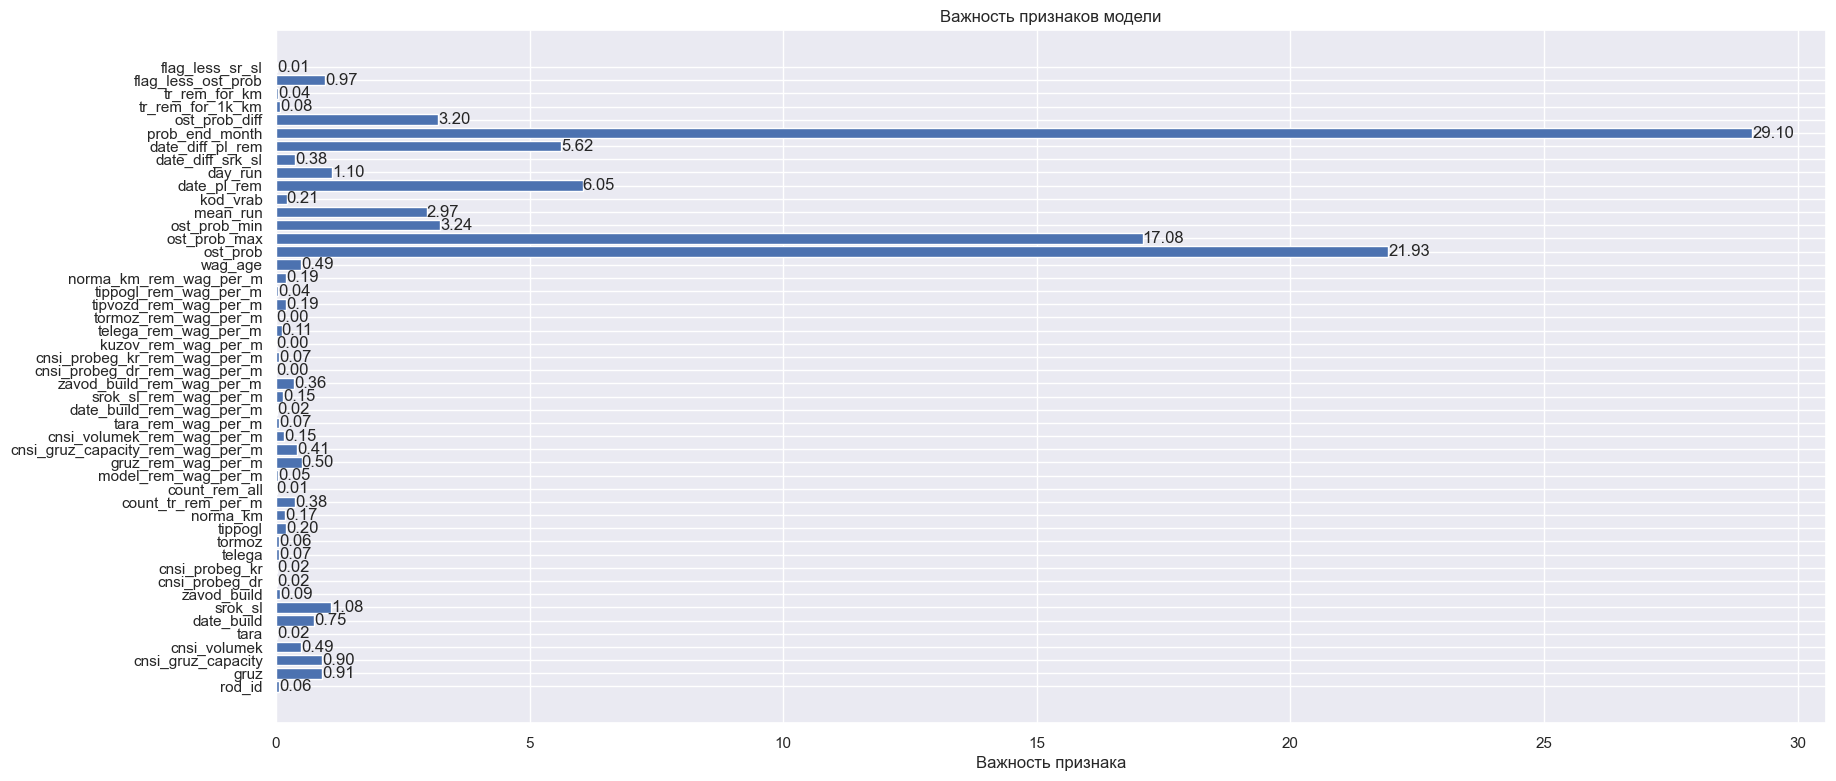

In [881]:
clf_ver2_filt, feat_imp_list_filt = fit_model_get_f1_fet_imp(X_train_v2_filt, y_train_v2_filt, ['model', 'tipvozd'])

#### Только важные

In [887]:
X_train_v2_filt_f = X_train_v2_filt[feat_imp_list_filt]

cros_val_f1 0.6787680680488481


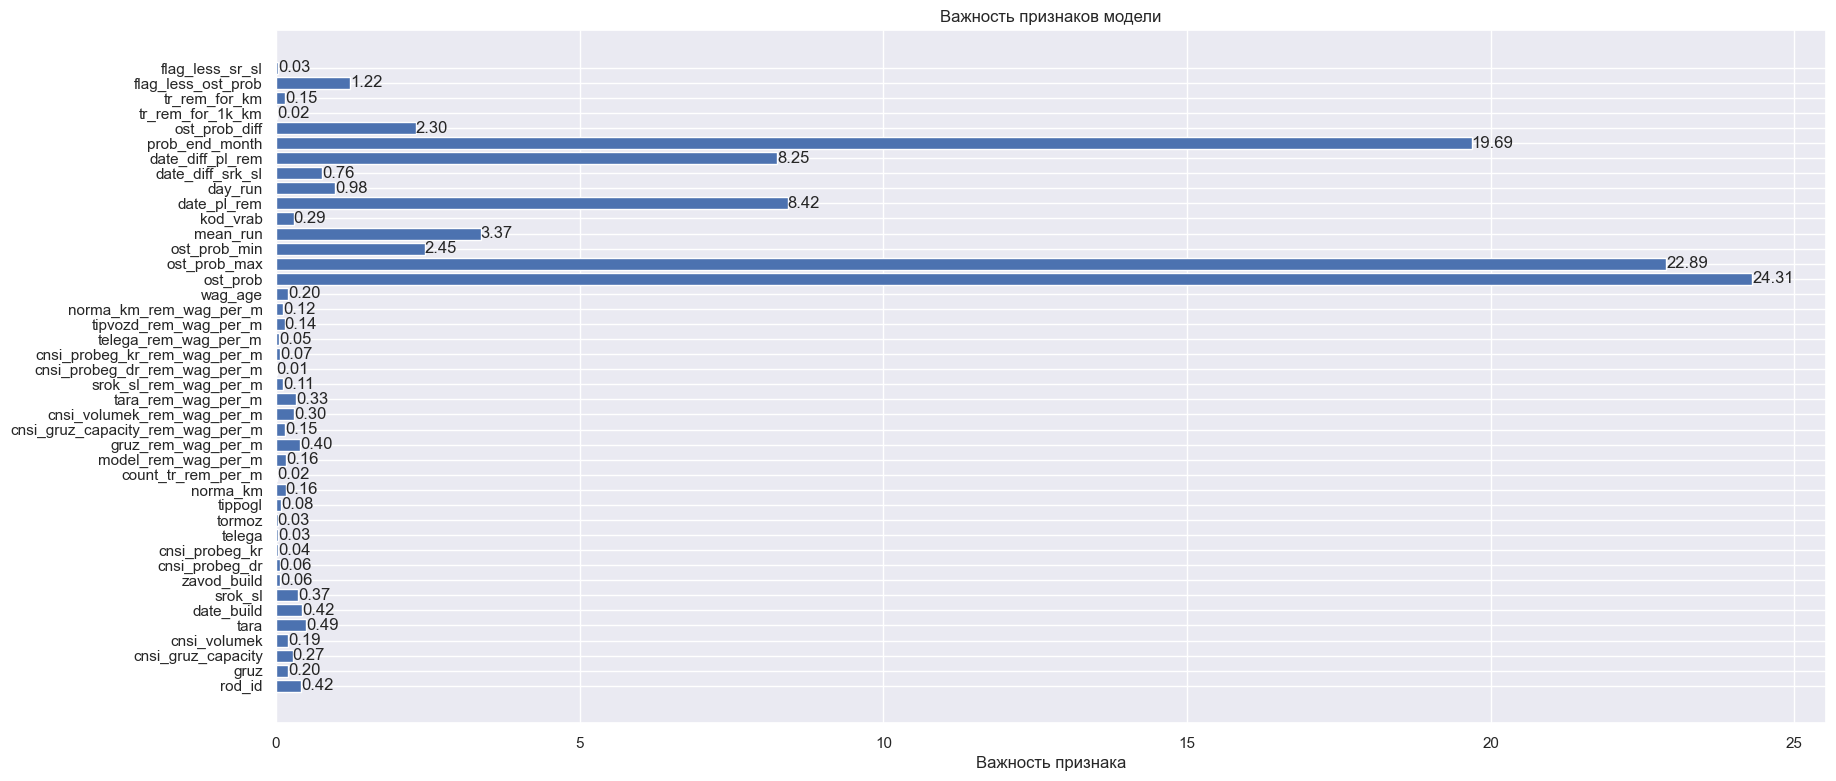

In [888]:
clf_ver2_filt_f, feat_imp_list_filt_f = fit_model_get_f1_fet_imp(X_train_v2_filt_f, y_train_v2_filt, need_cat_feat=False);

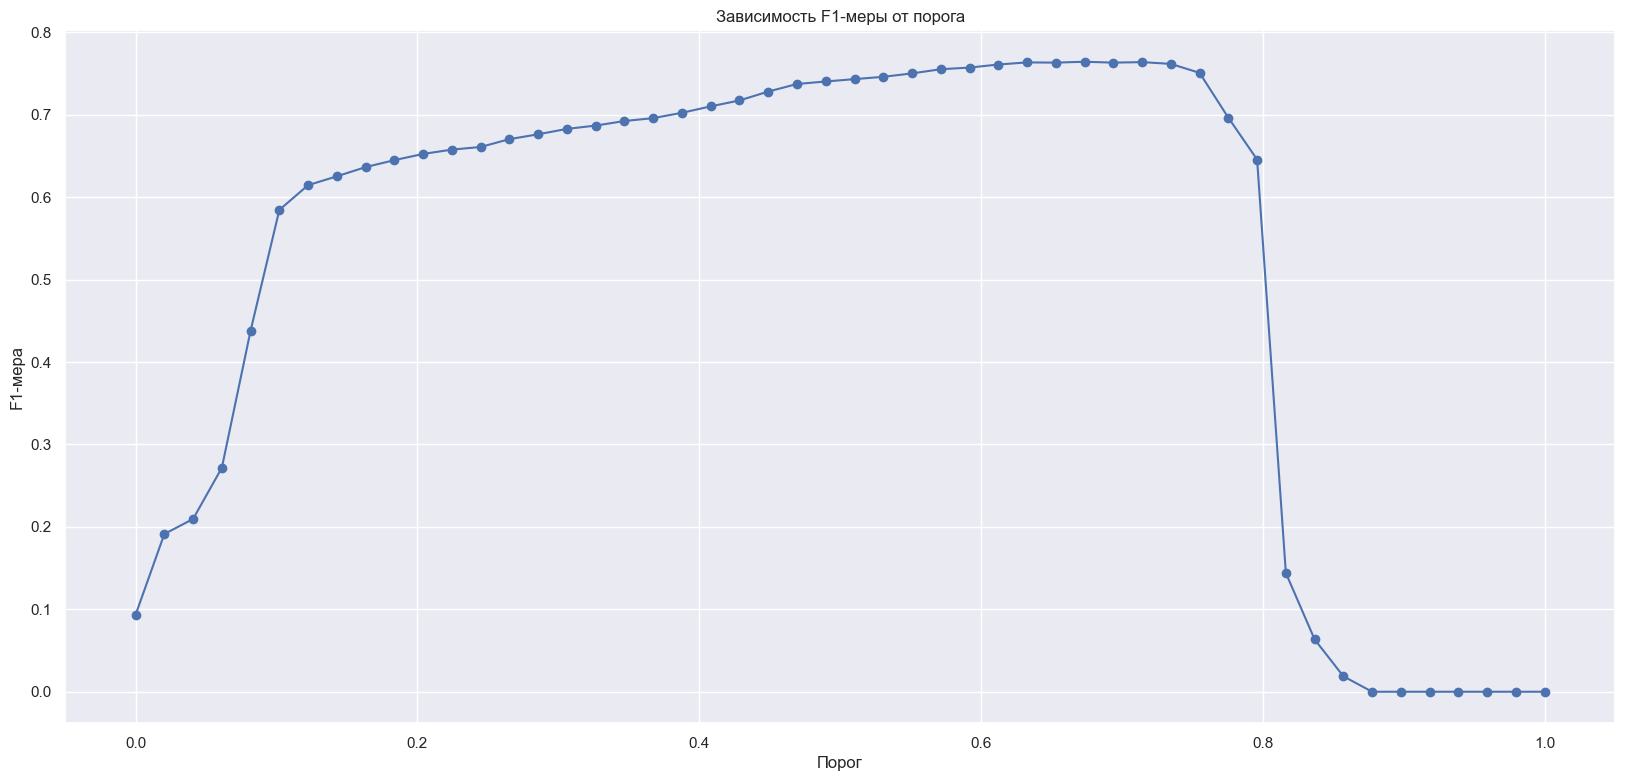

Лучший порог: 0.673469387755102
f1 0.764


In [889]:
make_and_plot_thre(clf_ver2_filt_f, X_train_v2_filt_f, y_train_v2_filt);

`0.672` без фич в Декабре, `0.765` - все признаки

### Отбор наиболее важных признаков

In [895]:
# Важность признаков
feature_importance = clf_ver2_filt_f.get_feature_importance(type='PredictionValuesChange')
feature_names = X_train_v2_filt_f.columns


important_features_gr_3 = [feature for feature, importance in zip(feature_names, feature_importance) if importance > 20]

In [896]:
important_features_gr_3

['ost_prob', 'ost_prob_max']

## Перебираем важные наборы признаков применяя к ним мат. операции

In [897]:
X_train_v2_filt_fet = perform_operations(X_train_v2_filt_f, 'ost_prob_max', 'ost_prob_min', ['+', '/', '*'])

In [898]:
for col1 in important_features_gr_3:
    for col2 in important_features_gr_3:
        if col1 != col2:
            X_train_v2_filt_fet = perform_operations(X_train_v2_filt_fet,  col1, col2)

In [899]:
X_train_v2_filt_fet.head()

rod_id  gruz  cnsi_gruz_capacity  cnsi_volumek  tara date_build  \
wagnum                                                                    
0            0   680                 680         122.0   244 1993-06-17   
1            0   680                 680         120.0   220 1994-07-09   
2            0   680                 680         122.0   252 1994-10-30   
3            0   680                 680         120.0   220 1993-10-04   
4            0   680                 680         120.0   235 1994-06-03   

          srok_sl  zavod_build  cnsi_probeg_dr  cnsi_probeg_kr  telega  \
wagnum                                                                   
0      2025-12-03            1             110             160       9   
1      2026-03-07            1             110             160       9   
2      2026-11-15            1             110             160       9   
3      2025-10-03            1             110             160       9   
4      2028-08-01           23             110             160       9   

        tormoz  tippogl  norma_km  count_tr_rem_per_m  count_rem_all  \
wagnum                                                                 
0            2       11    160000                 1.0            1.0   
1            2        1    160000                 0.0            0.0   
2            2       15    110000                 0.0            0.0   
3            2        1    110000                 2.0            2.0   
4            3        1    160000                 0.0            0.0   

        model_rem_wag_per_m  gruz_rem_wag_per_m  \
wagnum                                            
0                  1.861723            1.847788   
1                  2.000000            1.847788   
2                  0.000000            1.847788   
3                  2.000000            1.847788   
4                  0.000000            1.847788   

        cnsi_gruz_capacity_rem_wag_per_m  cnsi_volumek_rem_wag_per_m  \
wagnum                                                                 
0                               1.847788                    1.867778   
1                               1.847788                    1.500000   
2                               1.847788                    1.867778   
3                               1.847788                    1.500000   
4                               1.847788                    1.500000   

        tara_rem_wag_per_m  date_build_rem_wag_per_m  srok_sl_rem_wag_per_m  \
wagnum                                                                        
0                 2.021282                  1.000000               1.888889   
1                 1.918750                  0.000000               2.020833   
2                 2.000000                  1.833333               1.208333   
3                 1.918750                  2.000000               1.250000   
4                 2.085602                  2.000000               1.875000   

        zavod_build_rem_wag_per_m  cnsi_probeg_dr_rem_wag_per_m  \
wagnum                                                            
0                        1.907561                      1.966344   
1                        1.907561                      1.966344   
2                        1.907561                      1.966344   
3                        1.907561                      1.966344   
4                        0.000000                      1.966344   

        cnsi_probeg_kr_rem_wag_per_m  kuzov_rem_wag_per_m  \
wagnum                                                      
0                           1.976443             1.974733   
1                           1.976443             2.000000   
2                           1.976443             1.990959   
3                           1.976443             2.000000   
4                           1.976443             1.974733   

        telega_rem_wag_per_m  tormoz_rem_wag_per_m  tipvozd_rem_wag_per_m  \
wagnum                                                            

In [935]:
X_train_v2_filt_fet.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32301 entries, 0 to 33976
Data columns (total 59 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   rod_id                            32301 non-null  Int64         
 1   gruz                              32301 non-null  Int64         
 2   cnsi_gruz_capacity                32301 non-null  Int64         
 3   cnsi_volumek                      32301 non-null  Float64       
 4   tara                              32301 non-null  Int64         
 5   date_build                        32301 non-null  datetime64[ns]
 6   srok_sl                           32301 non-null  datetime64[ns]
 7   zavod_build                       32301 non-null  Int64         
 8   cnsi_probeg_dr                    32301 non-null  Int64         
 9   cnsi_probeg_kr                    32301 non-null  Int64         
 10  telega                            32301 non-null  I

In [402]:
# X_train_v2_filt_fet['rod_id'] = X_train_v2_filt_fet['rod_id'].astype(float)

`0.57` - февраль фичи

cros_val_f1 0.6947443325300947


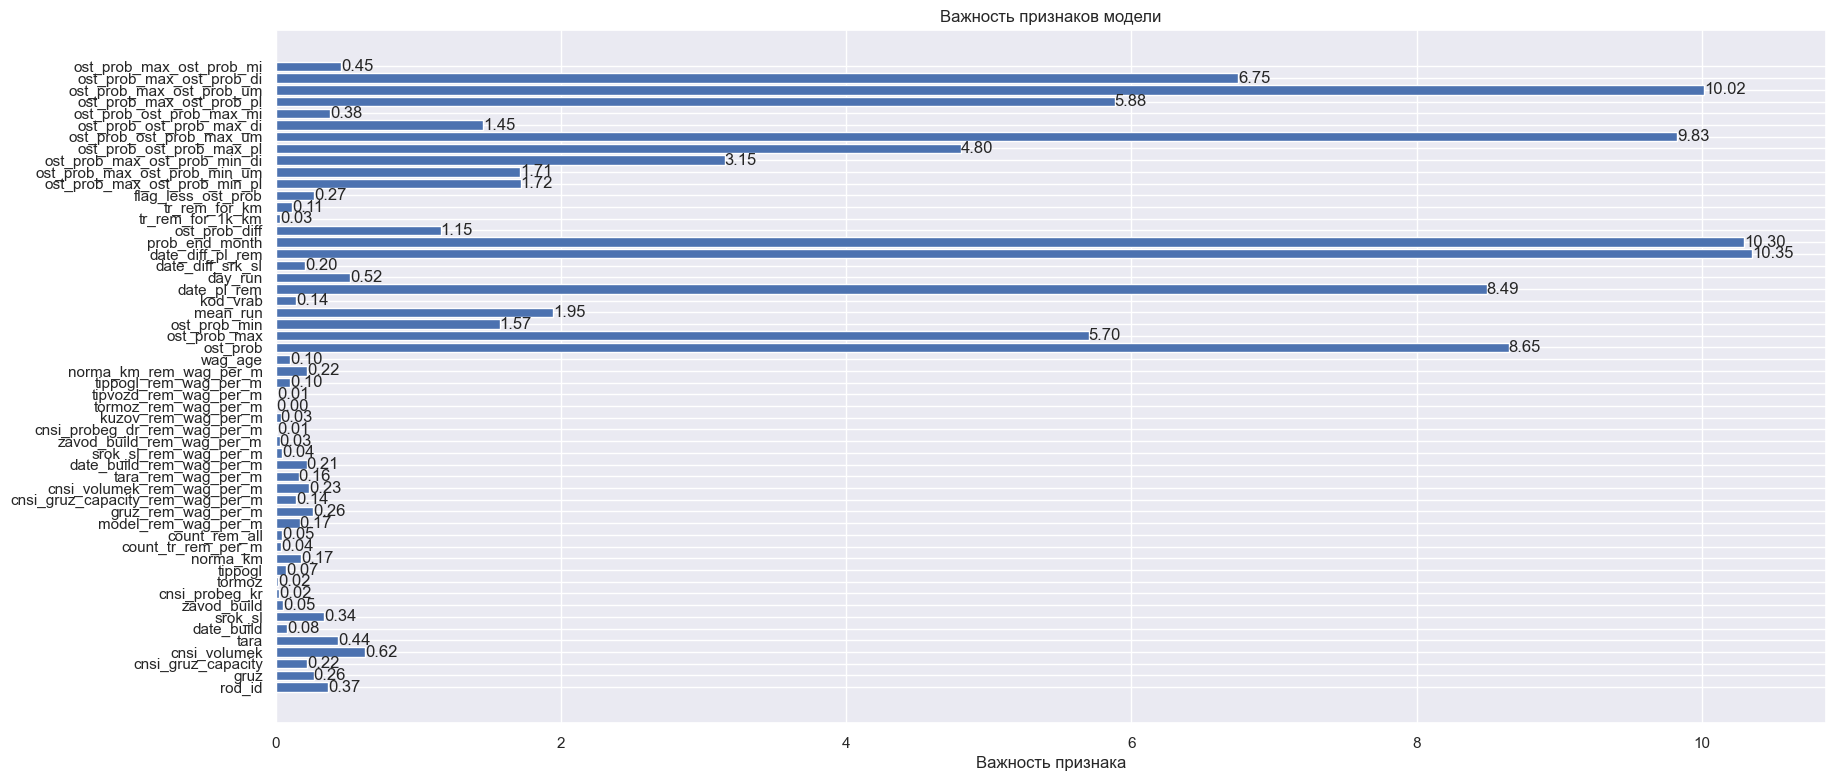

In [900]:
clf_ver2_filt_fet, feat_imp_list_filt_fet = fit_model_get_f1_fet_imp(X_train_v2_filt_fet, y_train_v2_filt, need_cat_feat=False);

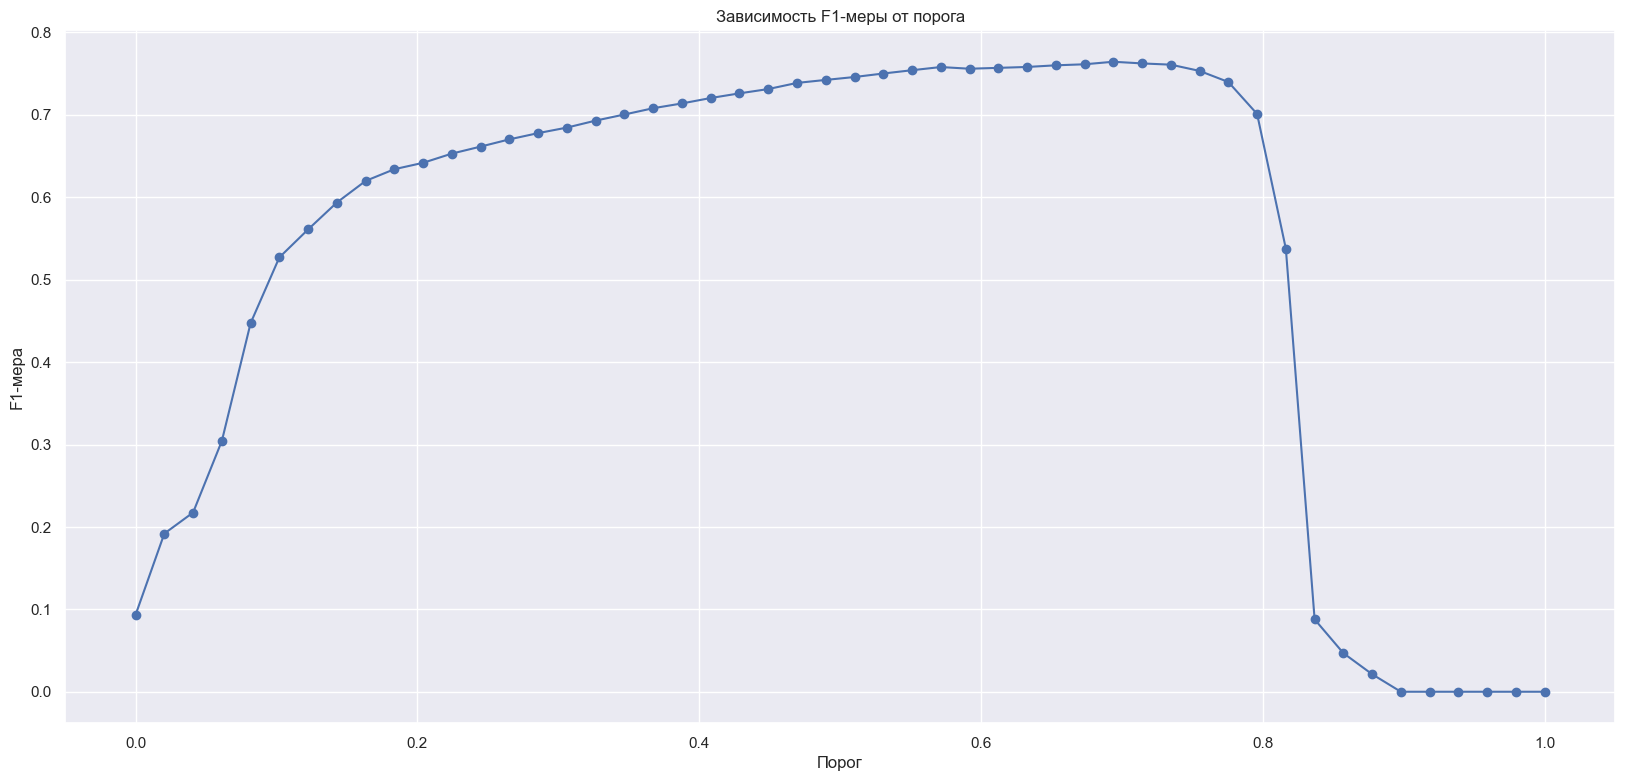

Лучший порог: 0.6938775510204082
f1 0.764


In [905]:
make_and_plot_thre(clf_ver2_filt_fet, X_train_v2_filt_fet, y_train_v2_filt);

## Обучение. Только важные признаки

Было `0.59` на Декабре

In [902]:
X_train_v2_filt_fet_f = X_train_v2_filt_fet[feat_imp_list_filt_fet]

cros_val_f1 0.6962802514139333


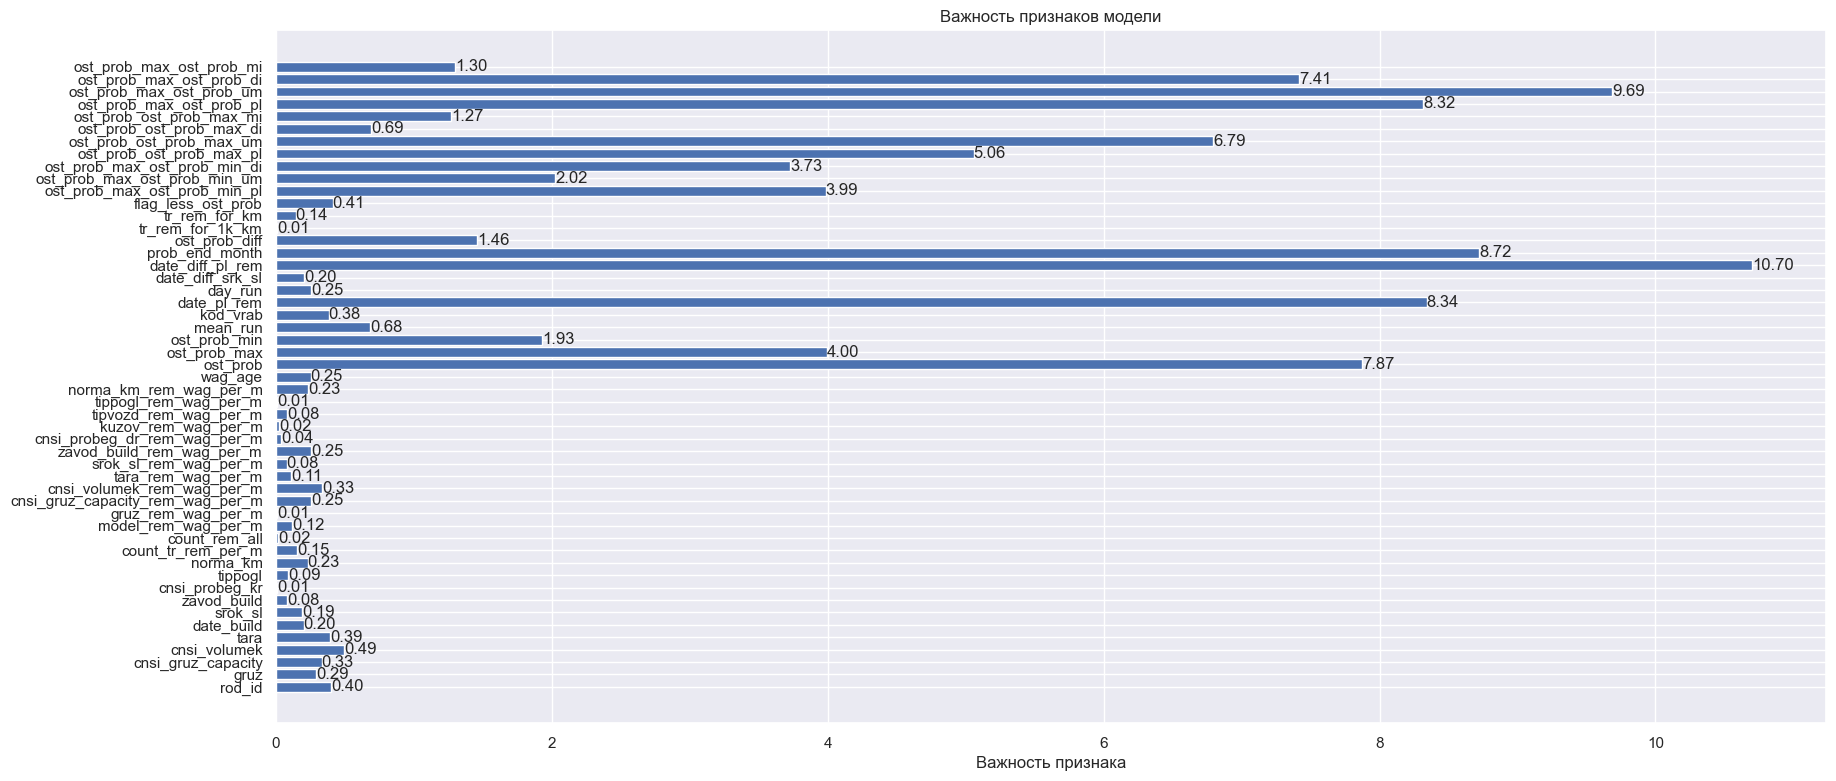

In [903]:
clf_ver2_filt_imp , feat_imp_list_filt_imp = fit_model_get_f1_fet_imp(X_train_v2_filt_fet_f, y_train_v2_filt, need_cat_feat=False, bal='Balanced');

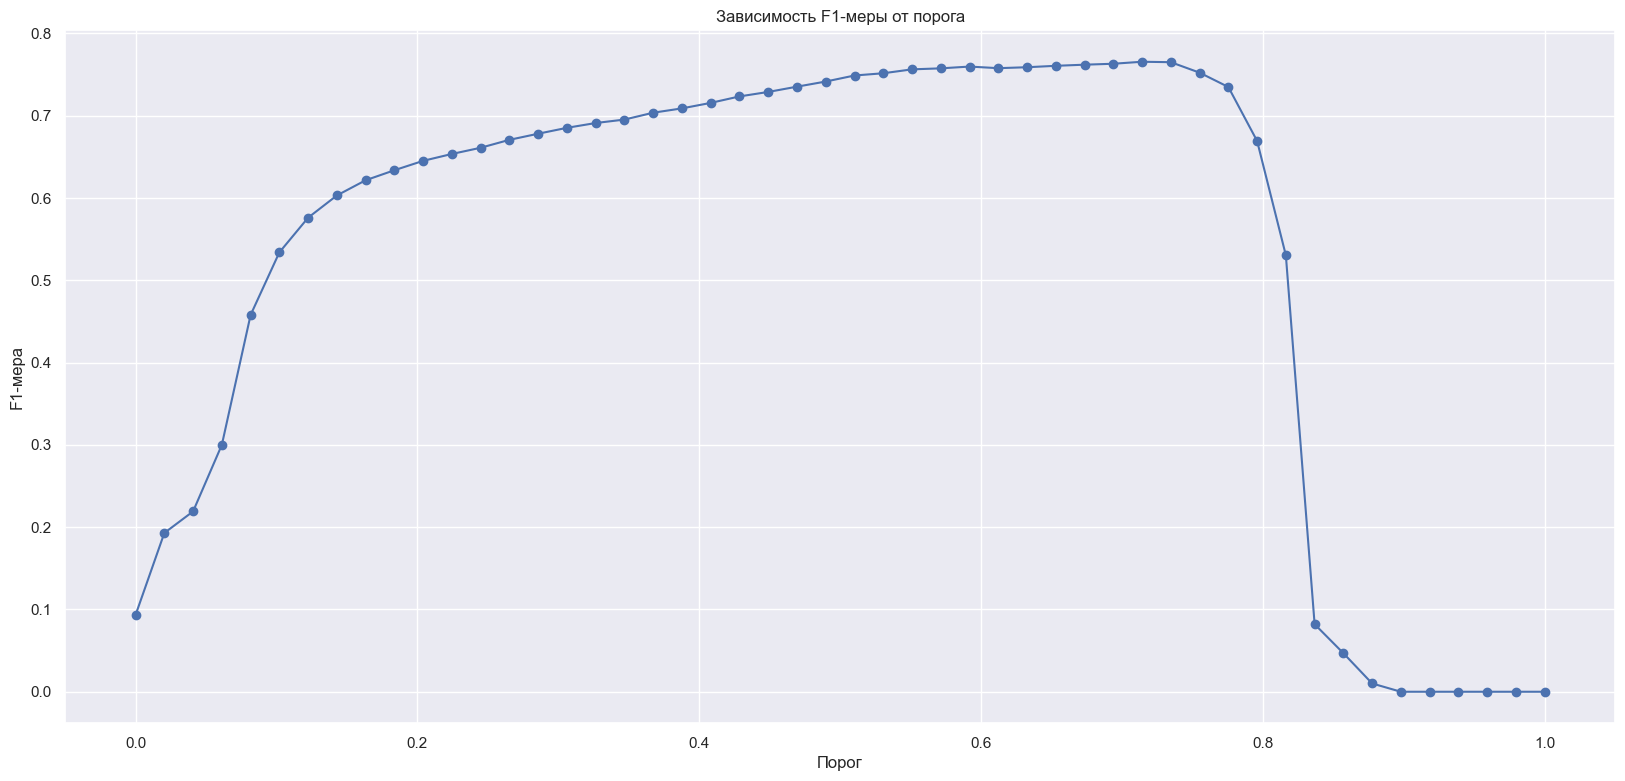

Лучший порог: 0.7142857142857142
f1 0.766


In [906]:
best_threshold_month_v2, y_pred_binary_v2, y_pred_tr_v2 = make_and_plot_thre(clf_ver2_filt_imp, X_train_v2_filt_fet_f, y_train_v2_filt);

## Сохраняем ответы

In [928]:
X_train_v2_filt_fet_f.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32301 entries, 0 to 33976
Data columns (total 54 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   rod_id                            32301 non-null  Int64         
 1   gruz                              32301 non-null  Int64         
 2   cnsi_gruz_capacity                32301 non-null  Int64         
 3   cnsi_volumek                      32301 non-null  Float64       
 4   tara                              32301 non-null  Int64         
 5   date_build                        32301 non-null  datetime64[ns]
 6   srok_sl                           32301 non-null  datetime64[ns]
 7   zavod_build                       32301 non-null  Int64         
 8   cnsi_probeg_kr                    32301 non-null  Int64         
 9   tormoz                            32301 non-null  Int64         
 10  tippogl                           32301 non-null  I

In [907]:
df_pred_month_v2 =\
pd.DataFrame(y_pred_binary_v2, columns=['target_month'], index=y_train_v2_filt.index)

In [908]:
df_pred_month_v2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32301 entries, 0 to 33976
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   target_month  32301 non-null  int32
dtypes: int32(1)
memory usage: 410.1 KB


In [910]:
df_pred_month_v2['target_month'].value_counts()

0    30520
1     1781
Name: target_month, dtype: int64

# target_day. target_month как фильтр. Важность признаков, f1, ver. 3

### Данные

In [929]:
X_train_v2_day =\
X_train_v2_filt_fet.copy()

In [930]:
X_train_v2_day =\
X_train_v2_day.join(df_pred_month_v2)

In [931]:
X_train_v2_day =\
X_train_v2_day.query('target_month == 1').drop(columns=['target_month'])

In [932]:
X_train_v2_day.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1781 entries, 91 to 33972
Data columns (total 59 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   rod_id                            1781 non-null   Int64         
 1   gruz                              1781 non-null   Int64         
 2   cnsi_gruz_capacity                1781 non-null   Int64         
 3   cnsi_volumek                      1781 non-null   Float64       
 4   tara                              1781 non-null   Int64         
 5   date_build                        1781 non-null   datetime64[ns]
 6   srok_sl                           1781 non-null   datetime64[ns]
 7   zavod_build                       1781 non-null   Int64         
 8   cnsi_probeg_dr                    1781 non-null   Int64         
 9   cnsi_probeg_kr                    1781 non-null   Int64         
 10  telega                            1781 non-null   I

In [933]:
y_train_v2_day =\
y_train_v2_filt[y_train_v2_filt.index.isin(X_train_v2_day.index)]

In [934]:
y_train_v2_day.info()

<class 'pandas.core.series.Series'>
Index: 1781 entries, 91 to 33972
Series name: target_month
Non-Null Count  Dtype
--------------  -----
1781 non-null   Int64
dtypes: Int64(1)
memory usage: 31.3 KB


### Обучение

cros_val_f1 0.8127310738198158


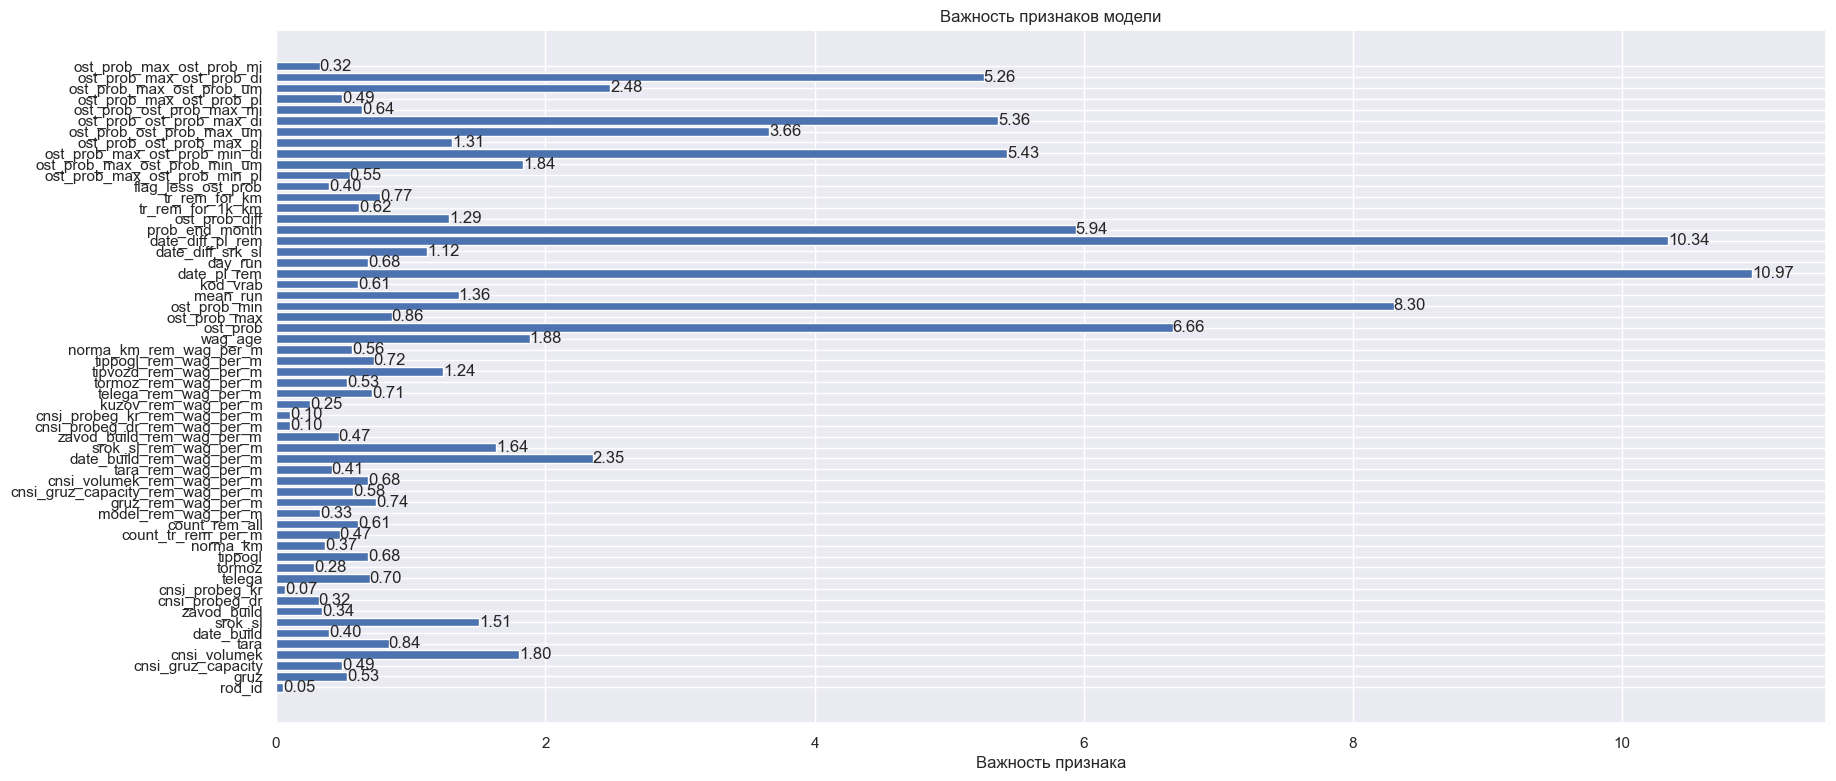

In [939]:
clf_ver2_filt_day, feat_imp_list_filt_day = fit_model_get_f1_fet_imp(X_train_v2_day, y_train_v2_day, need_cat_feat=False, bal='Balanced')

In [940]:
pred_day = clf_ver2_filt_day.predict(X_train_v2_day)

In [ ]:
pred_day.sum()

1404

### Только важные

In [943]:
X_train_v2_day_f = X_train_v2_day[feat_imp_list_filt_day]

cros_val_f1 0.8132221008555762


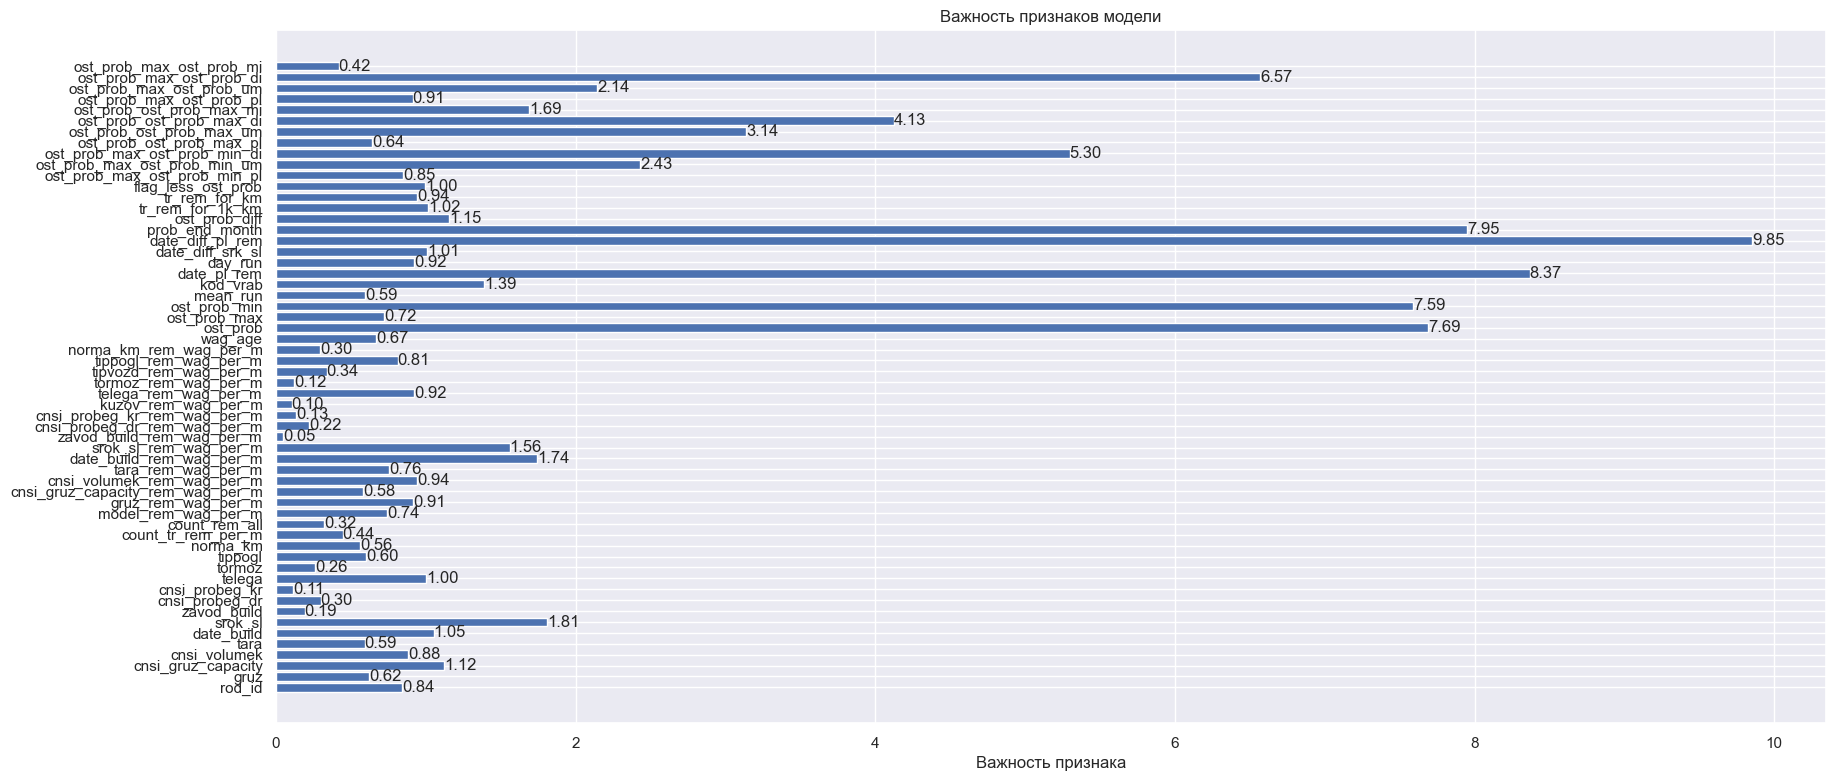

In [946]:
clf_ver2_filt_day_f, feat_imp_list_filt_day_f = fit_model_get_f1_fet_imp(X_train_v2_day_f, y_train_v2_day, need_cat_feat=False, bal='Balanced')

### Порог

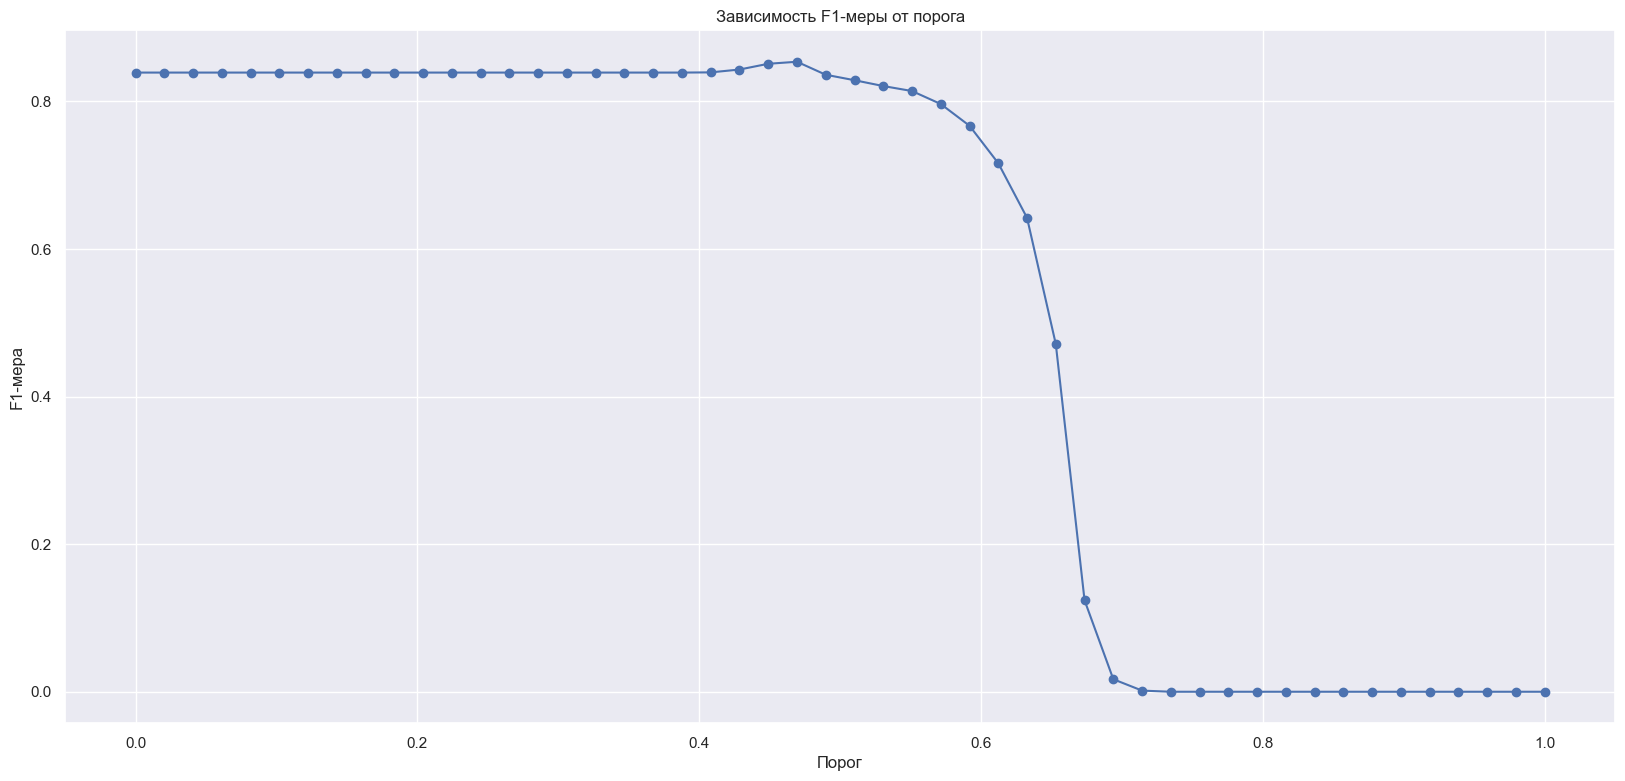

Лучший порог: 0.4693877551020408
f1 0.854


In [947]:
best_threshold_month_v2_day, y_pred_binary_v2_day, y_pred_tr_v2_day = make_and_plot_thre(clf_ver2_filt_day_f, X_train_v2_day_f, y_train_v2_day)

In [948]:
X_train_v2_day_f.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1781 entries, 91 to 33972
Data columns (total 58 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   rod_id                            1781 non-null   Int64         
 1   gruz                              1781 non-null   Int64         
 2   cnsi_gruz_capacity                1781 non-null   Int64         
 3   cnsi_volumek                      1781 non-null   Float64       
 4   tara                              1781 non-null   Int64         
 5   date_build                        1781 non-null   datetime64[ns]
 6   srok_sl                           1781 non-null   datetime64[ns]
 7   zavod_build                       1781 non-null   Int64         
 8   cnsi_probeg_dr                    1781 non-null   Int64         
 9   cnsi_probeg_kr                    1781 non-null   Int64         
 10  telega                            1781 non-null   I

In [950]:
df_pred_day_v2 =\
pd.DataFrame(y_pred_binary_v2_day, columns=['target_day'], index=y_train_v2_day.index)

In [951]:
df_pred_day_v2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1781 entries, 91 to 33972
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   target_day  1781 non-null   int32
dtypes: int32(1)
memory usage: 22.6 KB


In [952]:
df_pred_day_v2['target_day'].value_counts()

1    1576
0     205
Name: target_day, dtype: int64

# Дозагрузка данных. Предсказания arima

In [1085]:
df_arima_preds =\
pd.read_csv('./train_arima_forecast_prob_end_month')

In [1086]:
df_arima_preds = df_arima_preds.drop(columns=['Unnamed: 0']).set_index('wagnum')

In [1087]:
df_arima_preds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32970 entries, 33361 to 33350
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   forecast_30  32970 non-null  float64
dtypes: float64(1)
memory usage: 515.2 KB


In [1088]:
X_train_v2 =\
X_train_v2.join(df_arima_preds, how='left')

In [1089]:
X_train_v2['forecast_30'] = X_train_v2['forecast_30'].fillna(X_train_v2['forecast_30'].mean())

In [1090]:
X_train_v2.rename(columns={'forecast_30': 'forecast_prob_end_month'}, inplace=True)

In [1091]:
X_train_v2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33977 entries, 0 to 33976
Data columns (total 65 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   model                             33977 non-null  string        
 1   rod_id                            33977 non-null  Int64         
 2   gruz                              33977 non-null  Int64         
 3   cnsi_gruz_capacity                33977 non-null  Int64         
 4   cnsi_volumek                      33977 non-null  Float64       
 5   tara                              33977 non-null  Int64         
 6   date_build                        33977 non-null  datetime64[ns]
 7   srok_sl                           33977 non-null  datetime64[ns]
 8   zavod_build                       33977 non-null  Int64         
 9   cnsi_probeg_dr                    33977 non-null  Int64         
 10  cnsi_probeg_kr                    33977 non-null  I

# target_month. Важность признаков, f1, ver. 4

## C фильтром не были в прошлым месяце в ПР

### Данные

In [1092]:
X_train_v2_filt = X_train_v2.query('was_repair_in_month_1 != 1')

In [1093]:
y_train_v2_filt = y_train_v2[X_train_v2_filt.index]

### Обучение

Было `0.59` на Декабре без фич. `0.575` на Феврале с фичами, `0.67` без аримы

['model', 'tipvozd']
cros_val_f1 0.8763905174033619


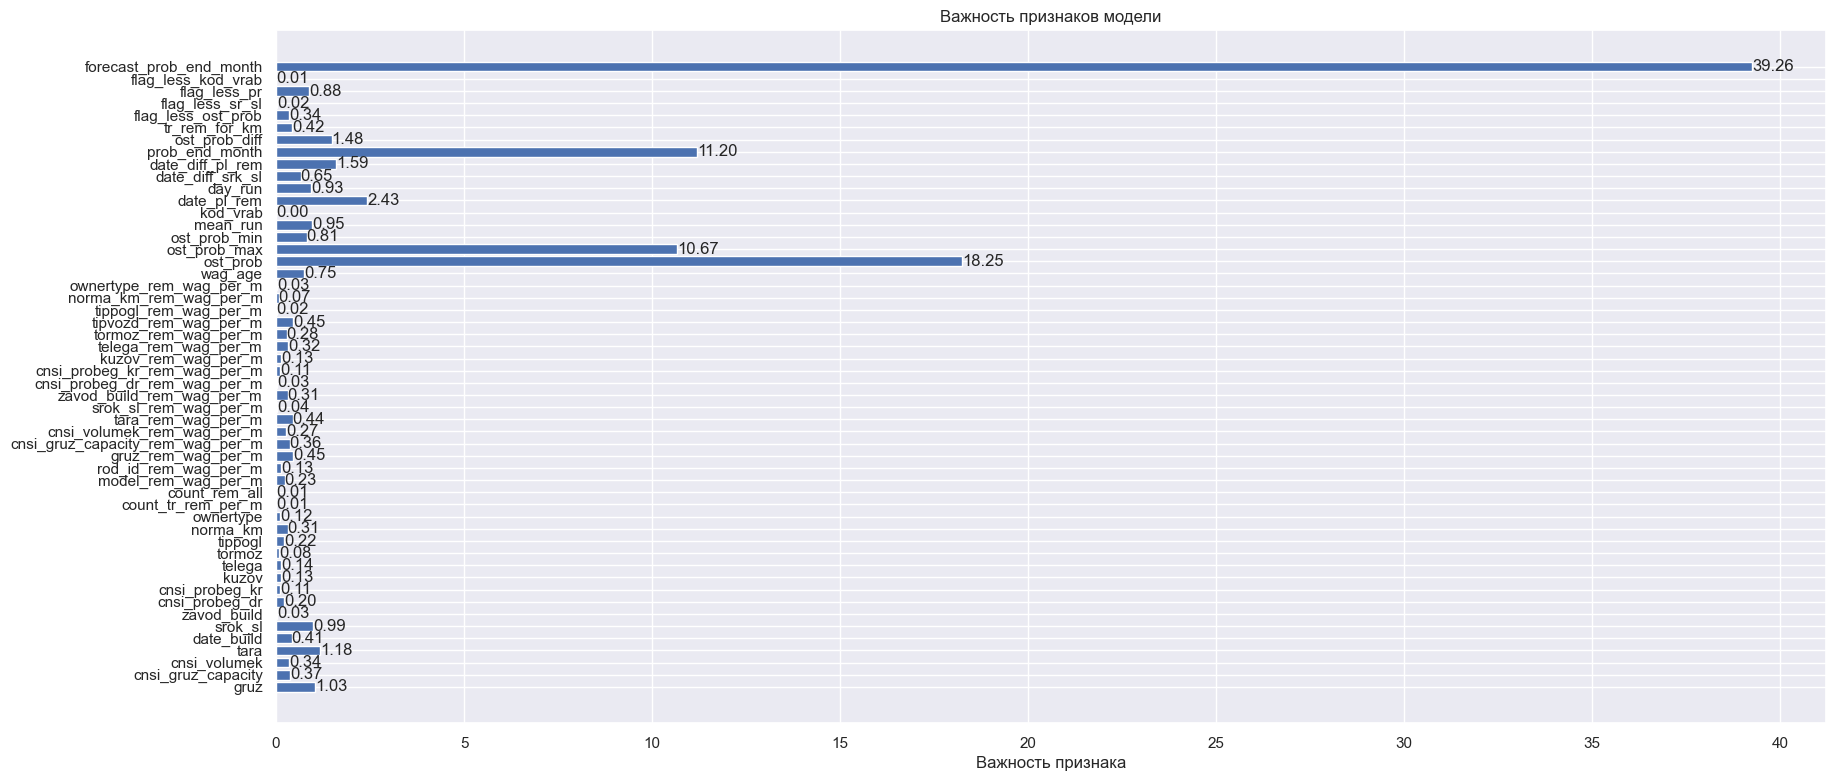

In [1094]:
clf_ver2_filt, feat_imp_list_filt = fit_model_get_f1_fet_imp(X_train_v2_filt, y_train_v2_filt, ['model', 'tipvozd'])

#### Только важные

In [1095]:
X_train_v2_filt_f = X_train_v2_filt[feat_imp_list_filt]

cros_val_f1 0.8770233494835624


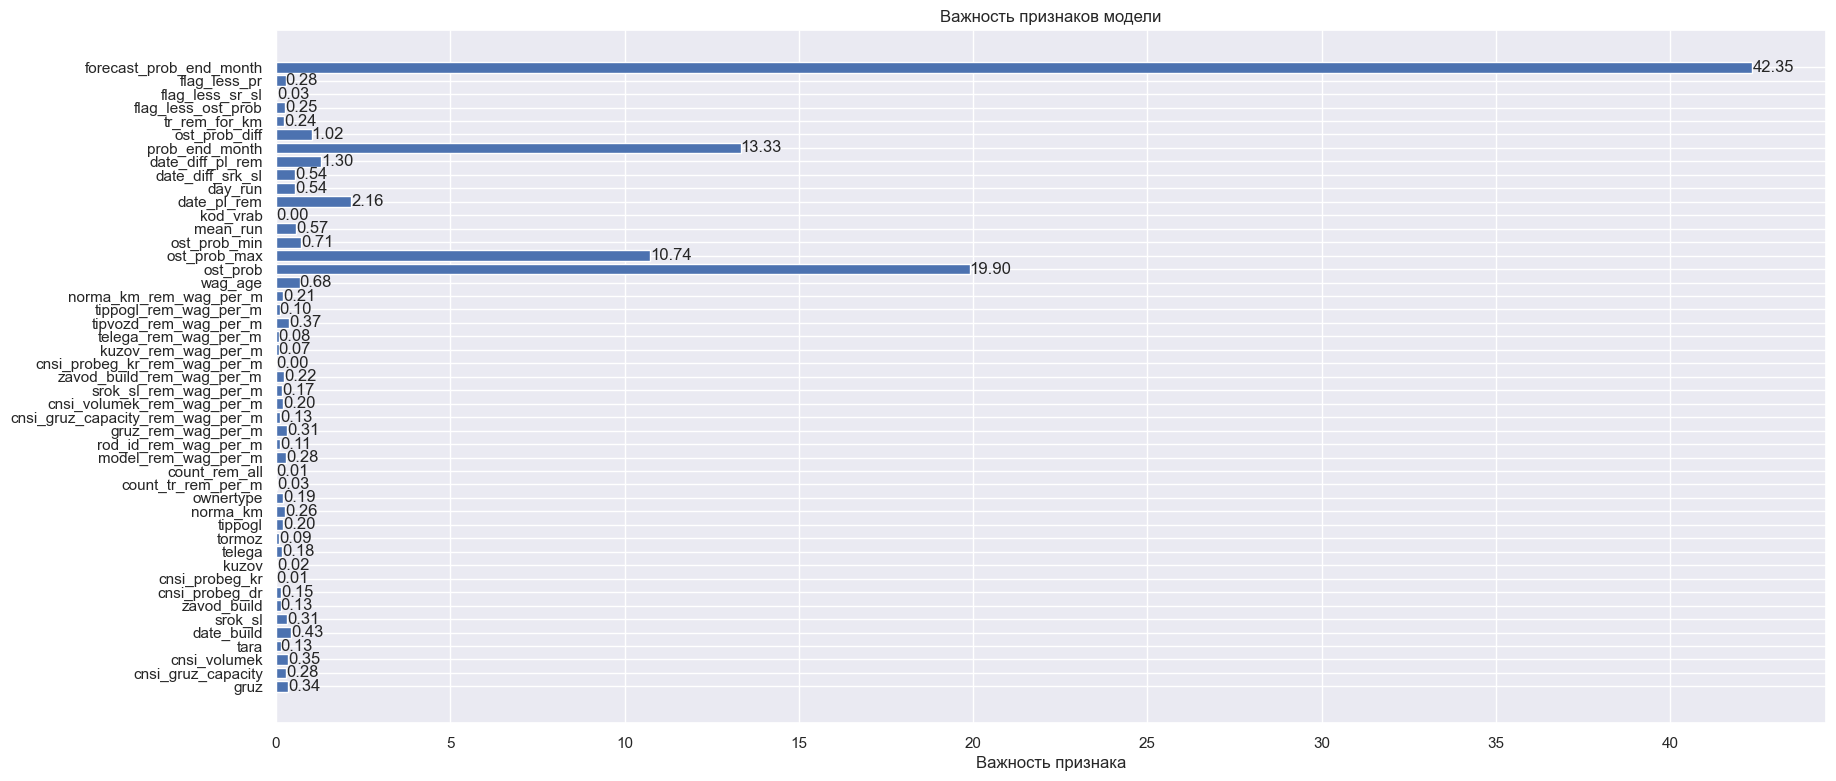

In [1096]:
clf_ver2_filt_f, feat_imp_list_filt_f = fit_model_get_f1_fet_imp(X_train_v2_filt_f, y_train_v2_filt, need_cat_feat=False);

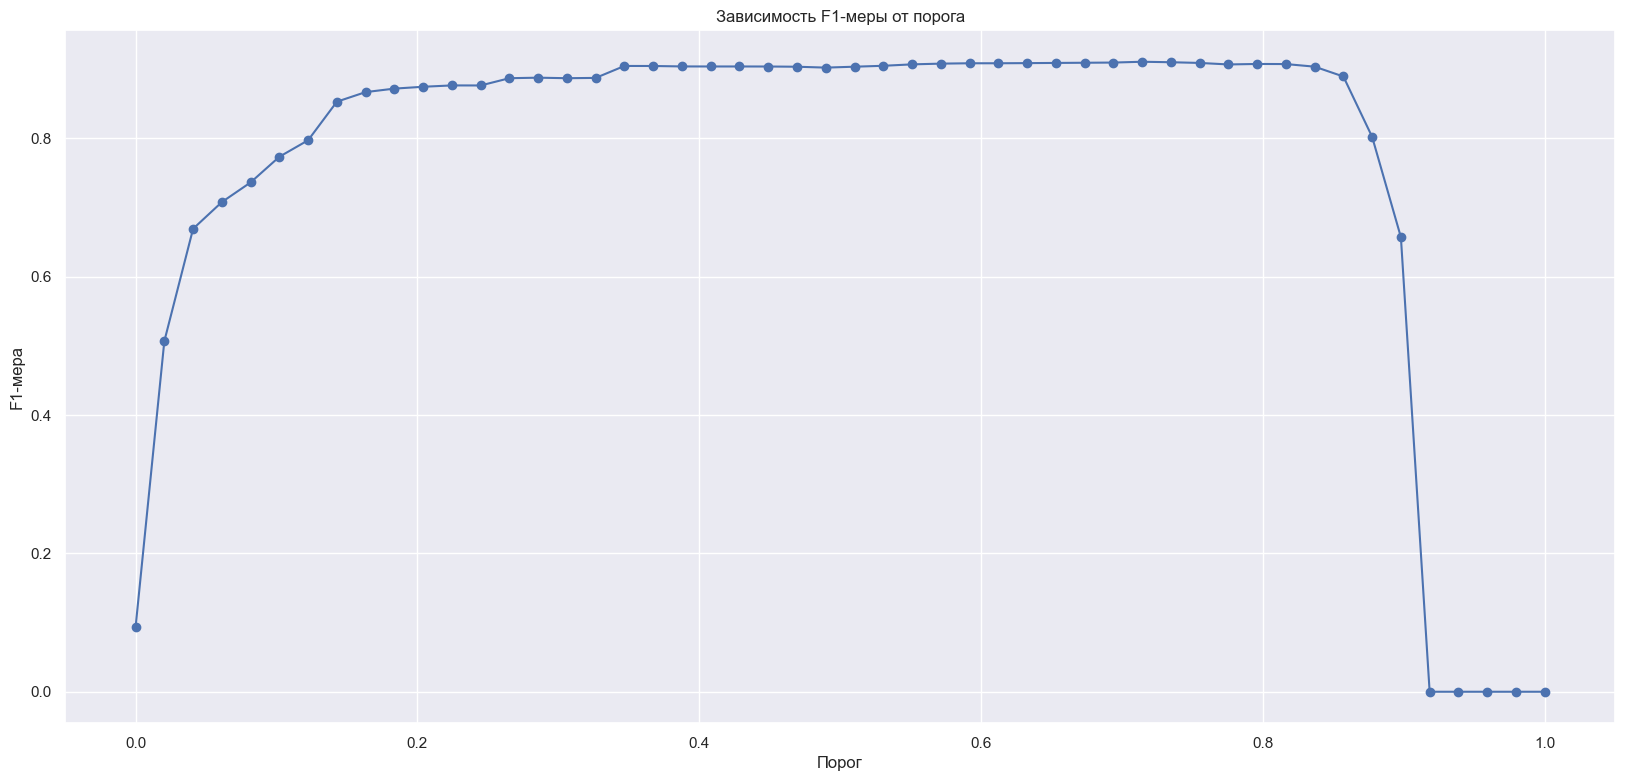

Лучший порог: 0.7142857142857142
f1 0.911


In [1097]:
make_and_plot_thre(clf_ver2_filt_f, X_train_v2_filt_f, y_train_v2_filt);

`0.672` без фич в Декабре, `0.765` - все признаки

### Отбор наиболее важных признаков

In [1100]:
# Важность признаков
feature_importance = clf_ver2_filt_f.get_feature_importance(type='PredictionValuesChange')
feature_names = X_train_v2_filt_f.columns


important_features_gr_3 = [feature for feature, importance in zip(feature_names, feature_importance) if importance > 13]

In [1101]:
important_features_gr_3

['ost_prob', 'prob_end_month', 'forecast_prob_end_month']

## Перебираем важные наборы признаков применяя к ним мат. операции

In [1102]:
X_train_v2_filt_fet = perform_operations(X_train_v2_filt_f, 'ost_prob_max', 'ost_prob_min', ['+', '/', '*'])

In [1103]:
for col1 in important_features_gr_3:
    for col2 in important_features_gr_3:
        if col1 != col2:
            X_train_v2_filt_fet = perform_operations(X_train_v2_filt_fet,  col1, col2)

In [1104]:
X_train_v2_filt_fet.head()

gruz  cnsi_gruz_capacity  cnsi_volumek  tara date_build    srok_sl  \
wagnum                                                                       
0        680                 680         122.0   244 1993-06-17 2025-12-03   
1        680                 680         120.0   220 1994-07-09 2026-03-07   
2        680                 680         122.0   252 1994-10-30 2026-11-15   
3        680                 680         120.0   220 1993-10-04 2025-10-03   
4        680                 680         120.0   235 1994-06-03 2028-08-01   

        zavod_build  cnsi_probeg_dr  cnsi_probeg_kr  kuzov  telega  tormoz  \
wagnum                                                                       
0                 1             110             160      2       9       2   
1                 1             110             160      1       9       2   
2                 1             110             160     22       9       2   
3                 1             110             160      1       9       2   
4                23             110             160      2       9       3   

        tippogl  norma_km  ownertype  count_tr_rem_per_m  count_rem_all  \
wagnum                                                                    
0            11    160000          0                 1.0            1.0   
1             1    160000          0                 0.0            0.0   
2            15    110000          0                 0.0            0.0   
3             1    110000          0                 2.0            2.0   
4             1    160000          0                 0.0            0.0   

        model_rem_wag_per_m  rod_id_rem_wag_per_m  gruz_rem_wag_per_m  \
wagnum                                                                  
0                  1.861723              1.893871            1.847788   
1                  2.000000              1.893871            1.847788   
2                  0.000000              1.893871            1.847788   
3                  2.000000              1.893871            1.847788   
4                  0.000000              1.893871            1.847788   

        cnsi_gruz_capacity_rem_wag_per_m  cnsi_volumek_rem_wag_per_m  \
wagnum                                                                 
0                               1.847788                    1.867778   
1                               1.847788                    1.500000   
2                               1.847788                    1.867778   
3                               1.847788                    1.500000   
4                               1.847788                    1.500000   

        tara_rem_wag_per_m  srok_sl_rem_wag_per_m  zavod_build_rem_wag_per_m  \
wagnum                                                                         
0                 2.021282               1.888889                   1.907561   
1                 1.918750               2.020833                   1.907561   
2                 2.000000               1.208333                   1.907561   
3                 1.918750               1.250000                   1.907561   
4                 2.085602               1.875000                   0.000000   

        cnsi_probeg_dr_rem_wag_per_m  cnsi_probeg_kr_rem_wag_per_m  \
wagnum                                                               
0                           1.966344                      1.976443   
1                           1.966344                      1.976443   
2                           1.966344                      1.976443   
3                           1.966344                      1.976443   
4                           1.966344                      1.976443   

        kuzov_rem_wag_per_m  telega_rem_wag_per_m  tormoz_rem_wag_per_m  \
wagnum                                                                    
0                  1.974733              1.974436              1.966333   
1                  2.000000              1.974436              1.966333   
2                  

In [1105]:
X_train_v2_filt_fet.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32301 entries, 0 to 33976
Data columns (total 79 columns):
 #   Column                                     Non-Null Count  Dtype         
---  ------                                     --------------  -----         
 0   gruz                                       32301 non-null  Int64         
 1   cnsi_gruz_capacity                         32301 non-null  Int64         
 2   cnsi_volumek                               32301 non-null  Float64       
 3   tara                                       32301 non-null  Int64         
 4   date_build                                 32301 non-null  datetime64[ns]
 5   srok_sl                                    32301 non-null  datetime64[ns]
 6   zavod_build                                32301 non-null  Int64         
 7   cnsi_probeg_dr                             32301 non-null  Int64         
 8   cnsi_probeg_kr                             32301 non-null  Int64         
 9   kuzov                 

In [1106]:
# X_train_v2_filt_fet['rod_id'] = X_train_v2_filt_fet['rod_id'].astype(float)

`0.57` - февраль фичи

cros_val_f1 0.8773780288786647


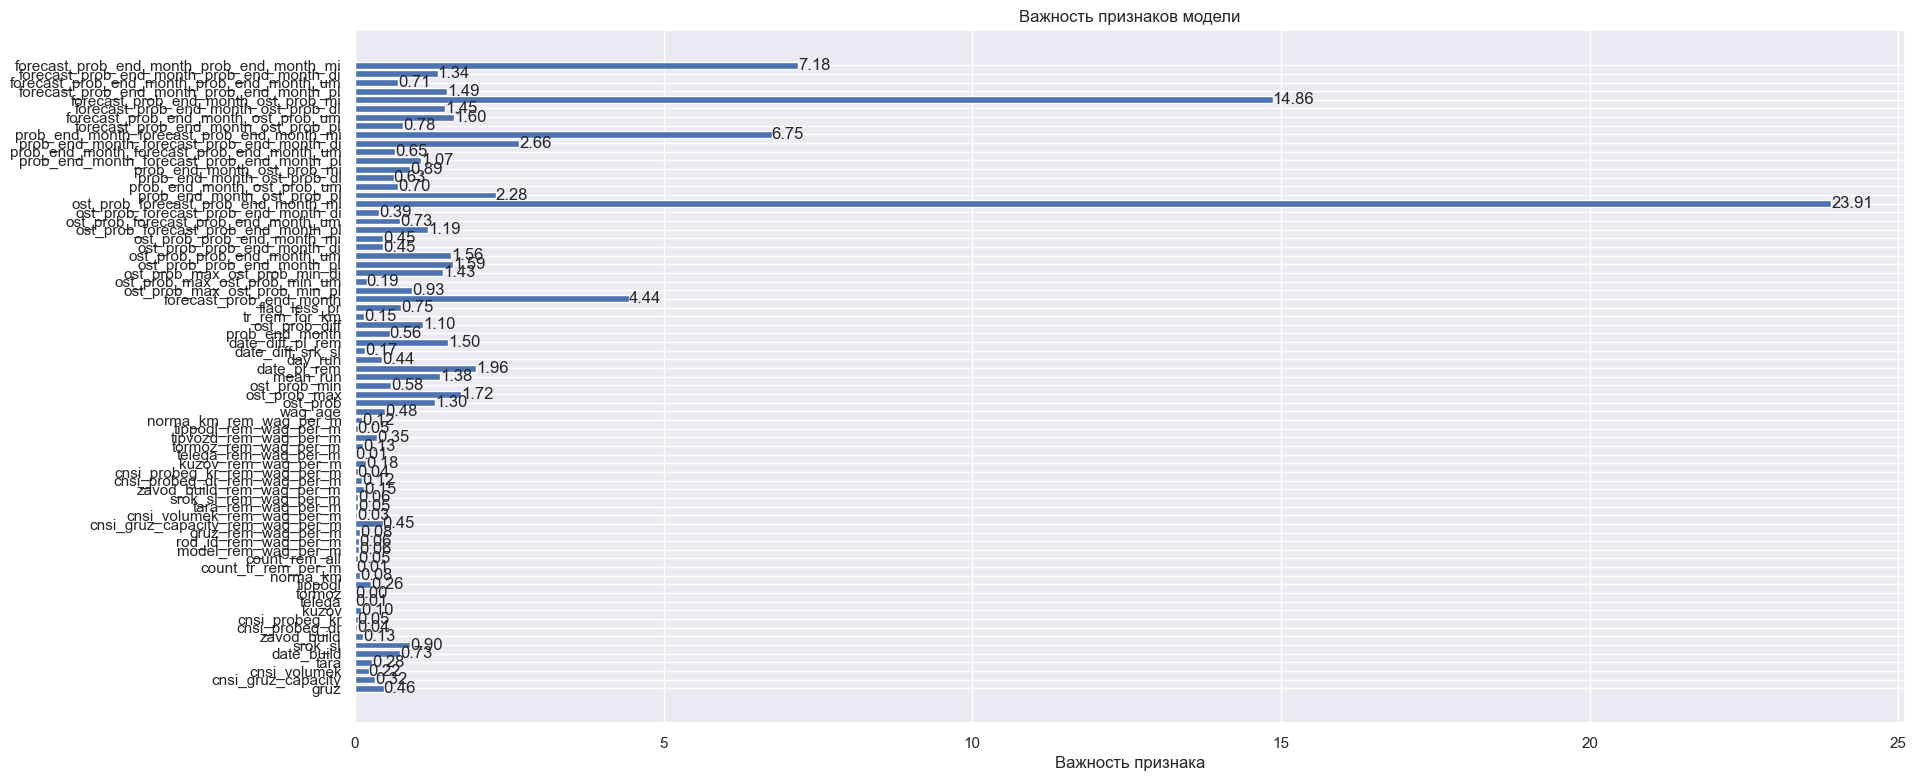

In [1107]:
clf_ver2_filt_fet, feat_imp_list_filt_fet = fit_model_get_f1_fet_imp(X_train_v2_filt_fet, y_train_v2_filt, need_cat_feat=False);

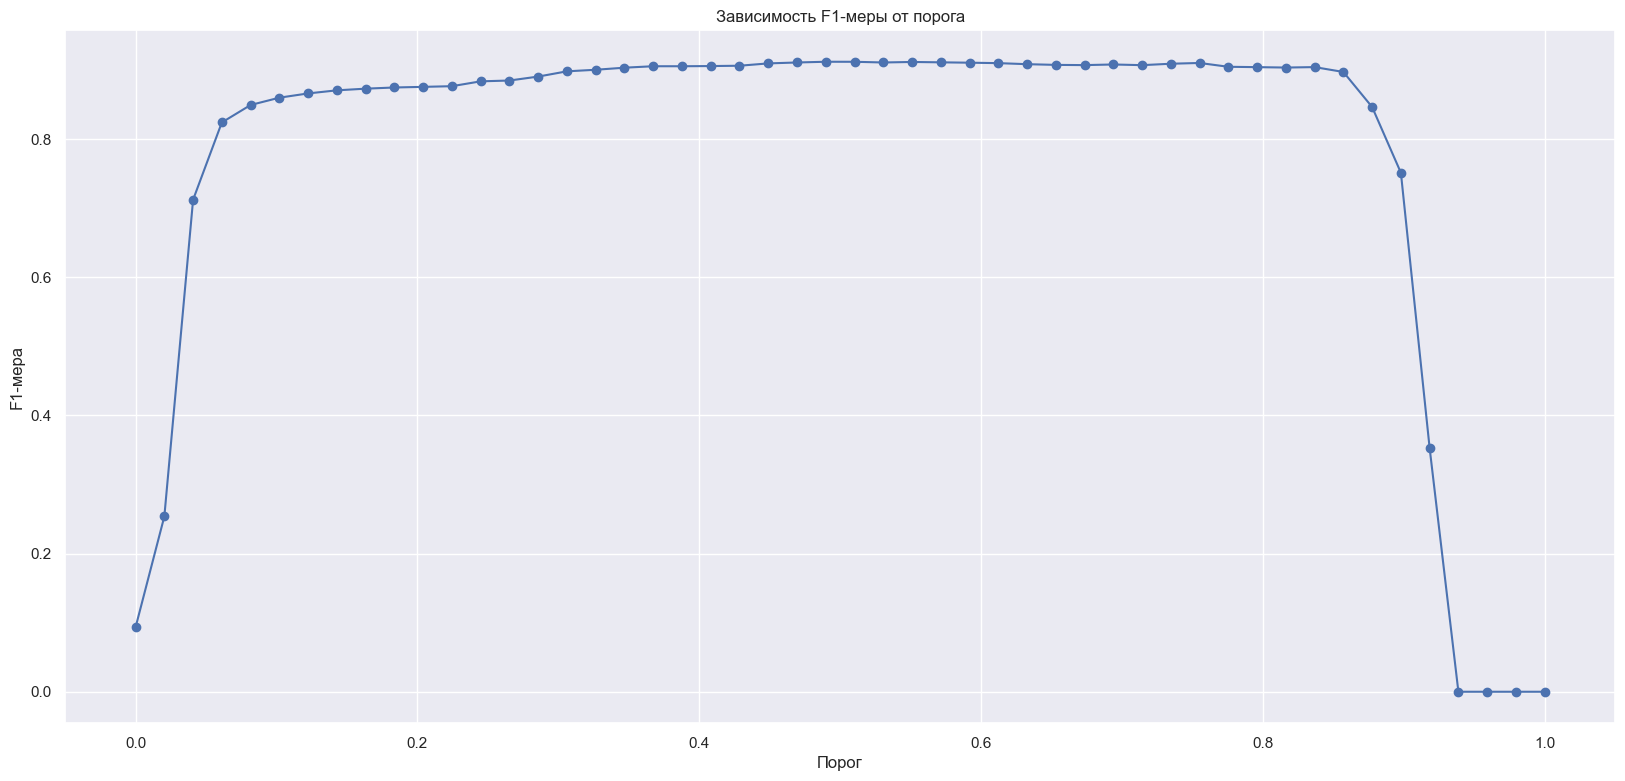

Лучший порог: 0.4897959183673469
f1 0.912


In [1108]:
make_and_plot_thre(clf_ver2_filt_fet, X_train_v2_filt_fet, y_train_v2_filt);

## Обучение. Только важные признаки

Было `0.59` на Декабре

In [1111]:
X_train_v2_filt_fet_f = X_train_v2_filt_fet[feat_imp_list_filt_fet]

cros_val_f1 0.8769657731978681


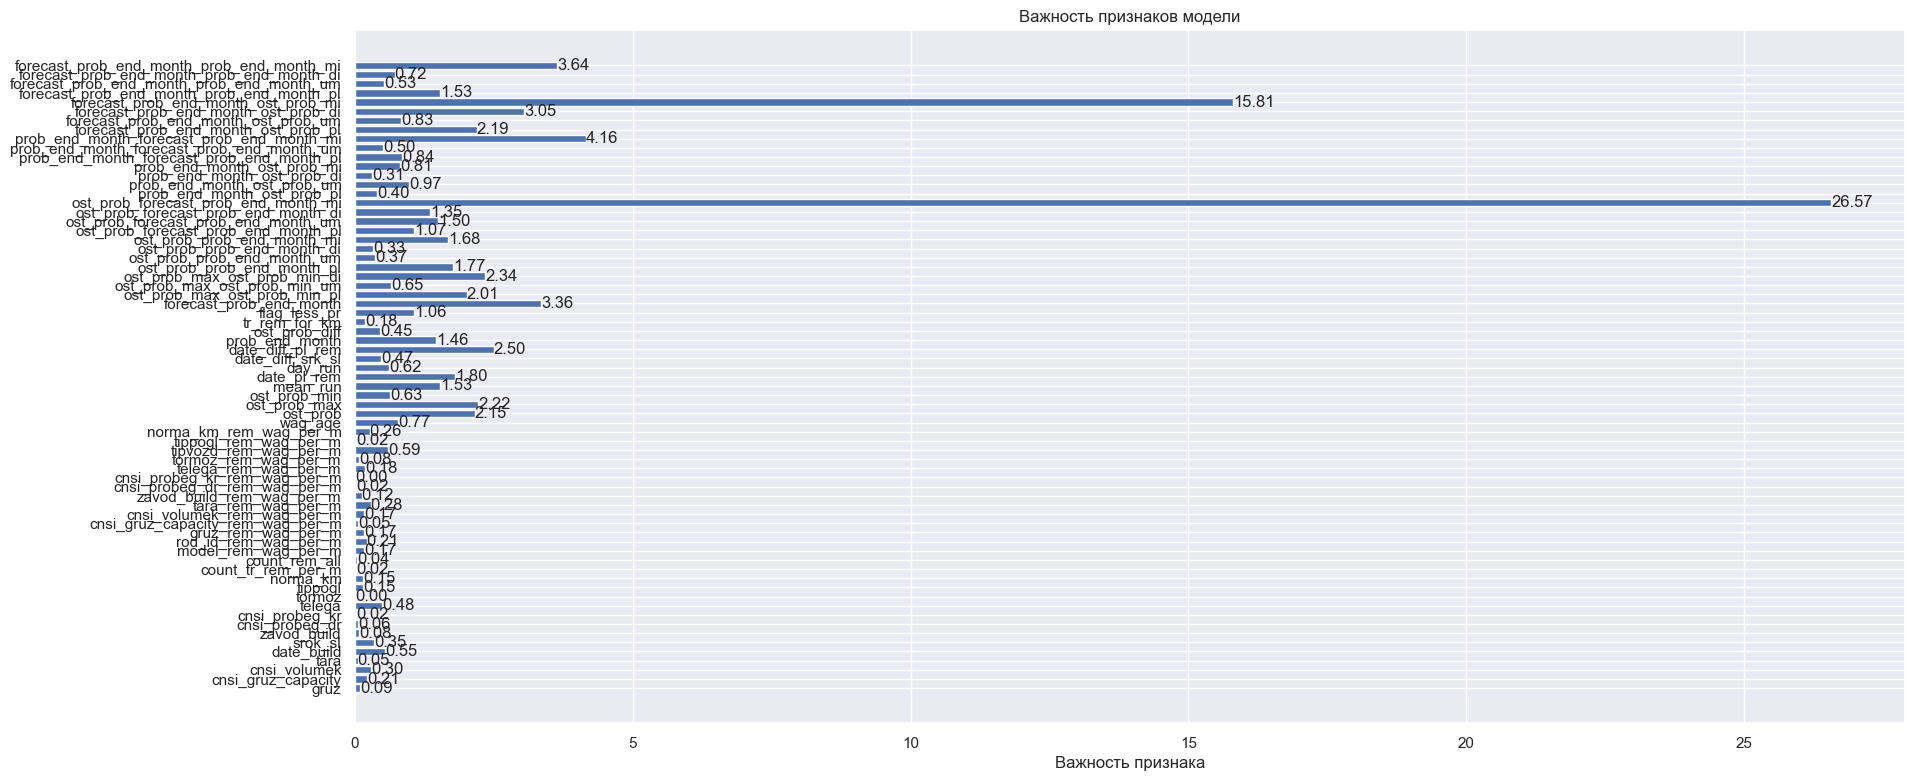

In [1112]:
clf_ver2_filt_imp , feat_imp_list_filt_imp = fit_model_get_f1_fet_imp(X_train_v2_filt_fet_f, y_train_v2_filt, need_cat_feat=False, bal='Balanced');

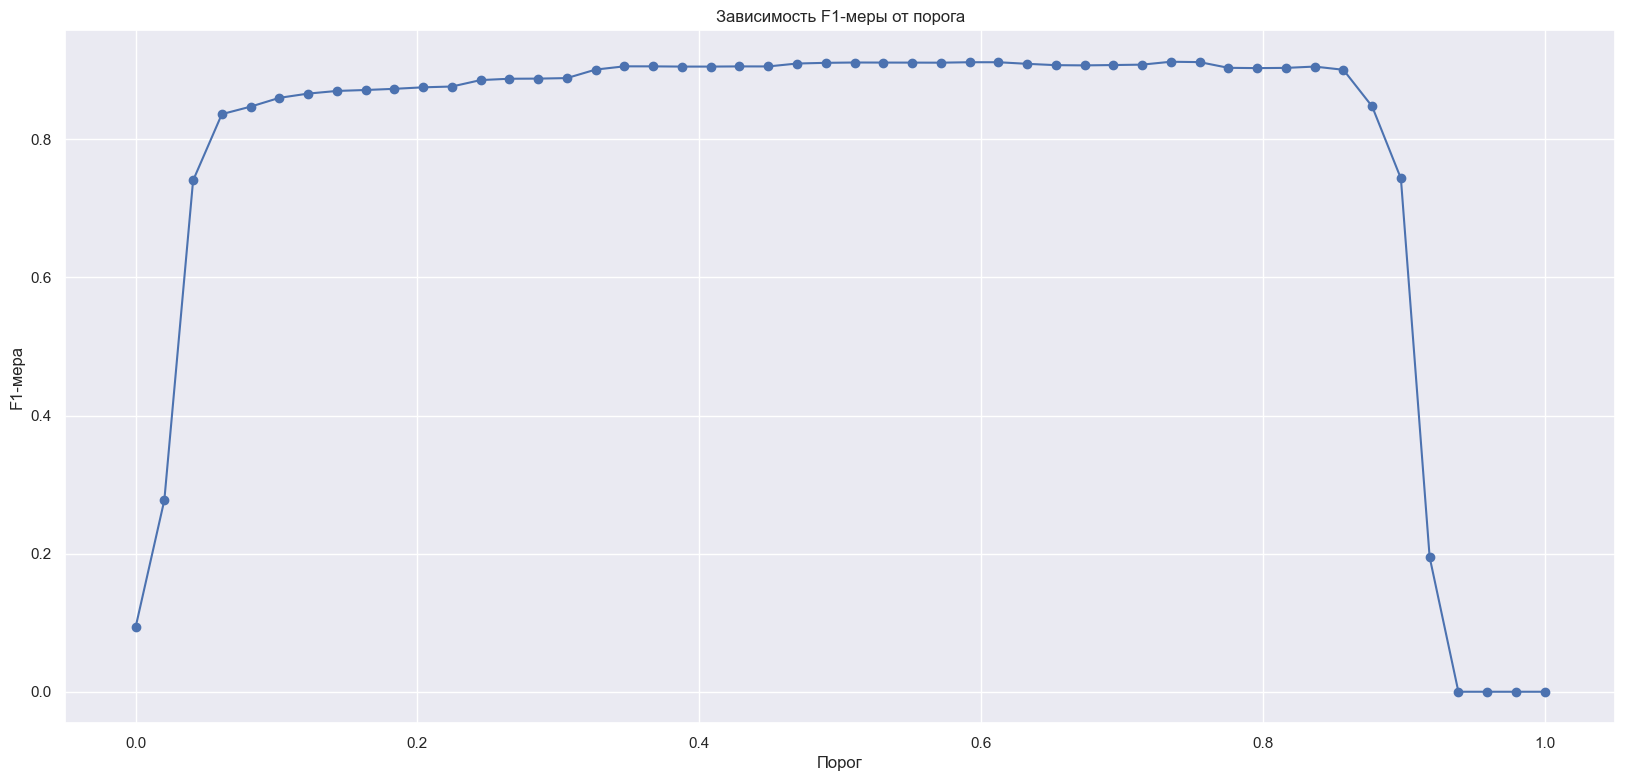

Лучший порог: 0.7346938775510203
f1 0.912


In [1113]:
best_threshold_month_v2, y_pred_binary_v2, y_pred_tr_v2 = make_and_plot_thre(clf_ver2_filt_imp, X_train_v2_filt_fet_f, y_train_v2_filt);

## Сохраняем ответы

In [1114]:
X_train_v2_filt_fet_f.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32301 entries, 0 to 33976
Data columns (total 73 columns):
 #   Column                                     Non-Null Count  Dtype         
---  ------                                     --------------  -----         
 0   gruz                                       32301 non-null  Int64         
 1   cnsi_gruz_capacity                         32301 non-null  Int64         
 2   cnsi_volumek                               32301 non-null  Float64       
 3   tara                                       32301 non-null  Int64         
 4   date_build                                 32301 non-null  datetime64[ns]
 5   srok_sl                                    32301 non-null  datetime64[ns]
 6   zavod_build                                32301 non-null  Int64         
 7   cnsi_probeg_dr                             32301 non-null  Int64         
 8   cnsi_probeg_kr                             32301 non-null  Int64         
 9   kuzov                 

In [1115]:
df_pred_month_v2 =\
pd.DataFrame(y_pred_binary_v2, columns=['target_month'], index=y_train_v2_filt.index)

In [1116]:
df_pred_month_v2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32301 entries, 0 to 33976
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   target_month  32301 non-null  int32
dtypes: int32(1)
memory usage: 410.1 KB


In [1117]:
df_pred_month_v2['target_month'].value_counts()

0    30541
1     1760
Name: target_month, dtype: int64

# target_day. target_month как фильтр. Важность признаков, f1, ver. 4

### Данные

In [1118]:
X_train_v2_day =\
X_train_v2_filt_fet.copy()

In [1119]:
X_train_v2_day =\
X_train_v2_day.join(df_pred_month_v2)

In [1120]:
X_train_v2_day =\
X_train_v2_day.query('target_month == 1').drop(columns=['target_month'])

In [1121]:
X_train_v2_day.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1760 entries, 91 to 33972
Data columns (total 79 columns):
 #   Column                                     Non-Null Count  Dtype         
---  ------                                     --------------  -----         
 0   gruz                                       1760 non-null   Int64         
 1   cnsi_gruz_capacity                         1760 non-null   Int64         
 2   cnsi_volumek                               1760 non-null   Float64       
 3   tara                                       1760 non-null   Int64         
 4   date_build                                 1760 non-null   datetime64[ns]
 5   srok_sl                                    1760 non-null   datetime64[ns]
 6   zavod_build                                1760 non-null   Int64         
 7   cnsi_probeg_dr                             1760 non-null   Int64         
 8   cnsi_probeg_kr                             1760 non-null   Int64         
 9   kuzov                 

In [1122]:
y_train_v2_day =\
y_train_v2_filt[y_train_v2_filt.index.isin(X_train_v2_day.index)]

In [1123]:
y_train_v2_day.info()

<class 'pandas.core.series.Series'>
Index: 1760 entries, 91 to 33972
Series name: target_month
Non-Null Count  Dtype
--------------  -----
1760 non-null   Int64
dtypes: Int64(1)
memory usage: 30.9 KB


### Обучение

cros_val_f1 0.8615039736471737


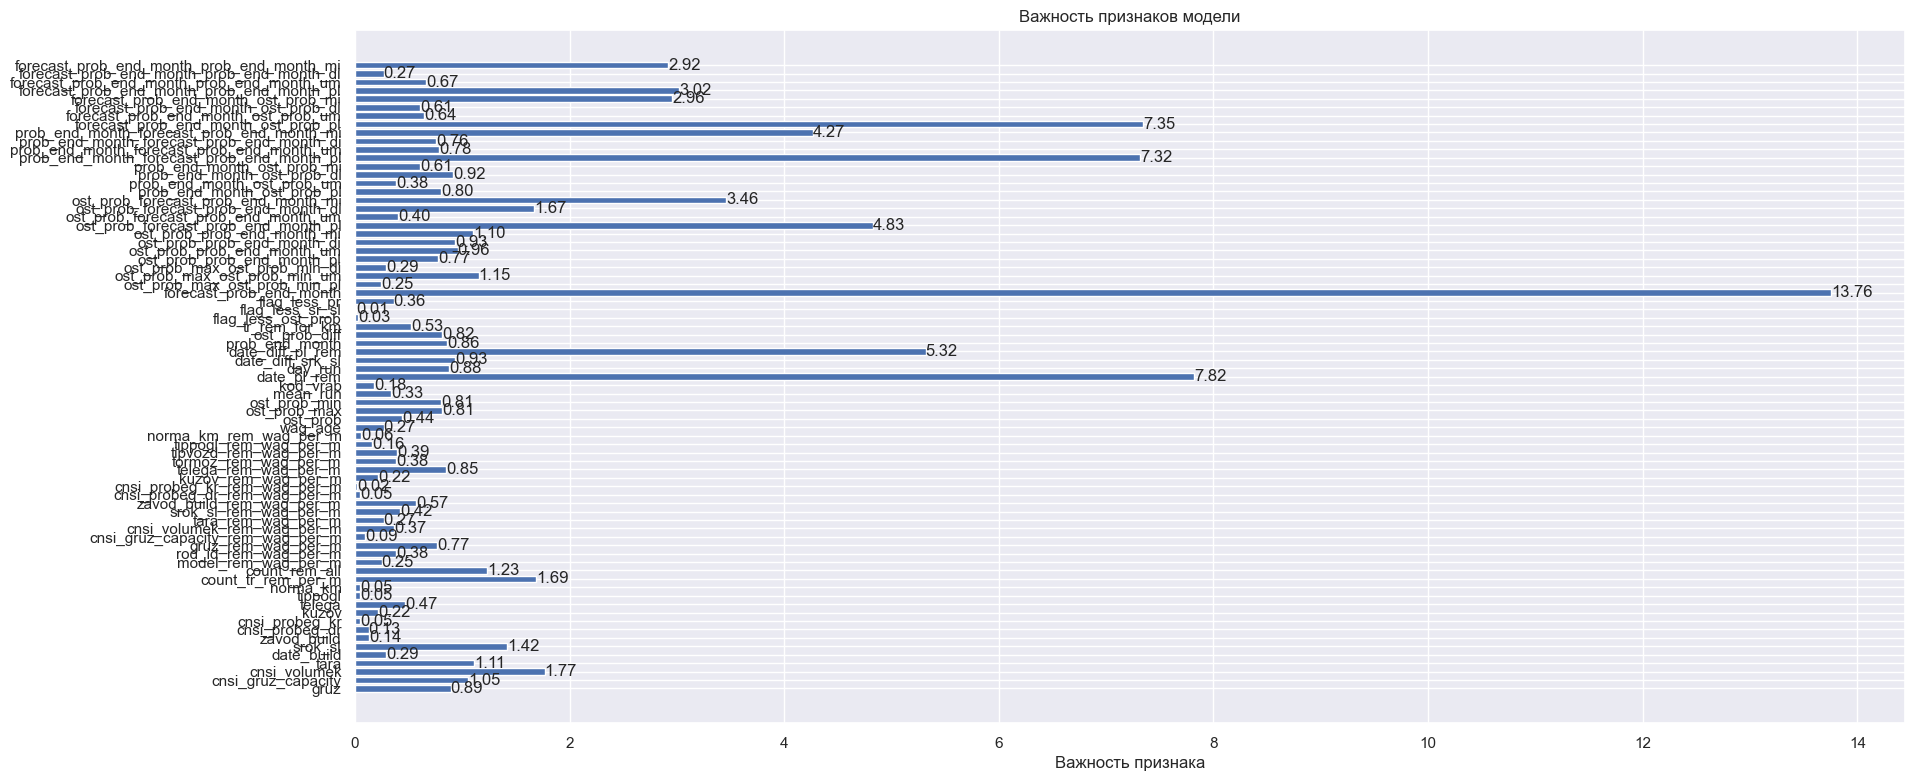

In [1124]:
clf_ver2_filt_day, feat_imp_list_filt_day = fit_model_get_f1_fet_imp(X_train_v2_day, y_train_v2_day, need_cat_feat=False, bal='Balanced')

In [1125]:
pred_day = clf_ver2_filt_day.predict(X_train_v2_day)

In [1126]:
pred_day.sum()

1477

### Только важные

In [1127]:
X_train_v2_day_f = X_train_v2_day[feat_imp_list_filt_day]

cros_val_f1 0.8609324376491841


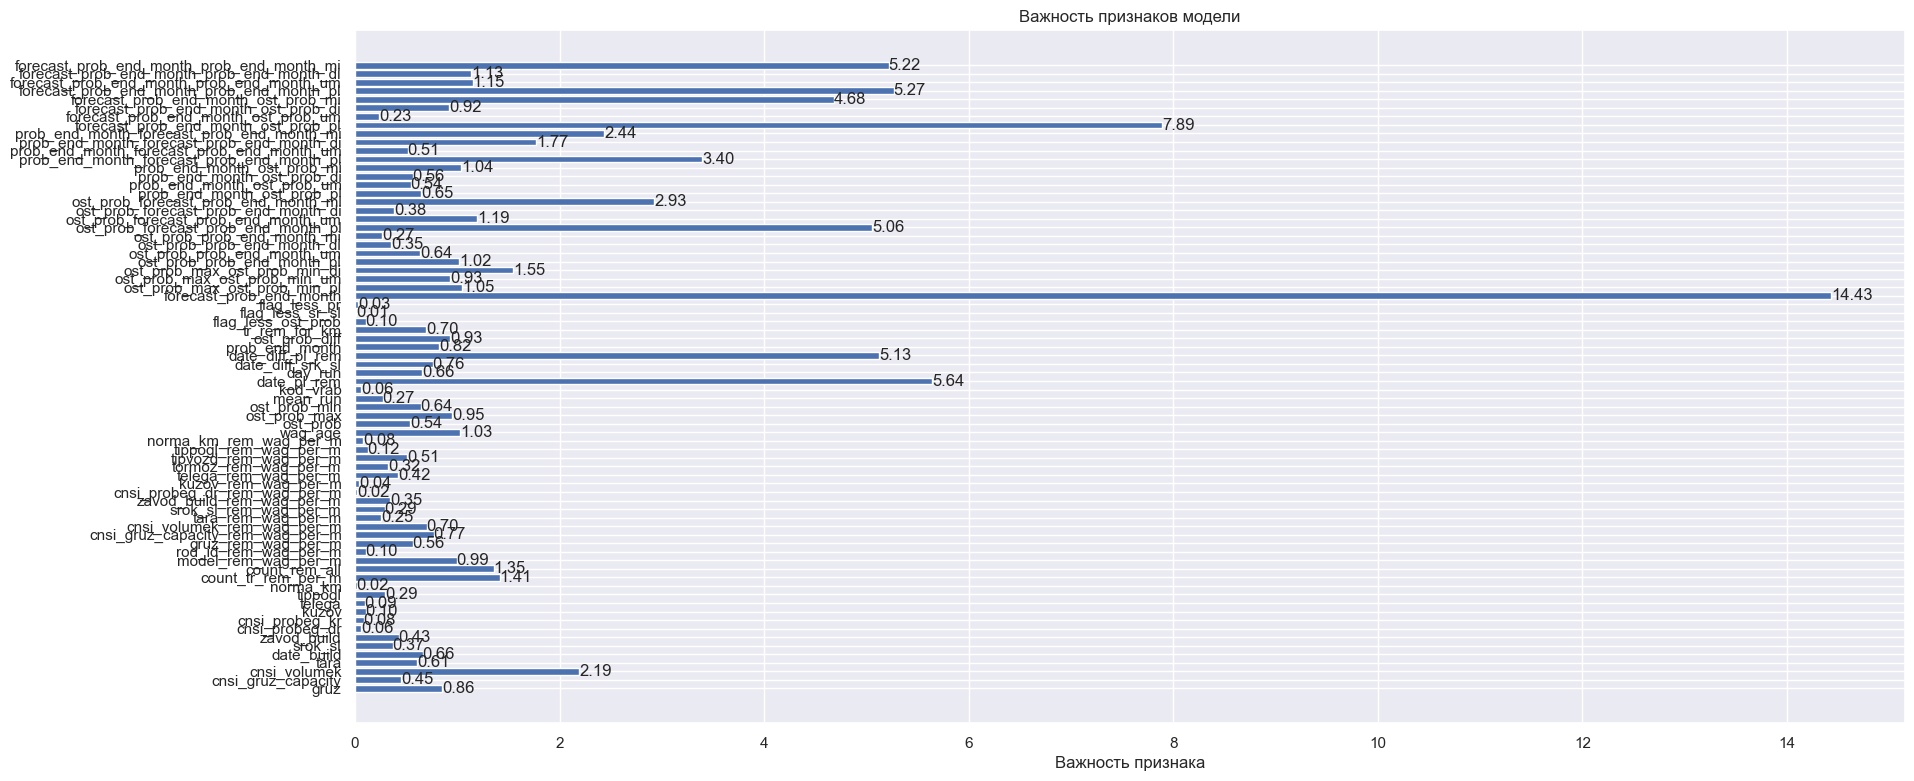

In [1128]:
clf_ver2_filt_day_f, feat_imp_list_filt_day_f = fit_model_get_f1_fet_imp(X_train_v2_day_f, y_train_v2_day, need_cat_feat=False, bal='Balanced')

### Порог

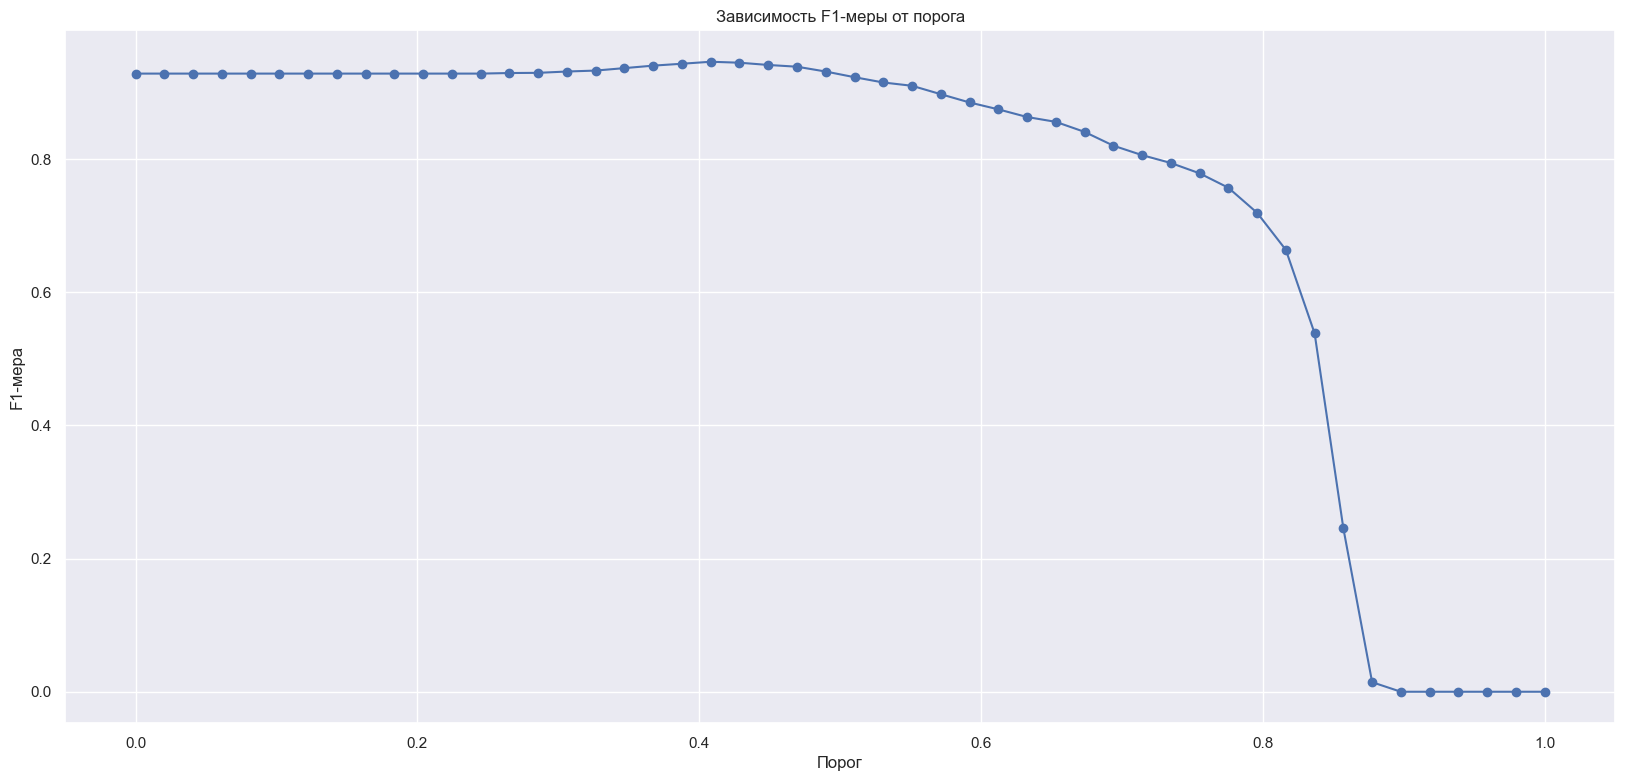

Лучший порог: 0.4081632653061224
f1 0.946


In [1129]:
best_threshold_month_v2_day, y_pred_binary_v2_day, y_pred_tr_v2_day = make_and_plot_thre(clf_ver2_filt_day_f, X_train_v2_day_f, y_train_v2_day)

In [1130]:
X_train_v2_day_f.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1760 entries, 91 to 33972
Data columns (total 75 columns):
 #   Column                                     Non-Null Count  Dtype         
---  ------                                     --------------  -----         
 0   gruz                                       1760 non-null   Int64         
 1   cnsi_gruz_capacity                         1760 non-null   Int64         
 2   cnsi_volumek                               1760 non-null   Float64       
 3   tara                                       1760 non-null   Int64         
 4   date_build                                 1760 non-null   datetime64[ns]
 5   srok_sl                                    1760 non-null   datetime64[ns]
 6   zavod_build                                1760 non-null   Int64         
 7   cnsi_probeg_dr                             1760 non-null   Int64         
 8   cnsi_probeg_kr                             1760 non-null   Int64         
 9   kuzov                 

In [1131]:
df_pred_day_v2 =\
pd.DataFrame(y_pred_binary_v2_day, columns=['target_day'], index=y_train_v2_day.index)

In [1132]:
df_pred_day_v2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1760 entries, 91 to 33972
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   target_day  1760 non-null   int32
dtypes: int32(1)
memory usage: 22.3 KB


In [1133]:
df_pred_day_v2['target_day'].value_counts()

1    1675
0      85
Name: target_day, dtype: int64

# Проверяем модель ver. 3 на тестовых данных (март)

## Тестовый датасет февраль v2

In [1134]:
# %%time
wp_test_real, target_test_real = make_wp_test_ver2(wag_param_clear_v2, wag_prob_clear_all, pr_rem_clear_all, tr_rem_clear_all, dislok_clear_all, target_clear_v2, '2023-03-01', 2)

target ['2023-03-01T00:00:00.000000000']

Достаём данные

В wag_prob уникальные даты: ['2022-08-01T00:00:00.000000000' '2023-02-28T00:00:00.000000000']

Собираем wag_param
Месяца [ 8  9 10 11 12  1  2]


C:\Users\mayer\AppData\Local\Temp\ipykernel_21784\1739779545.py:16: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  wag_param.merge(wag_rem_months_group, on='wagnum', how='left')
C:\Users\mayer\AppData\Local\Temp\ipykernel_21784\1739779545.py:16: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  wag_param.merge(wag_rem_months_group, on='wagnum', how='left')


Месяца [ 8  9 10 11 12  1  2]
Месяца [ 8  9 10 11 12  1  2]
Месяца [ 8  9 10 11 12  1  2]
Месяца [ 8  9 10 11 12  1  2]
Месяца [ 8  9 10 11 12  1  2]
Месяца [ 8  9 10 11 12  1  2]
Месяца [ 8  9 10 11 12  1  2]
Месяца [ 8  9 10 11 12  1  2]
Месяца [ 8  9 10 11 12  1  2]
Месяца [ 8  9 10 11 12  1  2]
Месяца [ 8  9 10 11 12  1  2]
Месяца [ 8  9 10 11 12  1  2]
Месяца [ 8  9 10 11 12  1  2]
Месяца [ 8  9 10 11 12  1  2]
Месяца [ 8  9 10 11 12  1  2]
Месяца [ 8  9 10 11 12  1  2]
Месяца [ 8  9 10 11 12  1  2]
Месяца в wag_param [8, 9, 10, 11, 12, 1, 2]

pr_rem за месяц: 2
Was_repair_in_month_1
Was_repair_in_month_12
Was_repair_in_month_11
Was_repair_in_month_10
Was_repair_in_month_9
Was_repair_in_month_8
pr_rem_columns Index(['wagnum', 'was_repair_in_month_2', 'was_repair_in_month_1',
       'was_repair_in_month_12', 'was_repair_in_month_11',
       'was_repair_in_month_10', 'was_repair_in_month_9',
       'was_repair_in_month_8'],
      dtype='object') 

tr_rem за месяц: 2

В dislok уникал

In [1135]:
wp_test_real.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33707 entries, 0 to 33706
Data columns (total 56 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   wagnum                            33707 non-null  Int64         
 1   model                             33707 non-null  string        
 2   rod_id                            33707 non-null  Int64         
 3   gruz                              33707 non-null  Int64         
 4   cnsi_gruz_capacity                33707 non-null  Int64         
 5   cnsi_volumek                      33707 non-null  Float64       
 6   tara                              33707 non-null  Int64         
 7   date_build                        33707 non-null  datetime64[ns]
 8   srok_sl                           33707 non-null  datetime64[ns]
 9   zavod_build                       33707 non-null  Int64         
 10  cnsi_probeg_dr                    33707 non-nu

In [1136]:
wp_test_real.head()

wagnum       model  rod_id  gruz  cnsi_gruz_capacity  cnsi_volumek  tara  \
0   33361  12-1303-01       1   690                 690          88.0   245   
1   33364  12-1303-01       1   690                 690          88.0   245   
2   33366  12-1303-01       1   690                 690          88.0   245   
3   33358  12-1303-01       1   690                 690          88.0   245   
4   33349  12-1303-01       1   690                 690          88.0   245   

  date_build    srok_sl  zavod_build  cnsi_probeg_dr  cnsi_probeg_kr  kuzov  \
0 2011-02-08 2033-03-01            6             110             160      2   
1 2010-04-21 2031-04-12            6             110             160      2   
2 2010-06-23 2032-01-21            6             110             160      2   
3 2012-09-27 2032-11-30            6             110             160      2   
4 2011-11-20 2033-12-04            6             110             160      2   

   telega  tormoz tipvozd  tippogl  norma_km  ownertype  count_tr_rem_per_m  \
0       2       2       3       11    160000          0                 1.5   
1       2       2       3       11    160000          0                 2.0   
2       2       2       3       11    160000          0                 2.0   
3       2       2       3       11    160000          0                 2.0   
4       2       2       6       11    160000          0                 0.0   

   count_rem_all  model_rem_wag_per_m  rod_id_rem_wag_per_m  \
0            3.0             1.941624              1.995803   
1            2.0             1.941624              1.995803   
2            2.0             1.941624              1.995803   
3            2.0             1.941624              1.995803   
4            0.0             1.941624              1.995803   

   gruz_rem_wag_per_m  cnsi_gruz_capacity_rem_wag_per_m  \
0             1.98119                           1.98119   
1             1.98119                           1.98119   
2             1.98119                           1.98119   
3             1.98119                           1.98119   
4             1.98119                           1.98119   

   cnsi_volumek_rem_wag_per_m  tara_rem_wag_per_m  date_build_rem_wag_per_m  \
0                     1.98069            1.943016                  2.083333   
1                     1.98069            1.943016                  2.000000   
2                     1.98069            1.943016                  2.000000   
3                     1.98069            1.943016                  2.250000   
4                     1.98069            1.943016                  2.200000   

   srok_sl_rem_wag_per_m  zavod_build_rem_wag_per_m  \
0               1.916667                   1.984252   
1               2.500000                   1.984252   
2               2.000000                   1.984252   
3               2.250000                   1.984252   
4               1.694444                   1.984252   

   cnsi_probeg_dr_rem_wag_per_m  cnsi_probeg_kr_rem_wag_per_m  \
0                      1.962495                      1.971315   
1                      1.962495                      1.971315   
2                      1.962495                      1.971315   
3                      1.962495                      1.971315   
4                      1.962495                      1.971315   

   kuzov_rem_wag_per_m  telega_rem_wag_per_m  tormoz_rem_wag_per_m  \
0             1.969246                1.9861              1.960699   
1             1.969246                1.9861              1.960699   
2             1.969246                1.9861              1.960699   
3             1.969246                1.9861              1.960699   
4             1.969246                1.9861              1.960699   

   tipvozd_rem_wag_per_m  tippogl_rem_wag_per_m  norma_km_rem_wag_per_m  \
0               1.936906               1.976244                1.972471   
1               1.936906               1.976244                1.972471   
2

In [1137]:
target_test_real.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33707 entries, 0 to 33706
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   wagnum  33707 non-null  Int64         
 1   month   33707 non-null  datetime64[ns]
dtypes: Int64(1), datetime64[ns](1)
memory usage: 822.9 KB


In [1138]:
X_test_real = make_features_wp_test_ver2(wp_test_real, '2023-03-01')

Считаем среднедневный пробег
Заполняме пропуски
Сортируем номега вагонов


In [1141]:
df_arima_preds_test =\
pd.read_csv('./arima_forecast_prob_end_month')

In [1142]:
df_arima_preds_test = df_arima_preds_test.drop(columns=['Unnamed: 0']).set_index('wagnum')

In [1143]:
df_arima_preds_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32970 entries, 33361 to 33350
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   forecast_30  32970 non-null  float64
dtypes: float64(1)
memory usage: 515.2 KB


In [1144]:
X_test_real =\
X_test_real.join(df_arima_preds_test, how='left')

In [1145]:
X_test_real['forecast_30'] = X_test_real['forecast_30'].fillna(X_test_real['forecast_30'].mean())

In [1146]:
X_test_real.rename(columns={'forecast_30': 'forecast_prob_end_month'}, inplace=True)

In [1147]:
X_test_real.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33707 entries, 0 to 33976
Data columns (total 75 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   model                             33707 non-null  string        
 1   rod_id                            33707 non-null  Int64         
 2   gruz                              33707 non-null  Int64         
 3   cnsi_gruz_capacity                33707 non-null  Int64         
 4   cnsi_volumek                      33707 non-null  Float64       
 5   tara                              33707 non-null  Int64         
 6   date_build                        33707 non-null  datetime64[ns]
 7   srok_sl                           33707 non-null  datetime64[ns]
 8   zavod_build                       33707 non-null  Int64         
 9   cnsi_probeg_dr                    33707 non-null  Int64         
 10  cnsi_probeg_kr                    33707 non-null  I

In [1148]:
# Генерим доп. фичи
X_test_real = perform_operations(X_test_real, 'ost_prob_max', 'ost_prob_min', ['+', '/', '*'])

In [1149]:
# Перебираем уже сохраненные важные признаки
for col1 in important_features_gr_3:
    for col2 in important_features_gr_3:
        if col1 != col2:
            X_test_real = perform_operations(X_test_real, col1, col2)

In [1150]:
X_test_real['rod_id'] = X_test_real['rod_id'].astype(float)

In [1151]:
X_test_real.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33707 entries, 0 to 33976
Data columns (total 95 columns):
 #   Column                                     Non-Null Count  Dtype         
---  ------                                     --------------  -----         
 0   model                                      33707 non-null  string        
 1   rod_id                                     33707 non-null  float64       
 2   gruz                                       33707 non-null  Int64         
 3   cnsi_gruz_capacity                         33707 non-null  Int64         
 4   cnsi_volumek                               33707 non-null  Float64       
 5   tara                                       33707 non-null  Int64         
 6   date_build                                 33707 non-null  datetime64[ns]
 7   srok_sl                                    33707 non-null  datetime64[ns]
 8   zavod_build                                33707 non-null  Int64         
 9   cnsi_probeg_dr        

In [1152]:
X_test_real.head()

model  rod_id  gruz  cnsi_gruz_capacity  cnsi_volumek  tara  \
wagnum                                                                    
0          11-276     0.0   680                 680         122.0   244   
1       11-066-04     0.0   680                 680         120.0   220   
2       Р-9494-01     0.0   680                 680         122.0   252   
3       11-066-04     0.0   680                 680         120.0   220   
4          11-217     0.0   680                 680         120.0   235   

       date_build    srok_sl  zavod_build  cnsi_probeg_dr  cnsi_probeg_kr  \
wagnum                                                                      
0      1993-06-17 2025-12-03            1             110             160   
1      1994-07-09 2026-03-07            1             110             160   
2      1994-10-30 2026-11-15            1             110             160   
3      1993-10-04 2025-10-03            1             110             160   
4      1994-06-03 2028-08-01           23             110             160   

        kuzov  telega  tormoz tipvozd  tippogl  norma_km  ownertype  \
wagnum                                                                
0           2       9       2       1       11    160000          0   
1           1       9       2       4        1    160000          0   
2          22       9       2       1       15    110000          0   
3           1       9       2       4        1    110000          0   
4           2       9       3       6        1    160000          0   

        count_tr_rem_per_m  count_rem_all  model_rem_wag_per_m  \
wagnum                                                           
0                      1.0            2.0             1.904648   
1                      0.0            0.0             2.000000   
2                      2.0            4.0             2.000000   
3                      2.0            2.0             2.000000   
4                      0.0            0.0             0.000000   

        rod_id_rem_wag_per_m  gruz_rem_wag_per_m  \
wagnum                                             
0                   1.901954             1.86736   
1                   1.901954             1.86736   
2                   1.901954             1.86736   
3                   1.901954             1.86736   
4                   1.901954             1.86736   

        cnsi_gruz_capacity_rem_wag_per_m  cnsi_volumek_rem_wag_per_m  \
wagnum                                                                 
0                                1.86736                    1.907716   
1                                1.86736                    1.625000   
2                                1.86736                    1.907716   
3                                1.86736                    1.625000   
4                                1.86736                    1.625000   

        tara_rem_wag_per_m  date_build_rem_wag_per_m  srok_sl_rem_wag_per_m  \
wagnum                                                                        
0                 1.985582                  1.166667               1.666667   
1                 2.077381                  0.000000               2.011905   
2                 2.000000                  1.900000               1.472222   
3                 2.077381                  2.666667               1.250000   
4                 2.035035                  2.500000               1.916667   

        zavod_build_rem_wag_per_m  cnsi_probeg_dr_rem_wag_per_m  \
wagnum                                                            
0                        1.911367                      1.962495   
1                        1.911367                      1.962495   
2                        1.911367                      1.962495   
3                        1.911367                      1.962495   
4                        0.000000                      1.962495   

        cnsi_probeg_kr_rem_wag_per_m  kuzov_rem_wag_per_m  \
wagnum                        

## Предикт месяцев

In [1153]:
y_pred_test_real = clf_ver2_filt_imp.predict(X_test_real[X_train_v2_filt_fet_f.columns])

In [1154]:
y_pred_test_real.sum()

1

In [1155]:
y_pred_test_pb = clf_ver2_filt_imp.predict_proba(X_test_real[X_train_v2_filt_fet_f.columns])[:, 1]  # Получение вероятностей положительного класса
y_pred_test_pb_binary = (y_pred_test_pb > best_threshold_month_v2).astype(int)  # Бинарные предсказания

In [1156]:
df_pred_test_binary =\
pd.DataFrame(y_pred_test_pb_binary, columns=['target_month'], index=X_test_real.index)

In [1157]:
df_pred_test_binary.head()

target_month
wagnum              
0                  0
1                  0
2                  0
3                  0
4                  0

In [1158]:
df_pred_test_binary['target_month'].value_counts()

0    33706
1        1
Name: target_month, dtype: int64

## Предикт дней

In [1159]:
X_test_real_day = X_test_real[X_test_real.index.isin(df_pred_test_binary[df_pred_test_binary['target_month'] == 1].index)]

In [1160]:
X_test_real_day.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1 entries, 19303 to 19303
Data columns (total 95 columns):
 #   Column                                     Non-Null Count  Dtype         
---  ------                                     --------------  -----         
 0   model                                      1 non-null      string        
 1   rod_id                                     1 non-null      float64       
 2   gruz                                       1 non-null      Int64         
 3   cnsi_gruz_capacity                         1 non-null      Int64         
 4   cnsi_volumek                               1 non-null      Float64       
 5   tara                                       1 non-null      Int64         
 6   date_build                                 1 non-null      datetime64[ns]
 7   srok_sl                                    1 non-null      datetime64[ns]
 8   zavod_build                                1 non-null      Int64         
 9   cnsi_probeg_dr        

In [1161]:
y_pred_test_real_day = clf_ver2_filt_day_f.predict(X_test_real_day[X_train_v2_day_f.columns])

In [1162]:
y_pred_test_real_day.sum()

1

In [1163]:
y_pred_test_real_day_pb = clf_ver2_filt_day_f.predict_proba(X_test_real_day[X_train_v2_day_f.columns])[:, 1]  # Получение вероятностей положительного класса
y_pred_test_real_day_binary = (y_pred_test_real_day_pb > best_threshold_month_v2_day).astype(int)  # Бинарные предсказания

In [1164]:
df_pred_test_day_binary =\
pd.DataFrame(y_pred_test_real_day, columns=['target_day'], index=X_test_real_day.index)

In [1165]:
df_pred_test_day_binary.head()

target_day
wagnum            
19303            1

In [1166]:
df_pred_test_day_binary['target_day'].value_counts()

1    1
Name: target_day, dtype: int64

## Собираем файл

In [1051]:
df_test_reall_v1 = collect_file_test(target_test_real, df_pred_test_binary, df_pred_test_day_binary)

In [1052]:
df_test_reall_v1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33707 entries, 33361 to 8061
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   month         33707 non-null  datetime64[ns]
 1   target_month  33707 non-null  int32         
 2   target_day    33707 non-null  int32         
dtypes: datetime64[ns](1), int32(2)
memory usage: 1.8 MB


In [1053]:
df_test_reall_v1['target_month'].sum(), df_test_reall_v1['target_day'].sum()

(1614, 1402)

In [1054]:
# UPD 0.38 score
df_test_reall_v1.to_csv('dodics_pred_v7.csv')